Here we will rebuild the work done in hertzian_dipole.ipynb using all pytorch functions and implement a custom loss function containing Maxwell's equations.

In [143]:
import math

import numpy as np
import matplotlib.pyplot as plt
import torch

In [144]:
### constants and units are defined in here ###
c = 10
eps_0 = 1/c
mu_0 = 1/c

p_0 = 20.0
omega = 5.0

In [145]:
### functions to generate points ###
def generate_xz_grid_tensor(max_coord, grid_length: int):
    '''Generate a grid of x,z co-ordinated in range (-max_coord, max_coord). Number of points is grid_length^2'''

    x = torch.linspace(-max_coord, max_coord, steps=grid_length, requires_grad=True)
    z = torch.linspace(-max_coord, max_coord, steps=grid_length, requires_grad=True)

    return torch.meshgrid(x, z, indexing='xy')

def generate_xzt_grid_tensor(max_coord, time_range, grid_length: int):

    x = torch.linspace(-max_coord, max_coord, steps=grid_length, requires_grad=True)
    z = torch.linspace(-max_coord, max_coord, steps=grid_length, requires_grad=True)
    t = torch.linspace(0, time_range, steps=grid_length, requires_grad=True)

    return torch.meshgrid(x,z,t, indexing='xy')

def generate_xyz_grid_tensor(max_coord, grid_length: int):

    x = torch.linspace(-max_coord, max_coord, steps=grid_length, requires_grad=True)
    y = torch.linspace(-max_coord, max_coord, steps=grid_length, requires_grad=True)
    z = torch.linspace(-max_coord, max_coord, steps=grid_length, requires_grad=True)

    return torch.meshgrid(x,y,z, indexing='xy')

def xz_to_rtheta(x,z):
    '''Converts xz points into a plane of constant phi r theta co-ords'''

    r = torch.sqrt(x**2 + z**2)
    theta = torch.atan2(x, z)
    theta = torch.where(theta>0, theta, 2*math.pi - torch.abs(theta)) #converts the (-pi, pi) interval to a (0,2*pi) interval

    return r,theta

def rtheta_to_xz(r,theta):
    
    x = r*torch.sin(theta)
    z = r*torch.cos(theta)

    return x,z

def generate_rtheta_tensor(min_radius, max_radius, grid_length: int):
    '''Generates r values on (min_radius, max_radius) interval and theta on (0, 2*pi). Will not produce a nice grid in xz plane,
       but will meshgrid these two intervals together.'''

    r = torch.linspace(min_radius, max_radius, steps=grid_length, requires_grad=True)
    theta = torch.linspace(0.01, 2*math.pi - 0.01, steps=grid_length, requires_grad=True) #little incremement at boundary to stop pole

    return torch.meshgrid(r, theta, indexing='xy')

def generate_rtheta_t_tensor(min_radius, max_radius, time_range, grid_length: int):
    '''Generates r values on (min_radius, max_radius) interval and theta on (0, 2*pi), and t on (0,time_range). 
       Will not produce a nice grid in xz plane, but will meshgrid these two intervals together.'''

    r = torch.linspace(min_radius, max_radius, steps=grid_length, requires_grad=True)
    theta = torch.linspace(0.01, 2*math.pi - 0.01, steps=grid_length, requires_grad=True)
    t = torch.linspace(0, time_range, steps=grid_length, requires_grad=True)

    return torch.meshgrid(r,theta,t, indexing='xy')

def generate_rtheta_grid_tensor(max_coord, grid_length: int):
    '''Generate an xz plane grid from -max_coord to max_coord, expressed in r and theta co-ordinates'''

    if grid_length%2!=0:
        print('Warning: odd number grid length leads to r=0, thus divergences in electric field')

    x,z = generate_xz_grid_tensor(max_coord, grid_length)

    r = torch.sqrt(x**2 + z**2)
    theta = torch.atan2(x, z)
    theta = torch.where(theta>0, theta, 2*math.pi - torch.abs(theta)) #converts the (-pi, pi) interval to a (0,2*pi) interval

    ### how to implement tolerance here without messing up dimensions??
    ### I don't need to, just when plotting avoid plotting points near origin

    return r, theta

def generate_rtheta_t_grid_tensor(max_coord, time_range, grid_length: int):

    if grid_length%2!=0:
        print('Warning: odd number grid length leads to r=0, thus divergences in electric field')

    x,z,t = generate_xzt_grid_tensor(max_coord, time_range, grid_length)

    r = torch.sqrt(x**2 + z**2)
    theta = torch.atan2(x, z)
    theta = torch.where(theta>0, theta, 2*math.pi - torch.abs(theta)) #converts the (-pi, pi) interval to a (0,2*pi) interval

    return r,theta,t

def generate_rthetaphi_t_tensor(min_radius, max_radius, time_range, grid_length):

    if grid_length%2!=0:
        print('Warning: odd number grid length leads to r=0, thus divergences in electric field')

    r = torch.linspace(min_radius, max_radius, steps=grid_length, requires_grad=True)
    theta = torch.linspace(0.01, 2*math.pi - 0.01, steps=grid_length, requires_grad=True)
    t = torch.linspace(0, time_range, steps=grid_length, requires_grad=True)

In [177]:
### functions to generate field here ###
def E_field_HD_tensor(x,y,z,t,p_0=p_0,omega=omega, noise=False):
   '''Calculates the real electric field due to a Hertzian dipole at the origin, aligned with z-axis, for a harmonically oscillating charge on the dipole.
      Time input should be either single valued, or with the same dimensions as x,y,z'''
   r = torch.sqrt(x**2 + y**2 + z**2) #the distance from origin at (x,y,z)
   ret_p = p_0 * torch.cos(omega*(t - r/c)) #the dipole moment evaluated at retarded time for c=10
   ret_p_dot = -omega * p_0 * torch.sin(omega*(t-r/c)) #first time deriv
   ret_p_ddot = -omega**2 * p_0 * torch.cos(omega*(t - r/c)) #second time deriv

   radial_bracket = ret_p/(r**3) + ret_p_dot/(c*r**2) #bracket in radial electric field term
   polar_bracket = ret_p/(r**3) + ret_p_dot/(c*r**2) + ret_p_ddot/(c**2*r) #bracket in polar electric field term

   E_x = (2*x*z)/(4*math.pi*eps_0*r**2) * radial_bracket + (x*z)/(4*math.pi*eps_0*r**2) * polar_bracket
   E_y = (2*y*z)/(4*math.pi*eps_0*r**2) * radial_bracket + (y*z)/(4*math.pi*eps_0*r**2) * polar_bracket
   E_z = (2*z**2)/(4*math.pi*eps_0*r**2) * radial_bracket - (x**2 + y**2)/(4*math.pi*eps_0*r**2) * polar_bracket

   if noise:
      E_x = E_x + torch.normal(0.0, 0.1*torch.mean(torch.abs(E_x)))
      E_y = E_y + torch.normal(0.0, 0.1*torch.mean(torch.abs(E_y)))
      E_z = E_z + torch.normal(0.0, 0.1*torch.mean(torch.abs(E_z)))

   return torch.stack((E_x, E_y, E_z), axis=-1)

def E_rtheta_field_HD_tensor(r,theta,t, p_0=p_0, omega=omega, noise=False):
   '''Calculates the real electric field's r and theta components'''

   ret_p = p_0 * torch.cos(omega*(t - r/c)) #the dipole moment evaluated at retarded time for c=10
   ret_p_dot = -omega * p_0 * torch.sin(omega*(t-r/c)) #first time deriv
   ret_p_ddot = -omega**2 * p_0 * torch.cos(omega*(t - r/c)) #second time deriv

   radial_bracket = ret_p/(r**3) + ret_p_dot/(c*r**2) #bracket in radial electric field term
   polar_bracket = ret_p/(r**3) + ret_p_dot/(c*r**2) + ret_p_ddot/(c**2*r) #bracket in polar electric field term

   E_r = (2*torch.cos(theta)/(4*math.pi*eps_0))*radial_bracket
   E_theta = (torch.sin(theta)/(4*math.pi*eps_0))*polar_bracket

   if noise:
      E_r = E_r + torch.normal(0.0, 0.1*torch.mean(torch.abs(E_r)))
      E_theta = E_theta + torch.normal(0.0, 0.1*torch.mean(torch.abs(E_theta)))

   return torch.stack((E_r, E_theta), axis=-1)

def E_rtheta_in_xz_field_HD_tensor(r,theta,t, p_0=p_0, omega=omega, noise=False, phi=0.0):

   E_rtheta = E_rtheta_field_HD_tensor(r,theta,t, p_0=p_0, omega=omega, noise=noise)
   phi = torch.tensor(phi)
   E_x = torch.sin(theta)*torch.cos(phi)*E_rtheta[...,0] + torch.cos(theta)*torch.cos(phi)*E_rtheta[...,1]
   E_z = torch.cos(theta)*E_rtheta[...,0] - torch.sin(theta)*E_rtheta[...,1]

   return torch.stack((E_x, E_z), axis=-1)

def B_field_HD_tensor(x,y,z,t,p_0=p_0,omega=omega, noise=False):
   '''Calculates the real magnetic field due to a Hertzian dipole at the origin, aligned with z-axis, for a harmonically oscillating charge on the dipole.
      Time input should be a fixed time.'''
   r = torch.sqrt(x**2 + y**2 + z**2) #the distance from origin at (x,y,z)
   ret_p_dot = -omega * p_0 * torch.sin(omega*(t-r/c)) #first time deriv
   ret_p_ddot = -omega**2 * p_0 * torch.cos(omega*(t - r/c)) #second time deriv

   azimuth_bracket = ret_p_dot/(r**2) + ret_p_ddot/(c*r)

   B_x = -(mu_0*y)/(4*math.pi*r) * azimuth_bracket
   B_y = (mu_0*x)/(4*math.pi*r) * azimuth_bracket
   B_z = torch.zeros_like(B_x)

   if noise:
      B_x = B_x + torch.normal(0.0, 0.1*torch.mean(torch.abs(B_x)))
      B_y = B_y + torch.normal(0.0, 0.1*torch.mean(torch.abs(B_y)))
      B_z = B_z + torch.normal(0.0, 0.1*torch.mean(torch.abs(B_z)))

   return torch.stack((B_x, B_y, B_z), axis=-1)

def B_phit_field_HD_tensor(r, theta, t, p_0=p_0, omega=omega, noise=False):
   '''Calculates the real magnetic field's phi component'''

   ret_p = p_0 * torch.cos(omega*(t - r/c)) #the dipole moment evaluated at retarded time for c=10
   ret_p_dot = -omega * p_0 * torch.sin(omega*(t-r/c)) #first time deriv
   ret_p_ddot = -omega**2 * p_0 * torch.cos(omega*(t - r/c)) #second time deriv

   az_bracket = ret_p_dot/(r**2) + ret_p_ddot/(r*c)

   B_phi = -(mu_0*torch.sin(theta))/(4*math.pi) * az_bracket

   if noise:
      B_phi = B_phi + torch.normal(0.0, 0.1*torch.mean(torch.abs(B_phi)))

   return B_phi

In [147]:
### functions to compute gradients of fields here ###

def compute_rtheta_gradients(E_r, E_theta, r, theta):
    '''Computes dE_r/dr and dE_theta/dtheta gradients'''
    
    dE_r_dr = torch.autograd.grad(outputs=E_r, inputs=r, grad_outputs=torch.ones_like(E_r), retain_graph=True, create_graph=True)[0]
    dE_theta_dtheta = torch.autograd.grad(outputs=E_theta, inputs=theta, grad_outputs=torch.ones_like(E_theta), retain_graph=True, create_graph=True)[0]

    return dE_r_dr, dE_theta_dtheta

def compute_polar_divergence(E_r, E_theta, r, theta):
    '''Computes the divergence of the electric field'''

    dE_r_dr, dE_theta_dtheta = compute_rtheta_gradients(E_r, E_theta, r, theta)

    div = ( (2/r)*E_r + dE_r_dr ) + (1/r)*( (1/torch.tan(theta))*E_theta + dE_theta_dtheta )

    return div

def compute_spherical_divergence(A_r, r, A_theta, theta, A_phi, phi):
    '''Compute the spherical divergence of a vector field A'''
    dA_r_dr = torch.autograd.grad(outputs=A_r, inputs=r, grad_outputs=torch.ones_like(A_r), retain_graph=True, create_graph=True)[0]
    dA_theta_dtheta = torch.autograd.grad(outputs=A_theta, inputs=theta, grad_outputs=torch.ones_like(A_theta), retain_graph=True, create_graph=True)[0]
    dA_phi_dphi = torch.autograd.grad(outputs=A_phi, inputs=phi, grad_outputs=torch.ones_like(A_phi), retain_graph=True, create_graph=True)[0]

    div = ( (2/r)*A_r + dA_r_dr ) + (1/r)*( (1/torch.tan(theta))*A_theta + dA_theta_dtheta ) + ( 1/(r*torch.sin(theta)) )*dA_phi_dphi

    return div

def compute_spherical_curl(A_r, r, A_theta, theta, A_phi, phi):
    '''Computes the spherical curl of a vector field A, returns the curl of A in r, theta, and phi directions'''

    #curl in r direction
    r_first = A_phi * torch.sin(theta) #first term, needs differentiating
    r_first_deriv = torch.autograd.grad(outputs=r_first, inputs=theta, grad_outputs=torch.ones_like(r_first), retain_graph=True, create_graph=True)[0]
    r_second_deriv = torch.autograd.grad(outputs=A_theta, inputs=phi, grad_outputs=torch.ones_like(A_theta), retain_graph=True, create_graph=True)[0]

    curl_r = (1/(r*torch.sin(theta)))*(r_first_deriv - r_second_deriv)

    #curl in theta direction
    theta_first_deriv = torch.autograd.grad(outputs=A_r, inputs=phi, grad_outputs=torch.ones_like(A_r), retain_graph=True, create_graph=True)[0]
    theta_second = r * A_phi
    theta_second_deriv = torch.autograd.grad(outputs=theta_second, inputs=r, grad_outputs=torch.ones_like(theta_second), retain_graph=True, create_graph=True)[0]

    curl_theta = (1/r)*((1/torch.sin(theta))*theta_first_deriv - theta_second_deriv)

    #curl in phi direction
    phi_first = r * A_theta
    phi_first_deriv = torch.autograd.grad(outputs=phi_first, inputs=r, grad_outputs=torch.ones_like(phi_first), retain_graph=True, create_graph=True)[0]
    phi_second_deriv = torch.autograd.grad(outputs=A_r, inputs=theta, grad_outputs=torch.ones_like(A_r), retain_graph=True, create_graph=True)[0]

    curl_phi = (1/r)*(phi_first_deriv - phi_second_deriv)

    return curl_r, curl_theta, curl_phi

def compute_phisym_spherical_curl(A_r, r, A_theta, theta, A_phi):
    '''Computes the spherical curl of a vector field A, returns the curl of A in r, theta, and phi directions, where A is known/assumed to have
       symmetry in phi, i.e. no phi dependance'''

    #curl in r direction
    r_first = A_phi * torch.sin(theta) #first term, needs differentiating
    r_first_deriv = torch.autograd.grad(outputs=r_first, inputs=theta, grad_outputs=torch.ones_like(r_first), retain_graph=True, create_graph=True)[0]

    curl_r = (1/(r*torch.sin(theta)))*(r_first_deriv)

    #curl in theta direction
    theta_second = r * A_phi
    theta_second_deriv = torch.autograd.grad(outputs=theta_second, inputs=r, grad_outputs=torch.ones_like(theta_second), retain_graph=True, create_graph=True)[0]

    curl_theta = (1/r)*(-theta_second_deriv)

    #curl in phi direction
    phi_first = r * A_theta
    phi_first_deriv = torch.autograd.grad(outputs=phi_first, inputs=r, grad_outputs=torch.ones_like(phi_first), retain_graph=True, create_graph=True)[0]
    phi_second_deriv = torch.autograd.grad(outputs=A_r, inputs=theta, grad_outputs=torch.ones_like(A_r), retain_graph=True, create_graph=True)[0]

    curl_phi = (1/r)*(phi_first_deriv - phi_second_deriv)

    return curl_r, curl_theta, curl_phi    
    

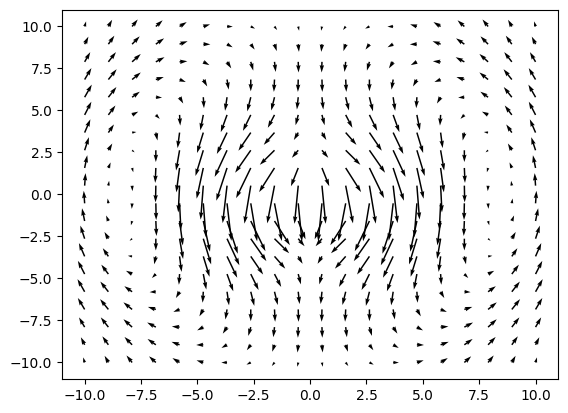

In [148]:
test_x, test_z, test_t = generate_xzt_grid_tensor(10, 2*math.pi/omega, 20)
test_E = E_field_HD_tensor(test_x, 3.0, test_z, test_t, p_0, omega)
test_E_x, test_E_y, test_E_z = test_E[...,0], test_E[...,1], test_E[...,2]

plt.quiver(test_x[:,:,0].detach().numpy(), test_z[:,:,0].detach().numpy(), test_E_x[:,:,0].detach().numpy(), test_E_z[:,:,0].detach().numpy())

# t varies along the last axis
# x varies along second axis
# z varies along first axis

#new pytorch written functions work!

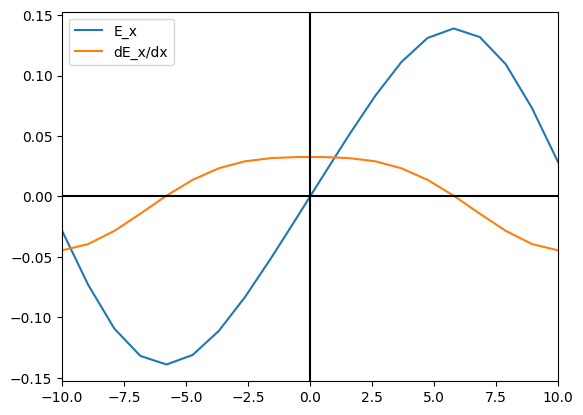

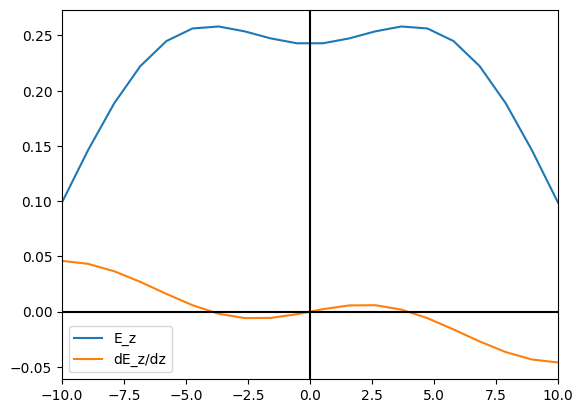

In [149]:
test_dE_x_dx = torch.autograd.grad(outputs=test_E_x, inputs=test_x, grad_outputs=torch.ones_like(test_E_x), retain_graph=True, create_graph=True)[0]
test_dE_z_dz = torch.autograd.grad(outputs=test_E_z, inputs=test_z, grad_outputs=torch.ones_like(test_E_z), retain_graph=True, create_graph=True)[0]
test_dE_y_dy = test_dE_x_dx #this doesn't work currently, more thought needed to see if possible

plt.figure('x derivs')
plt.plot(test_x[0,:,0].detach().numpy(), test_E_x[0,:,0].detach().numpy(), label='E_x')
plt.plot(test_x[0,:,0].detach().numpy(), test_dE_x_dx[0,:,0].detach().numpy(), label='dE_x/dx')
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.xlim(-10,10)
plt.legend()
plt.show()

plt.figure('z derivs')
plt.plot(test_z[:,0,0].detach().numpy(), test_E_z[:,0,0].detach().numpy(), label='E_z')
plt.plot(test_z[:,0,0].detach().numpy(), test_dE_z_dz[:,0,0].detach().numpy(), label='dE_z/dz')
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.xlim(-10,10)
plt.legend()
plt.show()

In [150]:
#test whether divergence im getting is correct here

div_test_x, div_test_y, div_test_z = generate_xyz_grid_tensor(10, 50)
div_test_E = E_field_HD_tensor(div_test_x, div_test_y, div_test_z, 0.0, p_0, omega)
div_test_E_x, div_test_E_y, div_test_E_z = div_test_E[...,0], div_test_E[...,1], div_test_E[...,2]

div_test_dE_x_dx = torch.autograd.grad(outputs=div_test_E_x, inputs=div_test_x, grad_outputs=torch.ones_like(div_test_E_x), create_graph=True, retain_graph=True)[0]
div_test_dE_y_dy = torch.autograd.grad(outputs=div_test_E_y, inputs=div_test_y, grad_outputs=torch.ones_like(div_test_E_y), create_graph=True, retain_graph=True)[0]
div_test_dE_z_dz = torch.autograd.grad(outputs=div_test_E_z, inputs=div_test_z, grad_outputs=torch.ones_like(div_test_E_z), create_graph=True, retain_graph=True)[0]

div = div_test_dE_x_dx + div_test_dE_y_dy + div_test_dE_z_dz

#divergence of the field is 0 as expected! Success! 

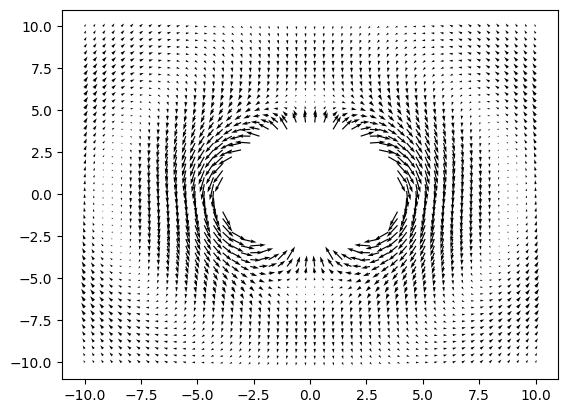

In [151]:
test_r, test_theta = generate_rtheta_grid_tensor(10.0, 50)

foo_E_xz = E_rtheta_in_xz_field_HD_tensor(test_r, test_theta, 0.0, p_0, omega)
foo_E_rtheta = E_rtheta_field_HD_tensor(test_r, test_theta, 0.0, p_0, omega)
foo_E_x, foo_E_z = foo_E_xz[...,0], foo_E_xz[...,1]
foo_E_r, foo_E_theta = foo_E_rtheta[...,0], foo_E_rtheta[...,1]

clean_pts = test_r > 4.0
clean_r, clean_theta = test_r[clean_pts], test_theta[clean_pts]
clean_x, clean_z = rtheta_to_xz(clean_r, clean_theta)
clean_E_x, clean_E_z = foo_E_x[clean_pts], foo_E_z[clean_pts]

plt.quiver(clean_x.detach().numpy(), clean_z.detach().numpy(), clean_E_x.detach().numpy(), clean_E_z.detach().numpy())
### as long as we have evenly numbered grid, we shouldn't have any r=0 points, therefore no divergences
### so we can still compute functions, but simply avoid plotting near origin as it is messy

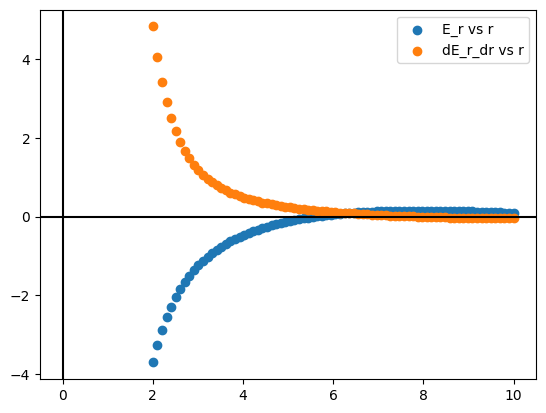

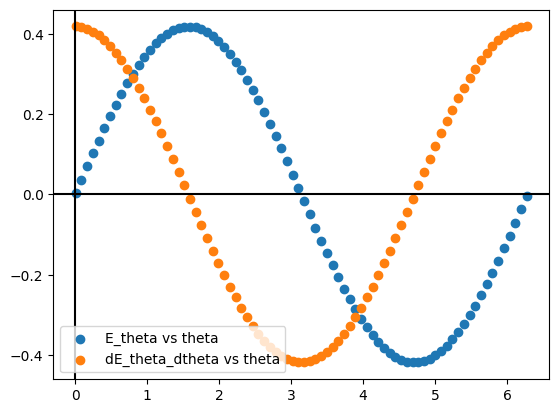

In [152]:
### test gradients of our now polar co-ordinate fields
### have calculated these analytically, and div should be 0
### calculating div is not as trivial as with cartesian co-ords, so tread carefully

bar_r, bar_theta = generate_rtheta_tensor(2.0, 10.0, 80)
bar_E_rtheta = E_rtheta_field_HD_tensor(bar_r, bar_theta, 0.0, p_0, omega)
bar_E_r, bar_E_theta = bar_E_rtheta[...,0], bar_E_rtheta[...,1]
bar_dE_r_dr, bar_dE_theta_dtheta = compute_rtheta_gradients(bar_E_r, bar_E_theta, bar_r, bar_theta)

plt.figure('radial gradients')
plt.scatter(bar_r[50,:].detach().numpy(), bar_E_r[50,:].detach().numpy(), label='E_r vs r')
plt.scatter(bar_r[50,:].detach().numpy(), bar_dE_r_dr[50,:].detach().numpy(), label='dE_r_dr vs r')
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.legend()

plt.figure('polar gradients')
plt.scatter(bar_theta[:,50].detach().numpy(), bar_E_theta[:,50].detach().numpy(), label='E_theta vs theta')
plt.scatter(bar_theta[:,50].detach().numpy(), bar_dE_theta_dtheta[:,50].detach().numpy(), label='dE_theta_dtheta vs theta')
plt.axhline(y=0, c='black')
plt.axvline(x=0, c='black')
plt.legend()

plt.show()

In [153]:
### build the NN models here ###

class MLP_Model(torch.nn.Module):

    def __init__(self, input_size, N1, N2, N3, N4, N5, N6, output_size):
        super(MLP_Model, self).__init__() #inherits the nn.module __init__()
        self.linear1 = torch.nn.Linear(input_size, N1) #first linear layer, with N1 hidden neurons
        self.act1 = torch.nn.SiLU() #activation layer using a sigmoid function since this is smooth and differentiable
        self.linear2 = torch.nn.Linear(N1, N2) #second linear layer, and output
        self.act2 = torch.nn.SiLU()
        self.linear3 = torch.nn.Linear(N2, N3)
        self.act3 = torch.nn.SiLU()
        self.linear4 = torch.nn.Linear(N3, N4)
        self.act4 = torch.nn.SiLU()
        self.linear5 = torch.nn.Linear(N4, N5)
        self.act5 = torch.nn.SiLU()
        self.linear6 = torch.nn.Linear(N5, N6)
        self.act6 = torch.nn.SiLU()
        self.linear7 = torch.nn.Linear(N6, output_size)
        
    def forward(self, x): #defines the forward propagation of input, x
        x = self.linear1(x)
        x = self.act1(x)
        x = self.linear2(x) 
        x = self.act2(x) 
        x = self.linear3(x) 
        x = self.act3(x) 
        x = self.linear4(x) 
        x = self.act4(x) 
        x = self.linear5(x) 
        x = self.act5(x) 
        x = self.linear6(x) 
        x = self.act6(x) 
        yhat = self.linear7(x) #yhat is the approximate solution that is outputted
        return yhat

In [166]:
### here we will build a class containing everything needed to train the networks ###
### WIP ###
class MLP_network:
    def __init__(self, input, training_data):
        #device = torch.device("mps") if torch.backends.mps.is_available() and torch.backends.mps.is_built() else torch.device("cpu")
        device = torch.device("cpu")

        self.model = MLP_Model(3, 60,100,120,120,100,60, 2).to(device)

        self.X = input
        self.X = self.X.to(device)
        self.X_train = input.detach()
        self.X_train = self.X_train.to(device)

        self.Y = training_data
        self.Y = self.Y.to(device)
        self.Y_train = training_data.detach()
        self.Y_train = self.Y_train.to(device)

        self.iter = 1 #used to print loss at intervals

        self.ls_criterion = torch.nn.MSELoss()
        self.adam = torch.optim.Adam(self.model.parameters(), lr=0.001)

        self.losses_MLP = []

    def loss_func(self): #for now this is just simple mse loss, but will implement soft constraints

        yhat = self.model(self.X_train)
        loss_data = self.ls_criterion(yhat, self.Y_train)
        loss = loss_data

        return loss

    def train(self, epochs):
        for epoch in range(epochs):
            self.adam.zero_grad()
            train_loss = self.loss_func()
            #print(train_loss)
            self.losses_MLP.append(train_loss.item())
            train_loss.backward()
            self.adam.step()

            fifth_progress = epochs // 5
            if epoch % fifth_progress == 0:
                print(epoch, train_loss.item())

        plt.figure('losses')
        plt.plot(np.linspace(0,len(self.losses_MLP),len(self.losses_MLP)), np.log(self.losses_MLP))
        plt.xlabel('Number of epochs')
        plt.ylabel('log MSE Loss')
        plt.show()

        return self.losses_MLP[-1]

### data and divergence loss function ###
class supervised_soft_network:
    def __init__(self, input, training_data, alpha, beta):
        #device = torch.device("mps") if torch.backends.mps.is_available() and torch.backends.mps.is_built() else torch.device("cpu")
        device = torch.device("cpu")

        self.model = MLP_Model(3, 60,100,120,120,100,60, 2).to(device) #(r, theta, t) input, two outputs, (E_r, E_theta)

        # make sure input is in (grid_size, grid_size, grid_size, 3) format
        self.X = input
        self.X = self.X.to(device)
        self.X_train = input.detach()
        self.X_train = self.X_train.to(device)

        self.Y = training_data
        self.Y = self.Y.to(device)
        self.Y_train = training_data.detach()
        self.Y_train = self.Y_train.to(device)

        self.iter = 1 #used to print loss at intervals

        self.alpha = alpha
        self.beta = beta

        self.ls_criterion = torch.nn.MSELoss()
        self.adam = torch.optim.Adam(self.model.parameters(), lr=0.001)

        self.losses_network = []

    def loss_func(self):
        
        yhat = self.model(self.X_train)
        loss_data = self.ls_criterion(yhat, self.Y_train)

        # r = self.X[:,:,:,0:1]
        # theta = self.X[:,:,:,1:2]
        # t = self.X[:,:,:,2:3] #WIP SQUEEZE THESE
        # u = self.model(torch.stack((r,theta,t), dim=-1))
        # print(u.size())
        # u_r = u[:,:,0]
        # u_theta = u[:,:,1]
        #this process is unnecessary for divergence as we can do it much more simply using only one call to autograd.grad
        #however it was done purely informatively since we will need to do something similar when implementing curl terms

        u = self.model(self.X)
        du_dX = torch.autograd.grad(outputs=u, inputs=self.X, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_r_dr = du_dX[...,0]
        du_theta_dtheta = du_dX[...,1]
        u_div = ( (2/self.X[...,0])*u[...,0] + du_r_dr ) + (1/self.X[...,0])*( (1/torch.tan(self.X[...,1]))*u[...,1] + du_theta_dtheta )#minimise this as divergence should be 0

        loss_div = self.ls_criterion(u_div, torch.zeros_like(u_div, requires_grad=False))
        loss = self.alpha * loss_data + self.beta * loss_div
        #print(loss_data, loss_div)

        return loss

    def train(self, epochs):
        for epoch in range(epochs):
            self.adam.zero_grad()
            train_loss = self.loss_func()
            #print(train_loss)
            self.losses_network.append(train_loss.item())
            train_loss.backward()
            self.adam.step()

            fifth_progress = epochs // 5
            if epoch % fifth_progress == 0:
                print(epoch, train_loss.item())

        plt.figure('losses')
        plt.plot(np.linspace(0,len(self.losses_network),len(self.losses_network)), np.log(self.losses_network))
        plt.xlabel('Number of epochs')
        plt.ylabel('log MSE Loss')

        plt.figure('theta dependance')
        plt.scatter(self.X_train[:,0,0,1].cpu().detach().numpy(), self.Y_train[:,0,0,1], label='Training data')
        plt.scatter(self.X_train[:,0,0,1].cpu().detach().numpy(), self.model(self.X_train)[:,0,0,1].cpu().detach().numpy(), label='Model output')
        plt.xlabel('Theta')
        plt.ylabel('Model E_theta')
        plt.legend()
        plt.show()

        return(self.losses_network[-1])

### data, div(E), and curl(E) loss function ###
class Maxwell_supervised_network:
    def __init__(self, input, training_data, alpha, beta, gamma):
        #device = torch.device("mps") if torch.backends.mps.is_available() and torch.backends.mps.is_built() else torch.device("cpu")
        device = torch.device("cpu")

        self.model = MLP_Model(3, 60,100,120,120,100,60, 6).to(device) #(r, theta, t) input, 6 outputs, (E_r, E_theta, E_phi, B_r, B_theta, B_phi)
        #expect E_phi and B_r and B_theta to be 0, but need the outputs to take curl of network
        
        # make sure input is in (grid_size, grid_size, grid_size, 3) format
        self.X = input
        self.X = self.X.to(device)
        self.X_train = input.detach()
        self.X_train = self.X_train.to(device)

        self.Y = training_data
        self.Y = self.Y.to(device)
        self.Y_train = training_data.detach()
        self.Y_train = self.Y_train.to(device)

        self.iter = 1 #used to print loss at intervals

        self.alpha = alpha
        self.beta = beta
        self.gamma = gamma

        self.ls_criterion = torch.nn.MSELoss()
        self.adam = torch.optim.Adam(self.model.parameters(), lr=0.001)

        self.losses_network = []

    def loss_func(self):

        ### supervised loss ###
        yhat = self.model(self.X_train)
        loss_data = self.ls_criterion(yhat, self.Y_train)
        #######################

        ### divergence loss ###
        u = self.model(self.X)
        du_dX = torch.autograd.grad(outputs=u, inputs=self.X, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        du_r_dr = du_dX[...,0] #dE_r_dr
        du_theta_dtheta = du_dX[...,1] #dE_theta_dtheta
        u_div = ( (2/self.X[...,0])*u[...,0] + du_r_dr ) + (1/self.X[...,0])*( (1/torch.tan(self.X[...,1]))*u[...,1] + du_theta_dtheta )#minimise this as divergence should be 0
        loss_div = self.ls_criterion(u_div, torch.zeros_like(u_div, requires_grad=False))
        #######################

        ### curl loss ###
        r = self.X[...,0:1]
        r = torch.squeeze(r)
        theta = self.X[...,1:2]
        theta = torch.squeeze(theta)
        t = self.X[...,2:3]
        t = torch.squeeze(t)

        v = self.model(torch.stack((r,theta,t), dim=-1))
        model_E_r, model_E_theta, model_E_phi = v[...,0:1], v[...,1:2], v[...,2:3]
        model_E_r, model_E_theta, model_E_phi = torch.squeeze(model_E_r), torch.squeeze(model_E_theta), torch.squeeze(model_E_phi)
        model_B_r, model_B_theta, model_B_phi = v[...,3:4], v[...,4:5], v[...,5:6]
        model_B_r, model_B_theta, model_B_phi = torch.squeeze(model_B_r), torch.squeeze(model_B_theta), torch.squeeze(model_B_phi)

        model_E_curl = compute_phisym_spherical_curl(model_E_r, r, model_E_theta, theta, model_E_phi)

        dv_dt = torch.autograd.grad(outputs=v, inputs=t, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
        dB_r_dt, dB_theta_t, dB_phi_t = dv_dt[...,3], dv_dt[...,4], dv_dt[...,5]

        maxwell_3_r = model_E_curl[0] + dB_r_dt # these should be 0
        maxwell_3_theta = model_E_curl[1] + dB_theta_t
        maxwell_3_phi = model_E_curl[2] + dB_phi_t

        loss_curl = self.ls_criterion(maxwell_3_r, torch.zeros_like(maxwell_3_r, requires_grad=False)) +\
                    self.ls_criterion(maxwell_3_theta, torch.zeros_like(maxwell_3_theta, requires_grad=False)) +\
                    self.ls_criterion(maxwell_3_phi, torch.zeros_like(maxwell_3_phi, requires_grad=False))
        ################

        loss = self.alpha * loss_data + self.beta * loss_div + self.gamma * loss_curl

        return loss

    def train(self, epochs):
        for epoch in range(epochs):
            self.adam.zero_grad()
            train_loss = self.loss_func()
            #print(train_loss)
            self.losses_network.append(train_loss.item())
            train_loss.backward()
            self.adam.step()

            fifth_progress = epochs // 5
            if epoch % fifth_progress == 0:
                print(epoch, train_loss.item())

        plt.figure('losses')
        plt.plot(np.linspace(0,len(self.losses_network),len(self.losses_network)), np.log(self.losses_network))
        plt.xlabel('Number of epochs')
        plt.ylabel('log MSE Loss')

        plt.figure('theta dependance')
        plt.scatter(self.X_train[:,0,0,1].cpu().detach().numpy(), self.Y_train[:,0,0,1], label='Training data')
        plt.scatter(self.X_train[:,0,0,1].cpu().detach().numpy(), self.model(self.X_train)[:,0,0,1].cpu().detach().numpy(), label='Model output')
        plt.xlabel('Theta')
        plt.ylabel('Model E_theta')
        plt.legend()
        plt.show()

        return(self.losses_network[-1])
        

In [128]:
supervised_rtheta_t_input = generate_rtheta_t_tensor(3.0, 10.0, (2*math.pi)/omega, 50)
supervised_rtheta_train_data = E_rtheta_field_HD_tensor(supervised_rtheta_t_input[0], supervised_rtheta_t_input[1], supervised_rtheta_t_input[2], p_0=p_0, omega=omega, noise=True)
supervised_rtheta_t_input = torch.stack(supervised_rtheta_t_input, dim=-1)

supervised_network = MLP_network(supervised_rtheta_t_input, supervised_rtheta_train_data)

In [129]:
soft_rtheta_t_input = generate_rtheta_t_tensor(3.0, 10.0, (2*math.pi)/omega, 50)
soft_rtheta_train_data = E_rtheta_field_HD_tensor(soft_rtheta_t_input[0], soft_rtheta_t_input[1], soft_rtheta_t_input[2], p_0=p_0, omega=omega, noise=True)
soft_rtheta_t_input = torch.stack(soft_rtheta_t_input, dim=-1)

soft_network = supervised_soft_network(soft_rtheta_t_input, soft_rtheta_train_data, 1.0, 0.3)

In [178]:
maxwell_rtheta_t_input = generate_rtheta_t_tensor(3.0, 10.0, (2*math.pi)/omega, 50)
maxwell_E_train = E_rtheta_field_HD_tensor(maxwell_rtheta_t_input[0], maxwell_rtheta_t_input[1], maxwell_rtheta_t_input[2], p_0=p_0, omega=omega, noise=True)
maxwell_B_train = B_phit_field_HD_tensor(maxwell_rtheta_t_input[0], maxwell_rtheta_t_input[1], maxwell_rtheta_t_input[2], p_0=p_0, omega=omega, noise=True)
maxwell_rtheta_train_data = torch.stack((maxwell_E_train[...,0], maxwell_E_train[...,1],
                                        torch.zeros_like(maxwell_E_train[...,0]), 
                                        torch.zeros_like(maxwell_B_train), 
                                        torch.zeros_like(maxwell_B_train), 
                                        maxwell_B_train), dim=-1)
maxwell_rtheta_t_input = torch.stack(maxwell_rtheta_t_input, dim=-1)

maxwell_network = Maxwell_supervised_network(maxwell_rtheta_t_input, maxwell_rtheta_train_data, 1.0, 1.0, 1.0)

0 0.00016711898206267506
100 4.713992166216485e-05
200 4.146546416450292e-05
300 3.957738954341039e-05
400 3.5749064409174025e-05


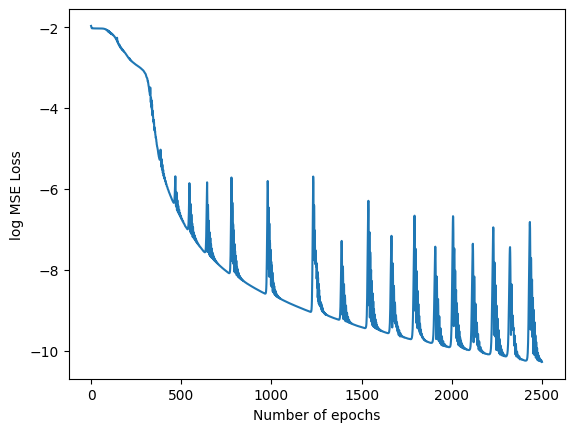

3.437089253566228e-05

In [134]:
supervised_network.train(500)

0 0.0026173689402639866
100 0.0026273801922798157
200 0.003455969039350748
300 0.0025842187460511923
400 0.002570836339145899


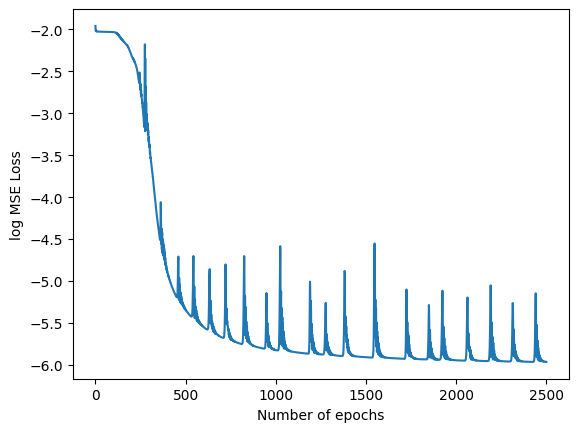

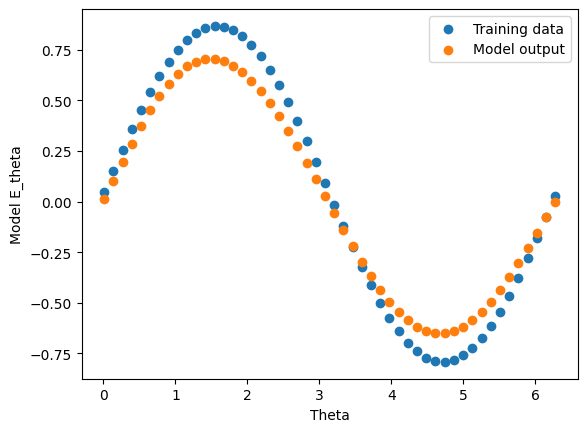

0.0025678640231490135

In [135]:
soft_network.train(500)

0 0.058144886046648026
2 0.04930698871612549
4 0.049423471093177795
6 0.046706099063158035
8 0.046508677303791046


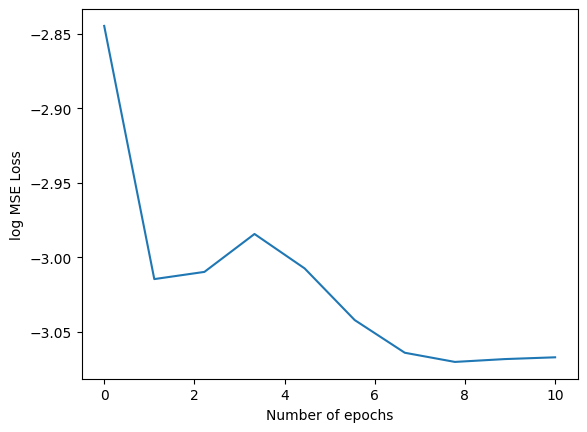

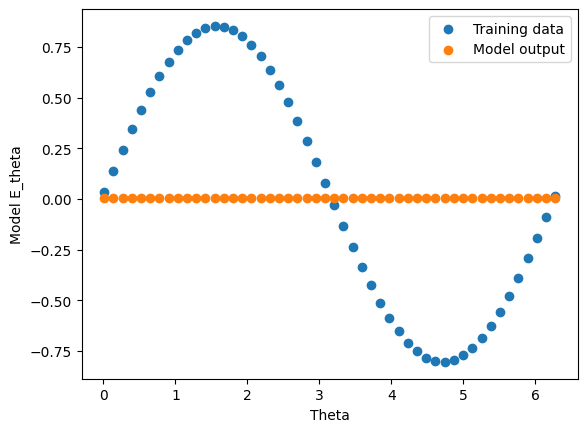

0.04656362533569336

In [168]:
maxwell_network.train(10)

tensor(0.0016, grad_fn=<MseLossBackward0>)


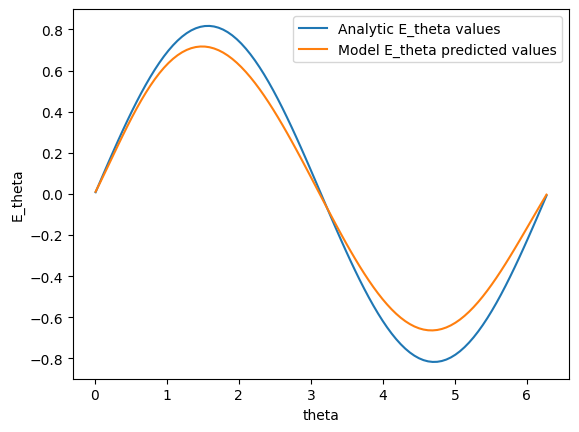

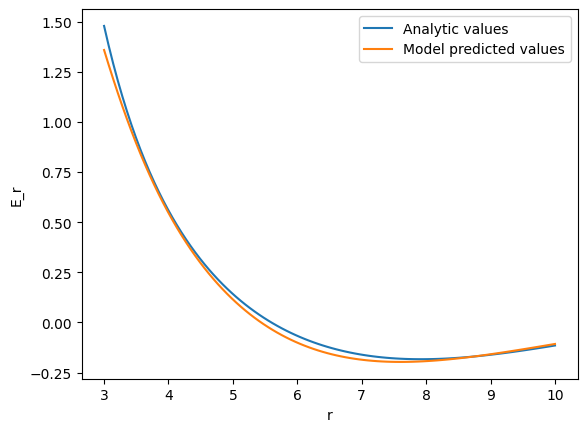

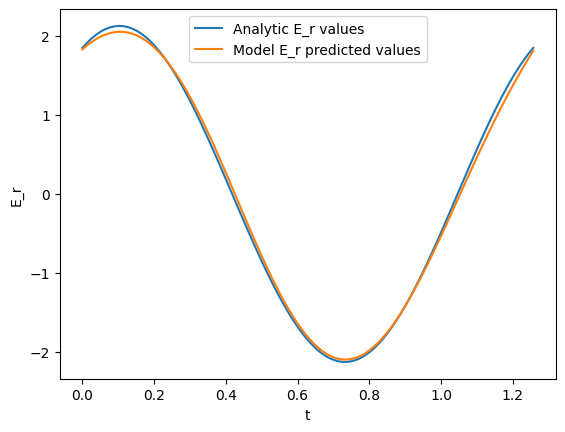

In [137]:
device = torch.device("cpu")

validation_rtheta_t = generate_rtheta_t_tensor(3.0,10.0,2*math.pi/omega,100)
validation_rtheta_t = torch.stack(validation_rtheta_t, dim=-1)
model_E_rtheta = soft_network.model(validation_rtheta_t.to(device))
analytic_E = E_rtheta_field_HD_tensor(validation_rtheta_t[...,0], validation_rtheta_t[...,1], validation_rtheta_t[...,2], p_0, omega, noise=False)

validation_loss = torch.nn.MSELoss()
print(validation_loss(model_E_rtheta, analytic_E))

input_r_numpy = validation_rtheta_t[...,0].cpu().detach().numpy()
input_theta_numpy = validation_rtheta_t[...,1].cpu().detach().numpy()
input_t_numpy = validation_rtheta_t[...,2].cpu().detach().numpy()
model_E_r = model_E_rtheta[...,0].cpu().detach().numpy()
model_E_theta = model_E_rtheta[...,1].cpu().detach().numpy()
analytic_E_r = analytic_E[...,0].cpu().detach().numpy()
analytic_E_theta = analytic_E[...,1].cpu().detach().numpy()

plt.figure('E_theta')
plt.plot(input_theta_numpy[:,1,0], analytic_E_theta[:,1,0], label='Analytic E_theta values')
plt.plot(input_theta_numpy[:,1,0], model_E_theta[:,1,0], label='Model E_theta predicted values')
plt.xlabel('theta')
plt.ylabel('E_theta')
plt.legend()

plt.figure('E_r')
plt.plot(input_r_numpy[10,:,0], analytic_E_r[10,:,0], label='Analytic values')
plt.plot(input_r_numpy[10,:,0], model_E_r[10,:,0], label='Model predicted values')
plt.xlabel('r')
plt.ylabel('E_r')
plt.legend()

plt.figure('Time dependance for E_r')
plt.plot(input_t_numpy[0,0,:], analytic_E_r[0,0,:], label='Analytic E_r values')
plt.plot(input_t_numpy[0,0,:], model_E_r[0,0,:], label='Model E_r predicted values')
plt.xlabel('t')
plt.ylabel('E_r')
plt.legend()

plt.show()

In [27]:
def grid_search_alpha_beta(alpha_min, alpha_max, beta_min, beta_max, grid_size, input_data, train_data, epochs):
    '''Find the alpha beta combination that provides the lowest validation loss after a number of epochs'''

    alphas = np.linspace(alpha_min, alpha_max, grid_size)
    betas = np.linspace(beta_min, beta_max, grid_size)

    validation_E = E_rtheta_field_HD_tensor(input_data[...,0], input_data[...,1], input_data[...,2], p_0, omega, noise=False)

    losses = []
    alpha_beta = []
    
    for alpha in alphas:
        for beta in betas:
            network = supervised_soft_network(input_data, train_data, alpha, beta)
            network.train(epochs);
            model_output = network.model(input_data)
            MSE_loss_func = torch.nn.MSELoss()
            validation_loss = MSE_loss_func(model_output, validation_E)
            losses.append(validation_loss.item())
            alpha_beta.append((alpha, beta))
    
    min_loss_arg = losses.index(min(losses))

    return alpha_beta[min_loss_arg], min(losses)

0 0.05942675843834877
40 0.013200950808823109
80 0.013116266578435898
120 0.013105923309922218
160 0.013088441453874111


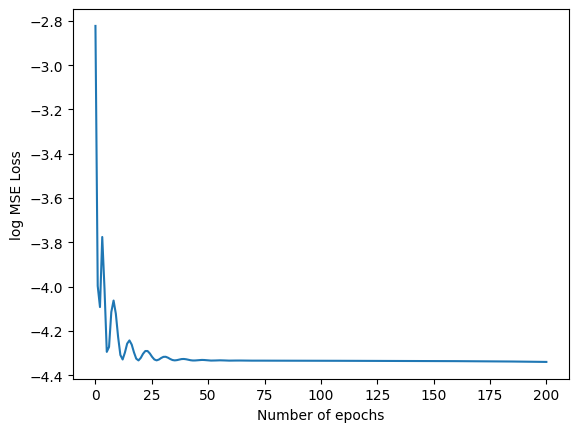

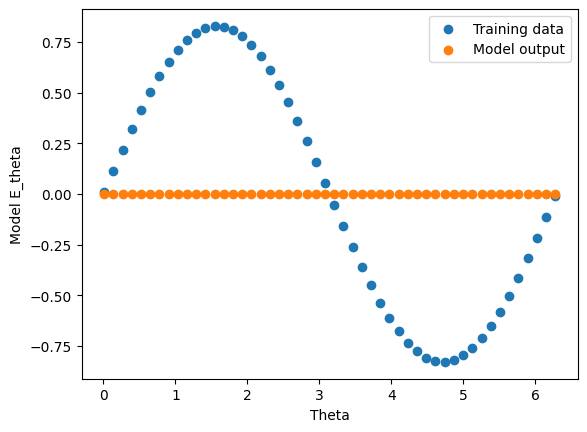

0 0.02761254832148552
40 0.013161754235625267
80 0.013114366680383682
120 0.013100579380989075
160 0.013081325218081474


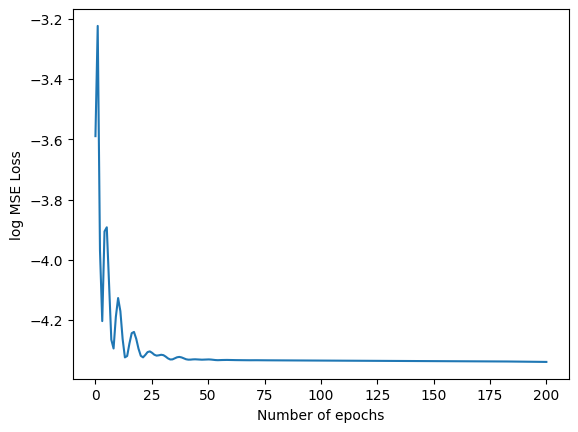

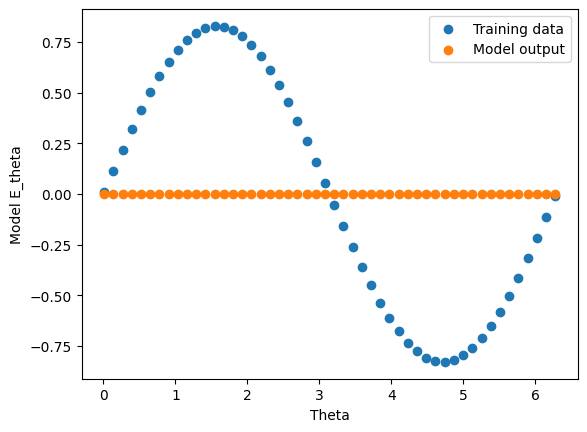

0 0.029276855289936066
40 0.013149655424058437
80 0.013105660676956177
120 0.013081677258014679
160 0.01304537896066904


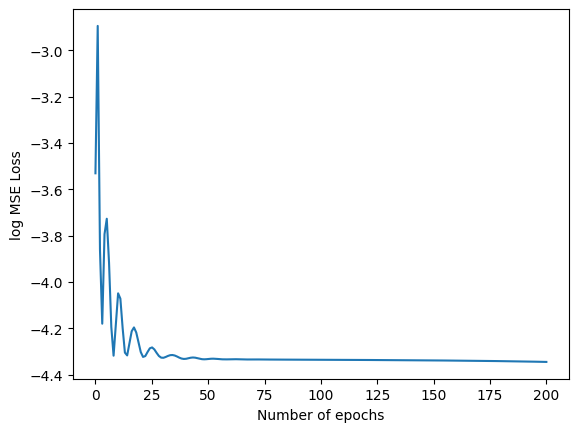

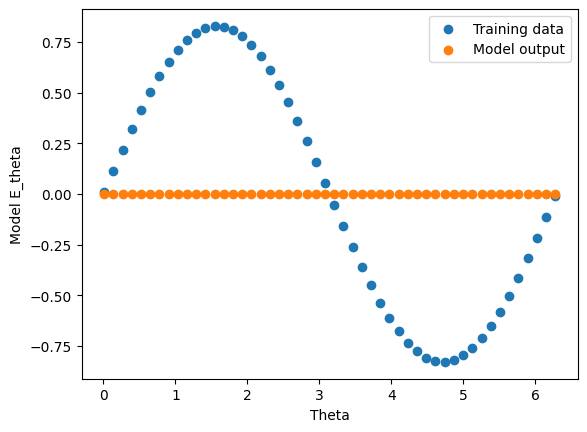

0 0.0330195277929306
40 0.013171232305467129
80 0.013120927847921848
120 0.013111966662108898
160 0.013100340962409973


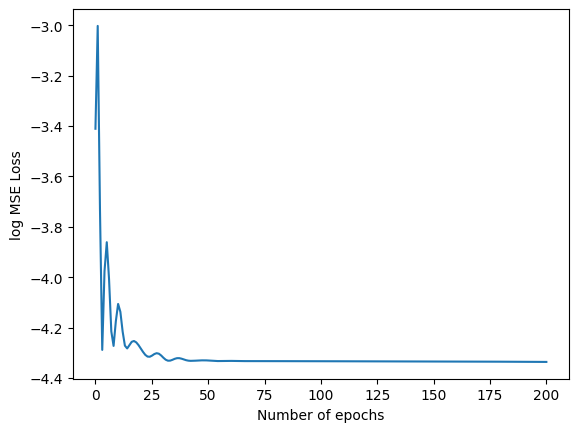

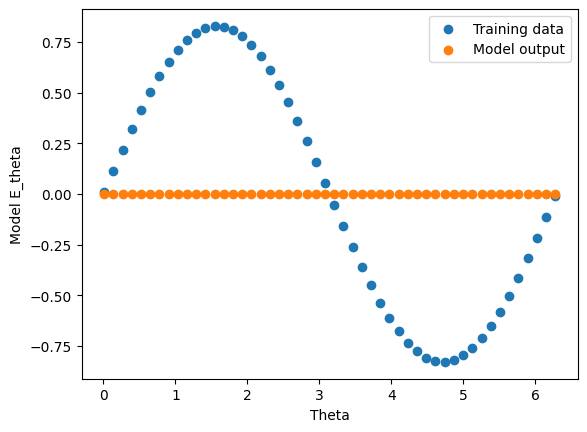

0 0.015315421856939793
40 0.013295884244143963
80 0.013125583529472351
120 0.013115216046571732
160 0.013108568266034126


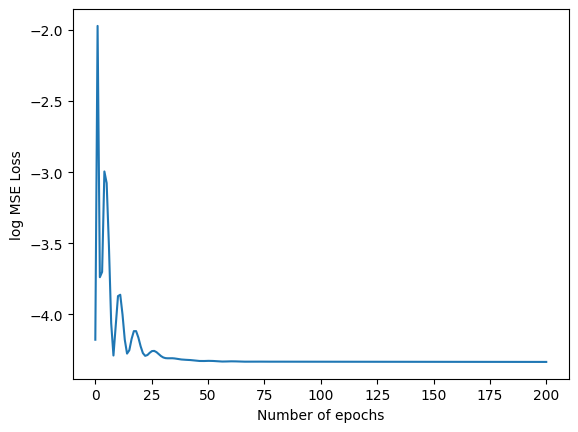

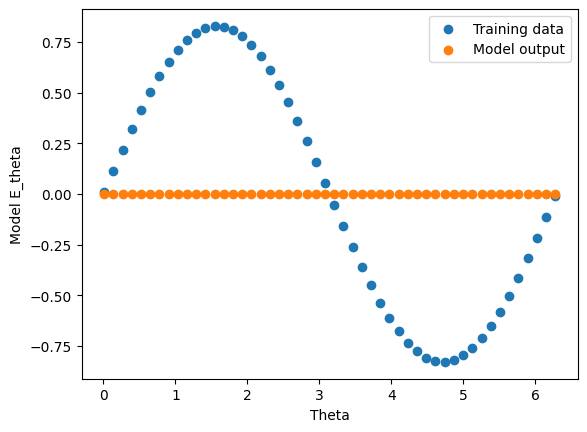

0 0.0484297089278698
40 0.013220016844570637
80 0.01312609575688839
120 0.01311823446303606
160 0.01311327051371336


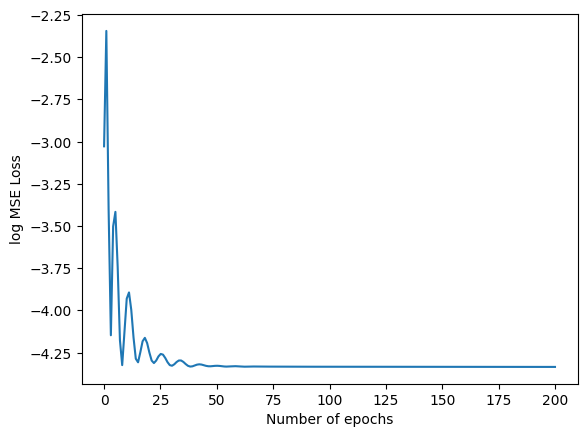

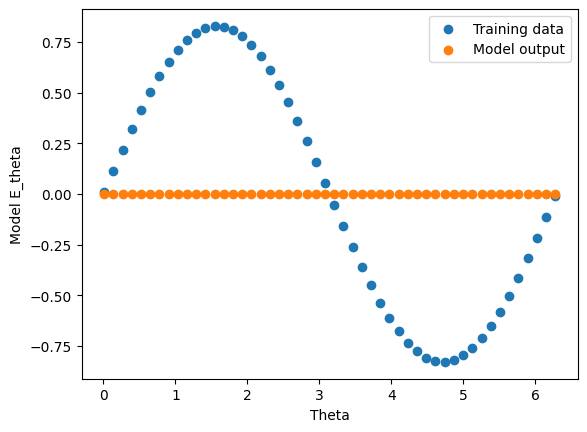

0 0.21256887912750244
40 0.013190655037760735
80 0.013146752491593361
120 0.013130408711731434
160 0.01312468945980072


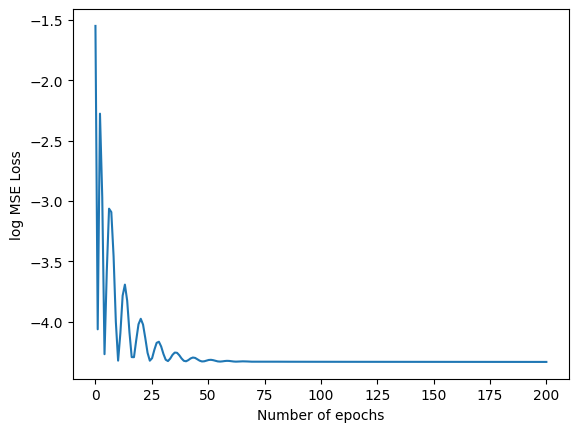

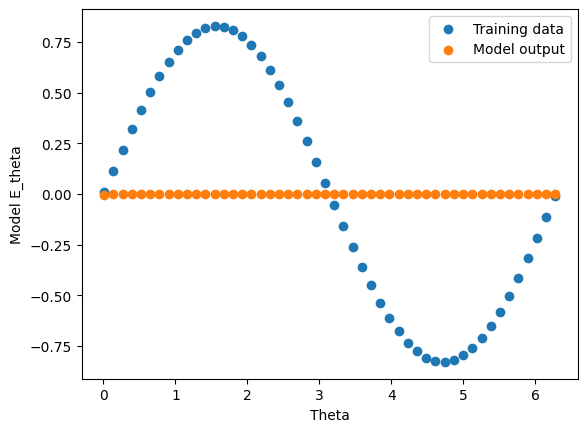

0 0.052517369389534
40 0.013180414214730263
80 0.0131269795820117
120 0.013120858930051327
160 0.01311703585088253


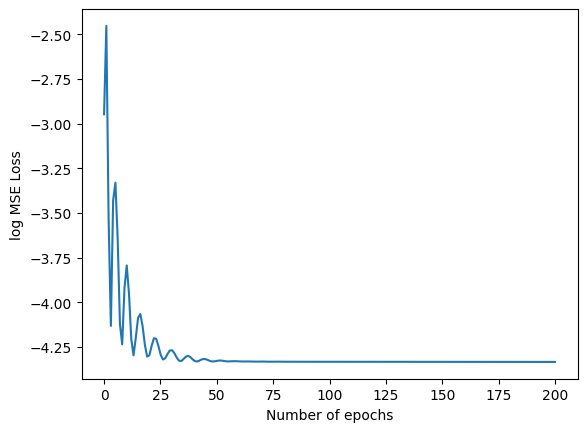

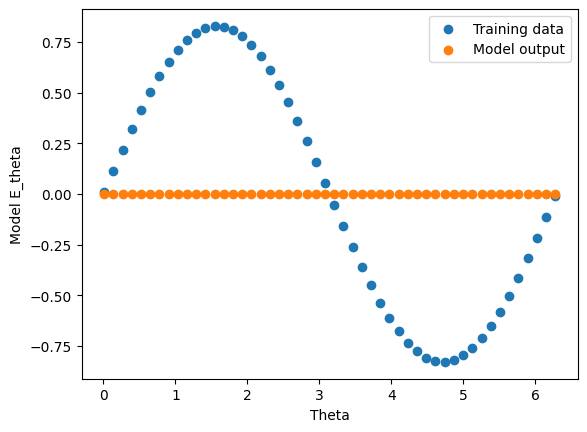

0 0.19374917447566986
40 0.013271135278046131
80 0.013121487572789192
120 0.013111372478306293
160 0.013104960322380066


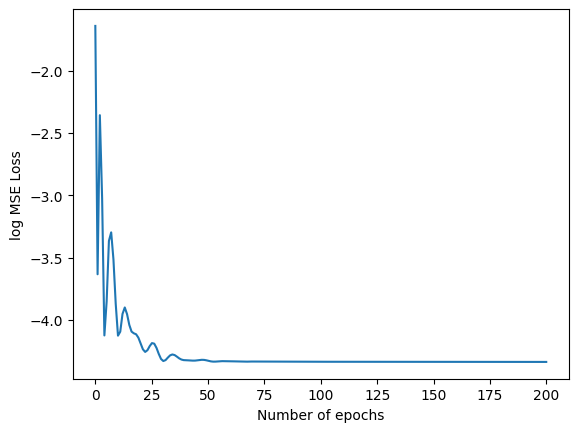

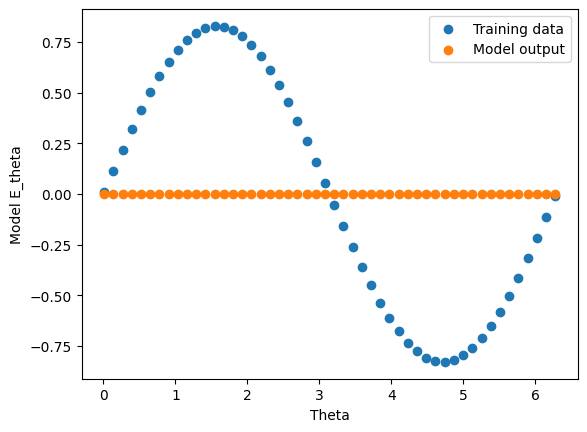

0 0.18303734064102173
40 0.013318460434675217
80 0.013126814737915993
120 0.013120968826115131
160 0.013117946684360504


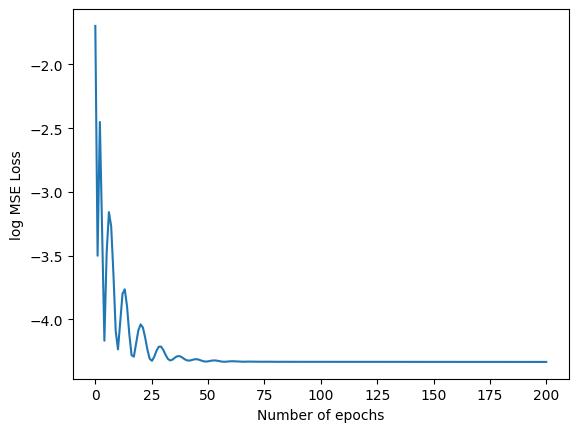

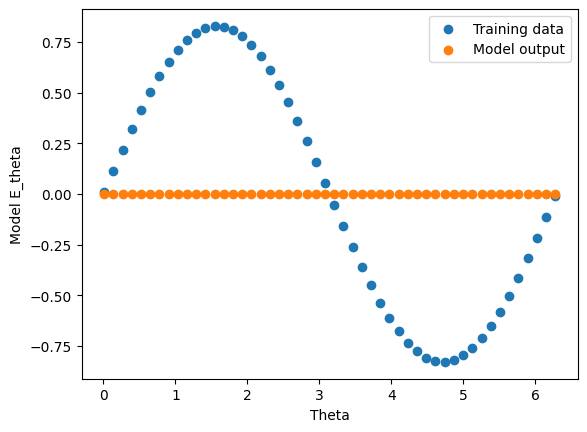

0 0.03152993321418762
40 0.026183677837252617
80 0.025640882551670074
120 0.02510054223239422
160 0.024425115436315536


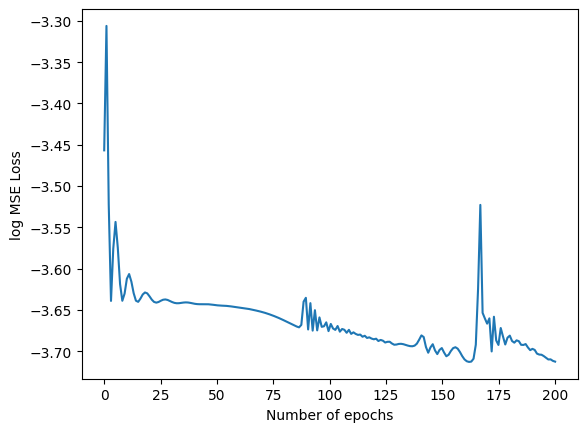

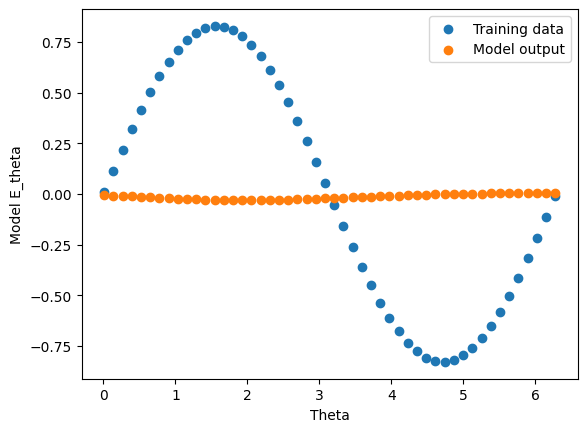

0 0.06873655319213867
40 0.026344621554017067
80 0.02619963511824608
120 0.026153994724154472
160 0.0260323416441679


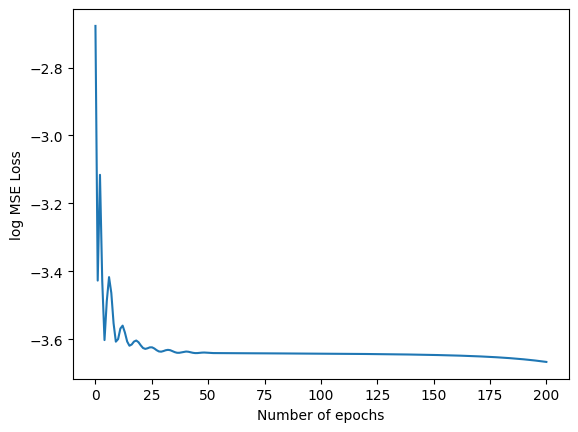

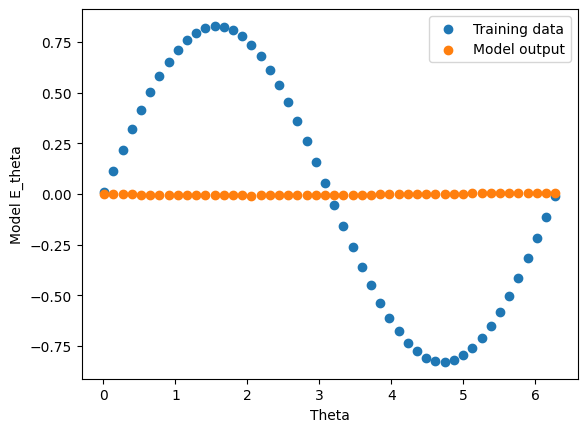

0 0.031631700694561005
40 0.026346338912844658
80 0.02619107812643051
120 0.02614131197333336
160 0.026025982573628426


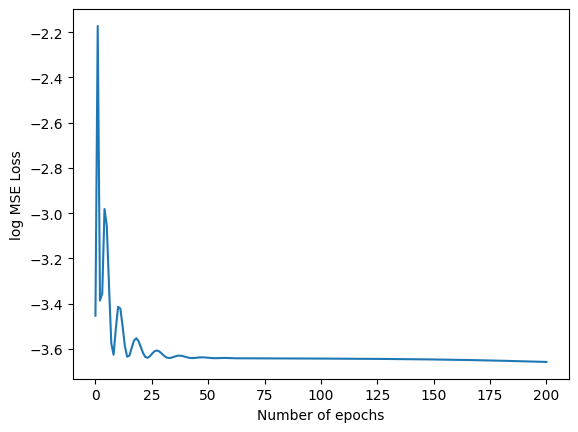

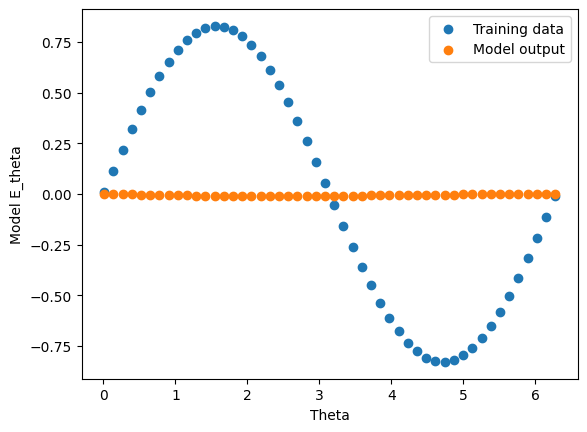

0 0.053577810525894165
40 0.026286864653229713
80 0.026192503049969673
120 0.02609139494597912
160 0.025754623115062714


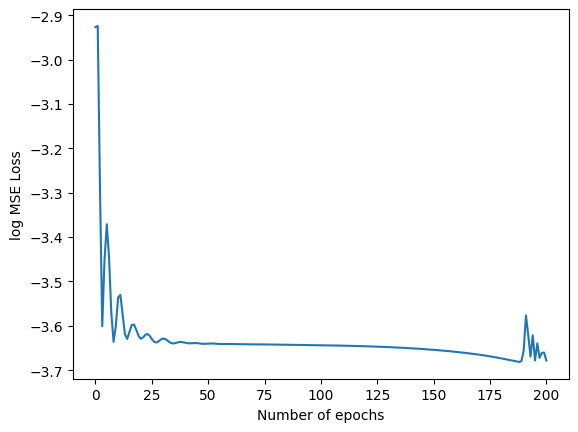

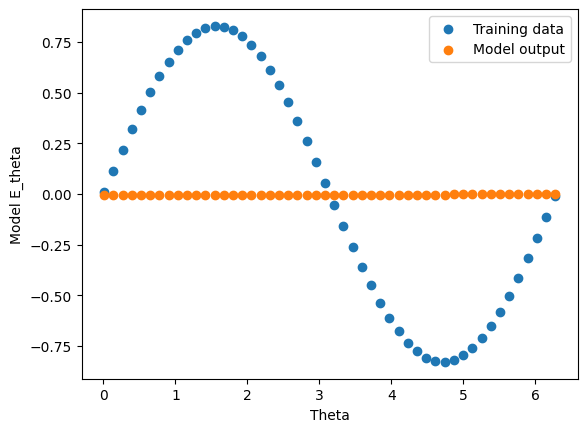

0 0.02967848628759384
40 0.02624504826962948
80 0.026223963126540184
120 0.026208097115159035
160 0.02618636004626751


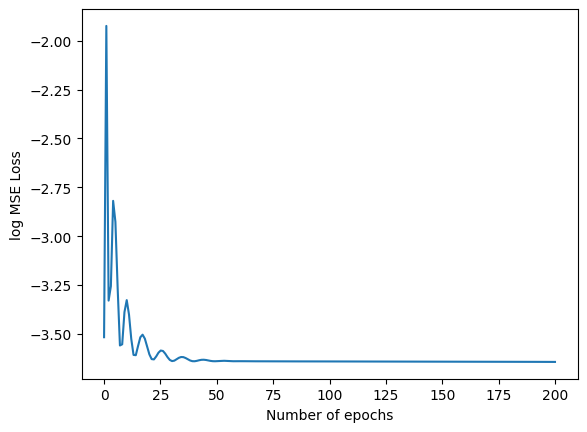

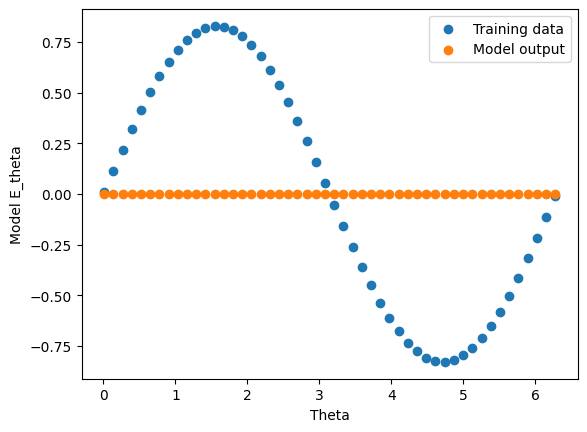

0 0.05131726711988449
40 0.026379482820630074
80 0.02624298632144928
120 0.026225628331303596
160 0.026212090626358986


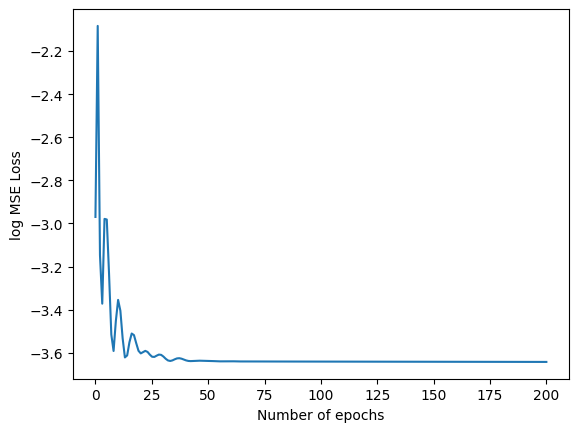

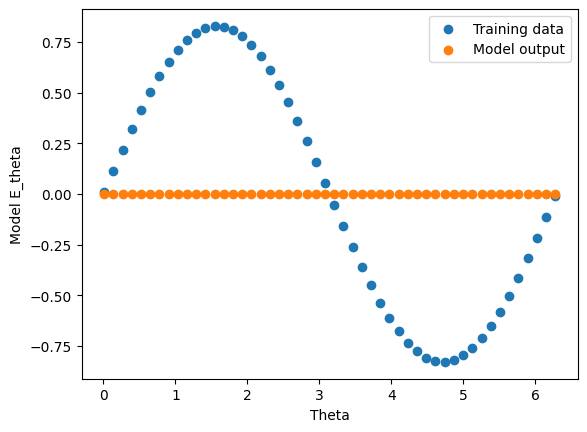

0 0.35662540793418884
40 0.026461003348231316
80 0.026239005848765373
120 0.026212293654680252
160 0.026192329823970795


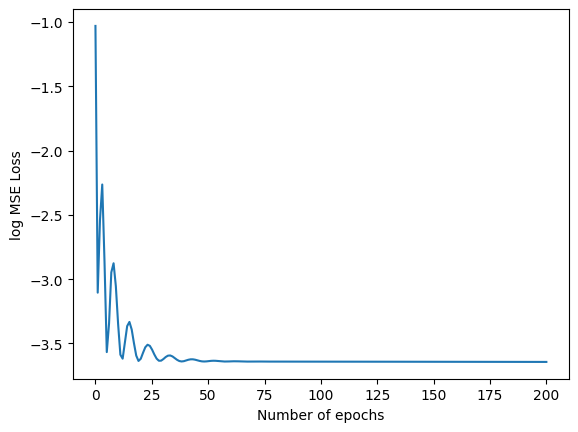

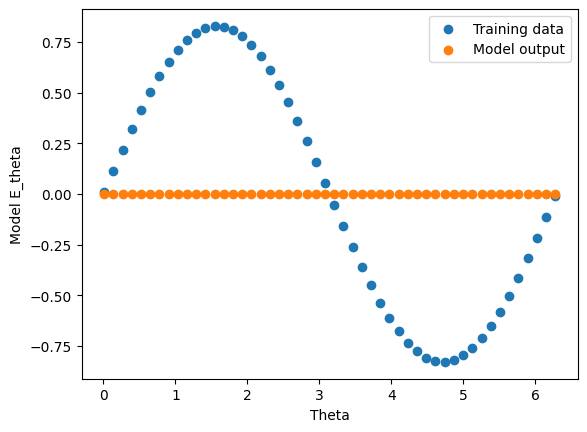

0 0.0987410694360733
40 0.026391807943582535
80 0.026213165372610092
120 0.026180725544691086
160 0.026128150522708893


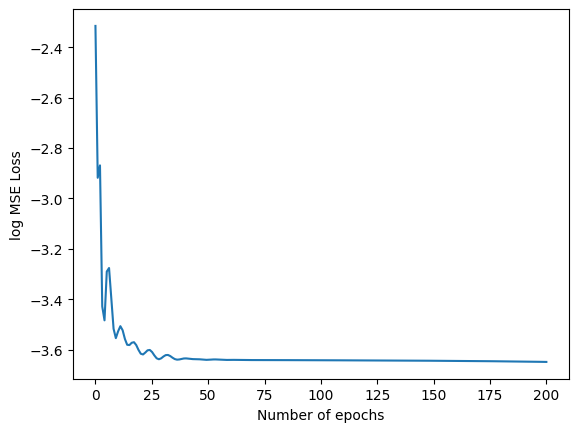

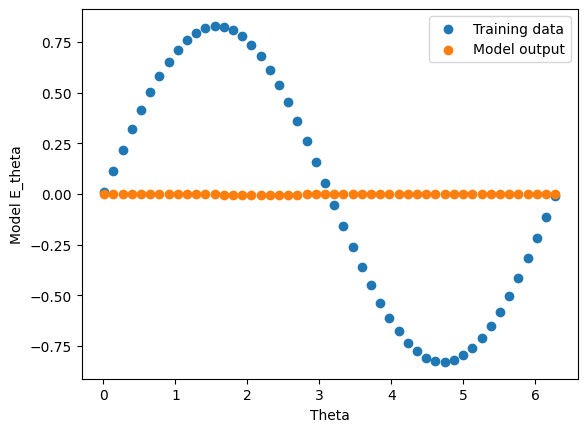

0 0.14901277422904968
40 0.02644863910973072
80 0.02624569833278656
120 0.02623041905462742
160 0.026219742372632027


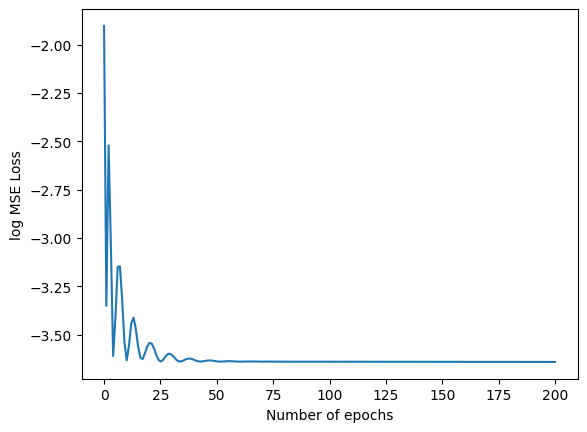

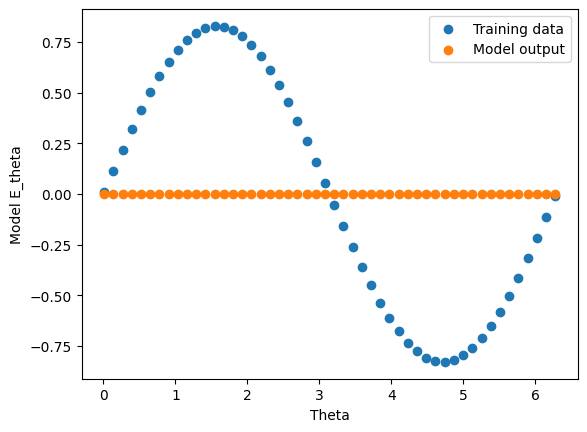

0 0.06624312698841095
40 0.026385068893432617
80 0.026241056621074677
120 0.02623158134520054
160 0.02622354030609131


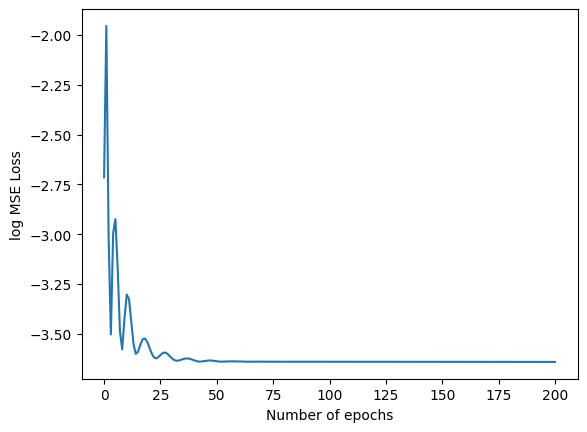

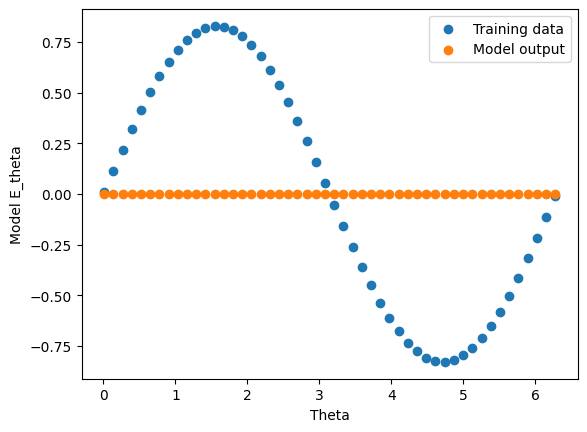

0 0.04856540262699127
40 0.039343781769275665
80 0.03920929878950119
120 0.038404371589422226
160 0.037293631583452225


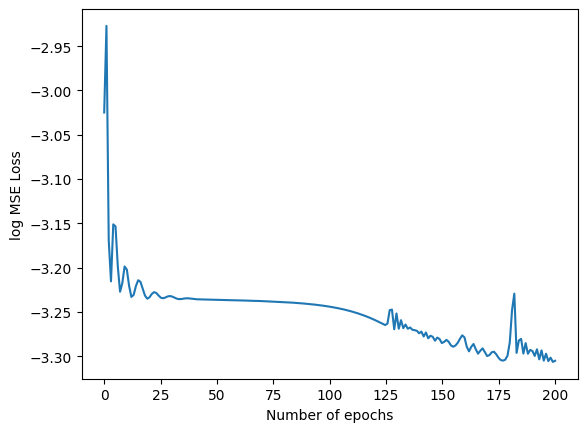

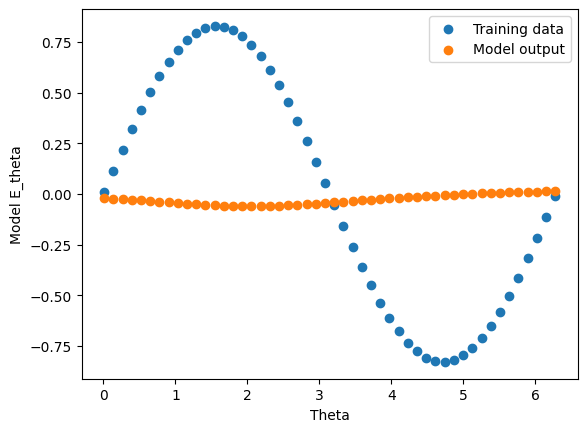

0 0.04494812339544296
40 0.039294127374887466
80 0.03891441226005554
120 0.03760484233498573
160 0.036765627562999725


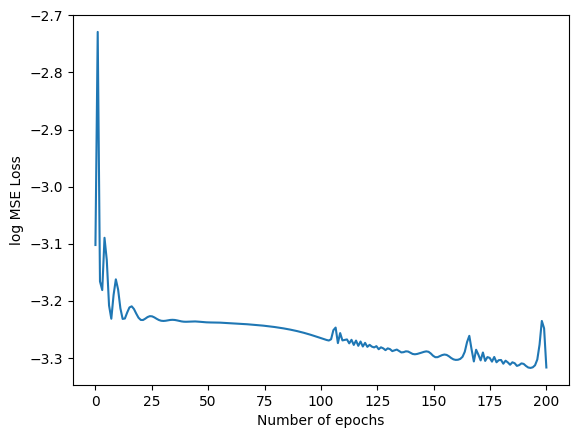

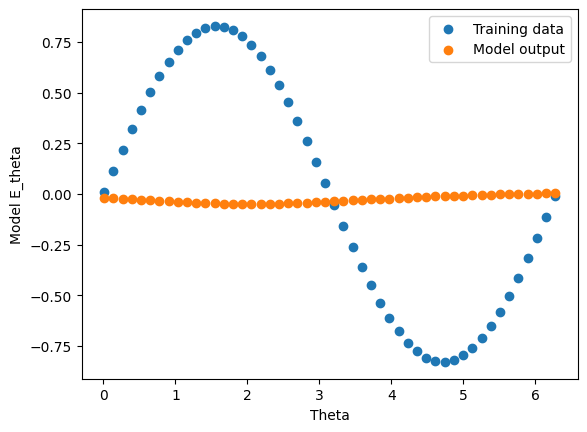

0 0.06907567381858826
40 0.03936847671866417
80 0.03915867954492569
120 0.038658127188682556
160 0.03793121874332428


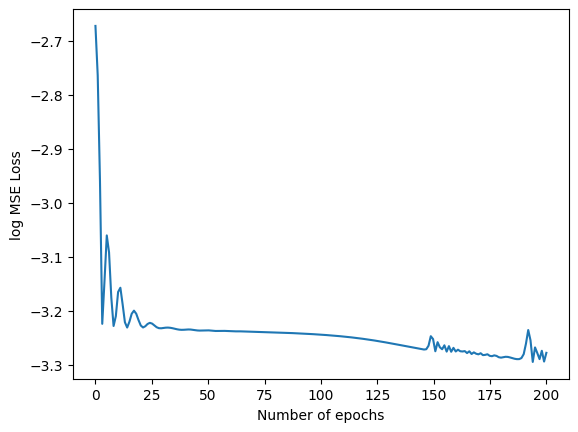

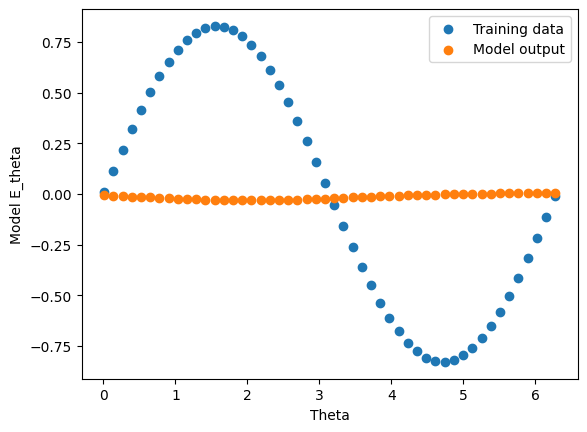

0 0.16371643543243408
40 0.03937424346804619
80 0.03934475779533386
120 0.03931987285614014
160 0.039291441440582275


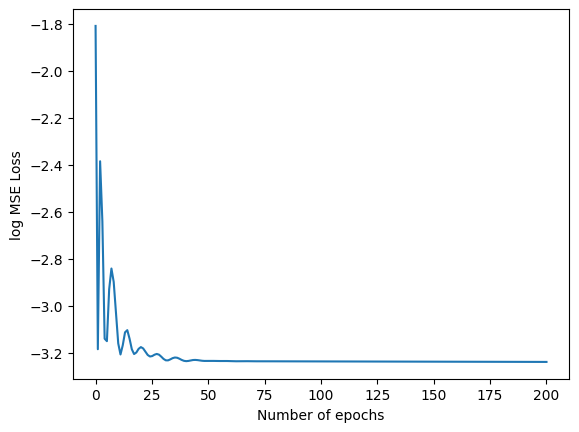

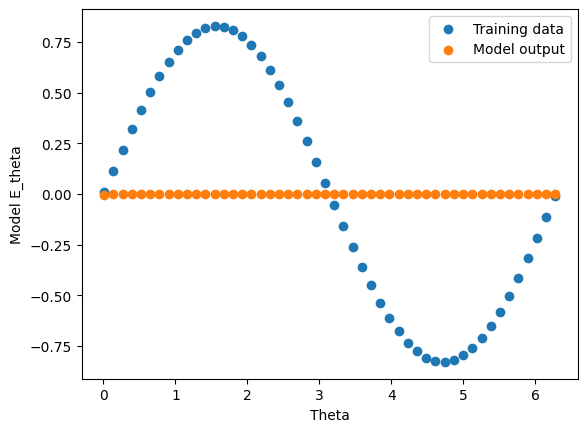

0 0.08658058941364288
40 0.03949768468737602
80 0.03921130299568176
120 0.03895781561732292
160 0.03824750334024429


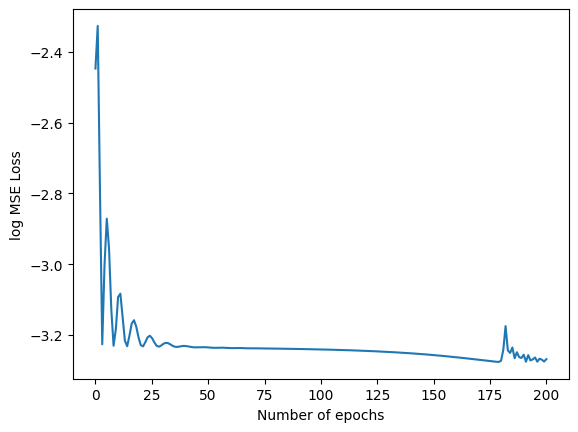

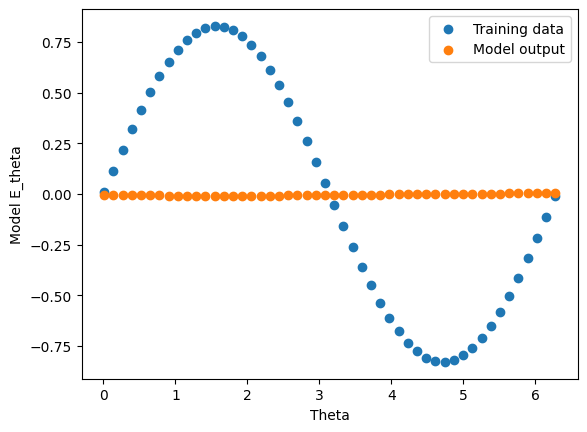

0 0.4292809069156647
40 0.0403127558529377
80 0.039385147392749786
120 0.03935310244560242
160 0.03933634236454964


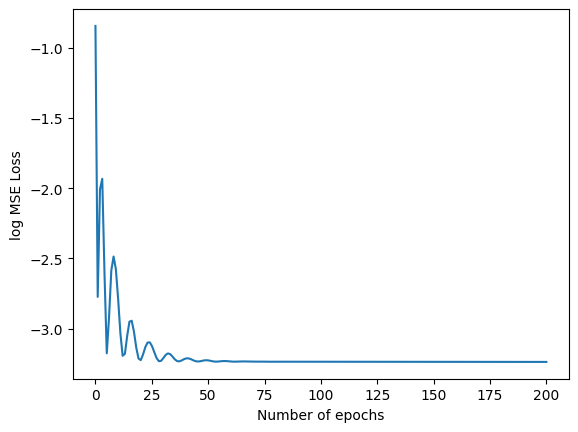

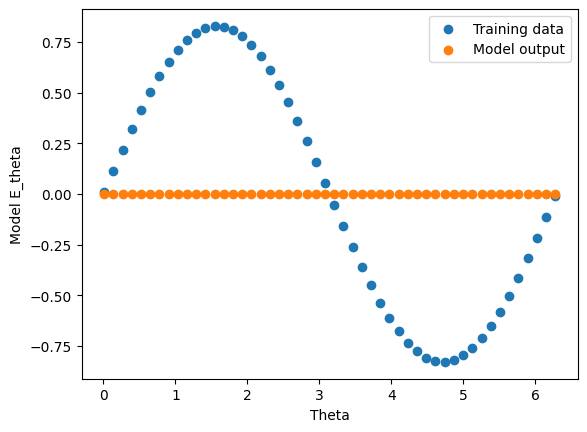

0 0.13121181726455688
40 0.03960152715444565
80 0.03930322080850601
120 0.039201151579618454
160 0.038977134972810745


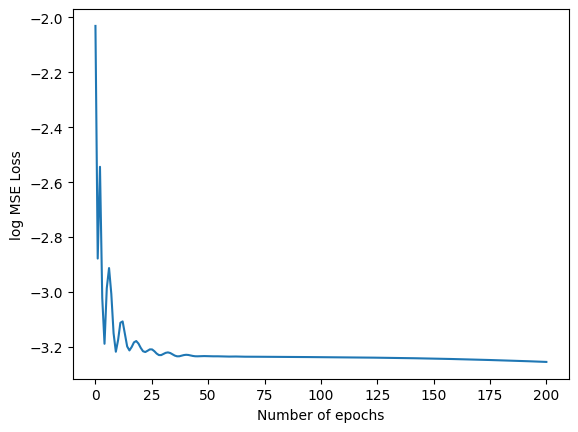

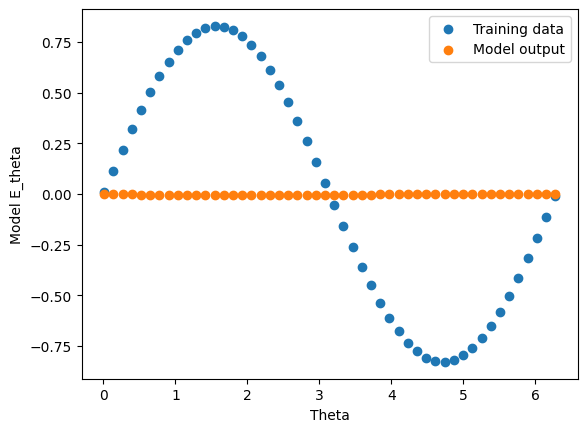

0 0.04970337450504303
40 0.03976063430309296
80 0.03937855735421181
120 0.03935583680868149
160 0.03933773934841156


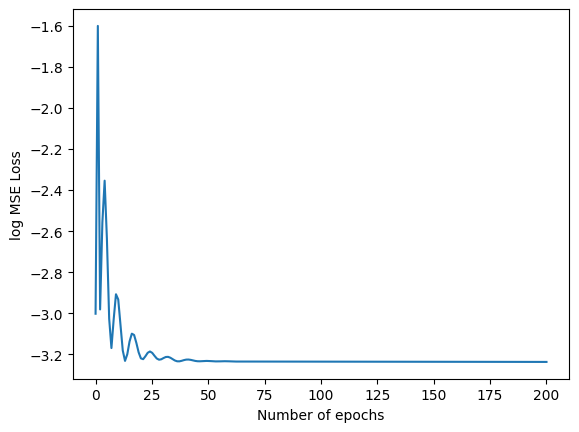

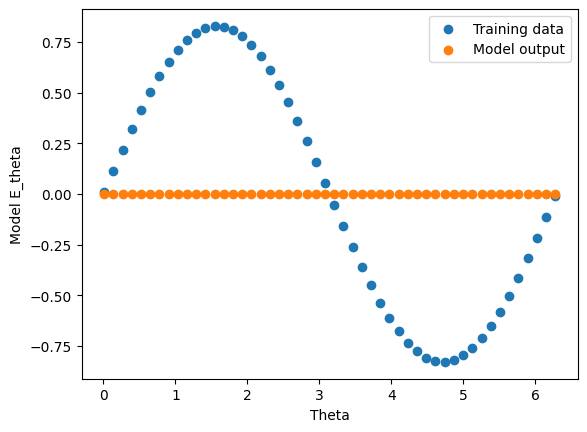

0 0.17106714844703674
40 0.039550017565488815
80 0.039343588054180145
120 0.03930133953690529
160 0.039247989654541016


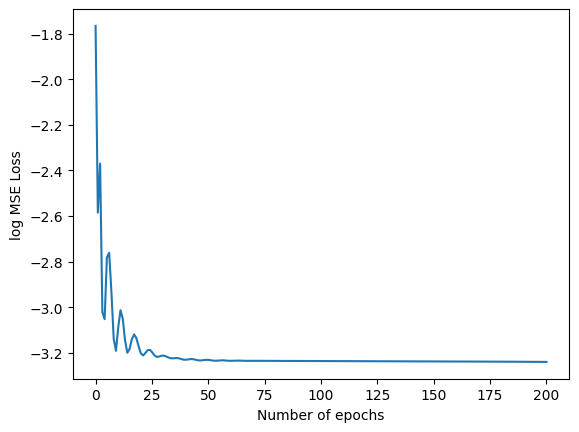

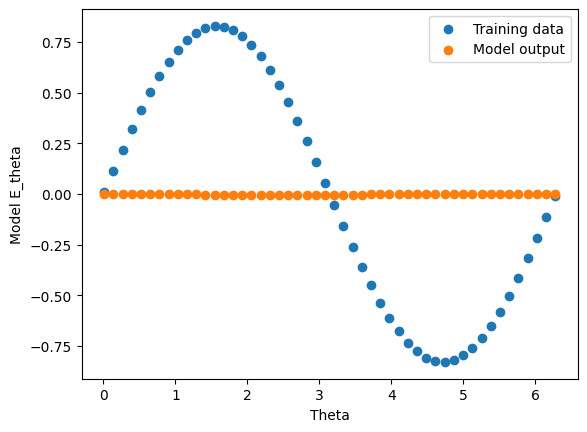

0 0.2630458474159241
40 0.0396156944334507
80 0.039364829659461975
120 0.039348065853118896
160 0.03933339565992355


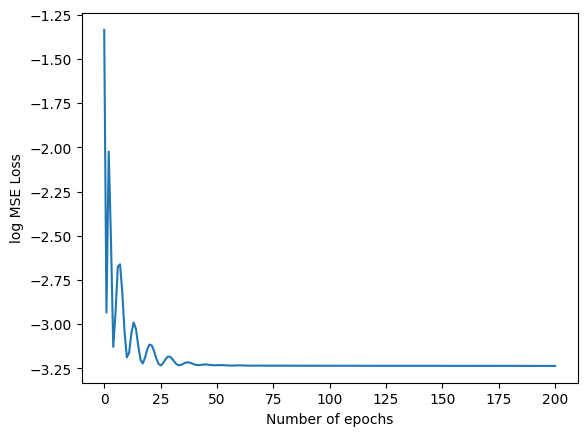

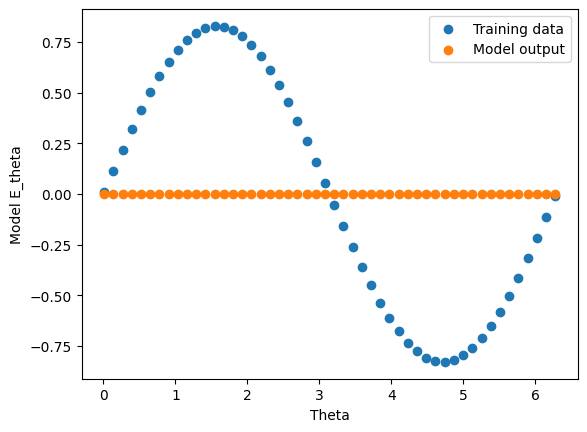

0 0.058164507150650024
40 0.052447617053985596
80 0.05225823447108269
120 0.05098865553736687
160 0.049913305789232254


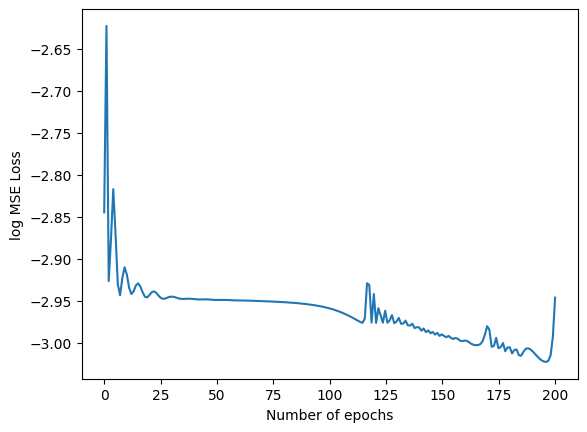

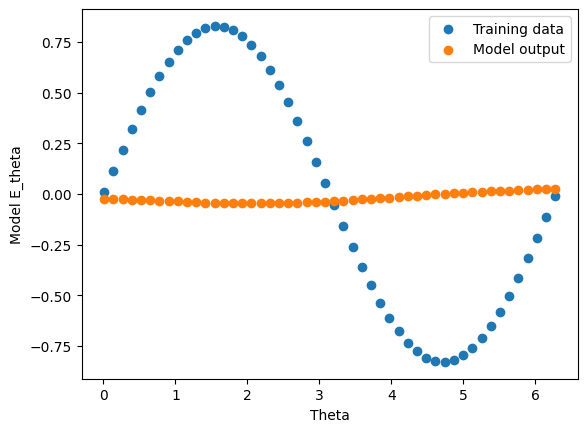

0 0.05699761211872101
40 0.05249566212296486
80 0.052362147718667984
120 0.052060164511203766
160 0.05113258212804794


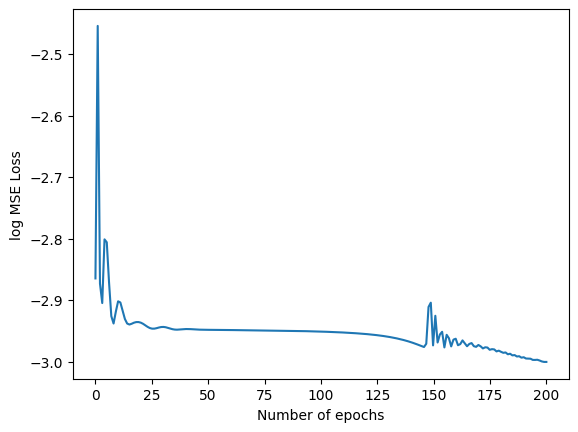

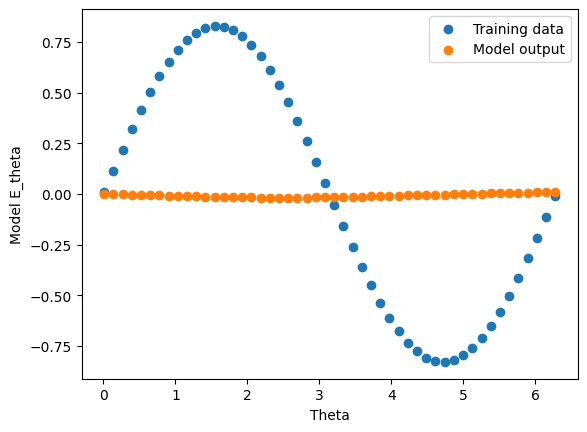

0 0.07050111144781113
40 0.052465904504060745
80 0.05237670615315437
120 0.05204209312796593
160 0.05200532078742981


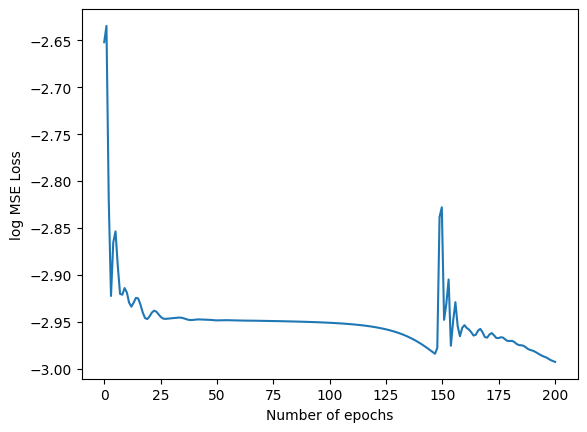

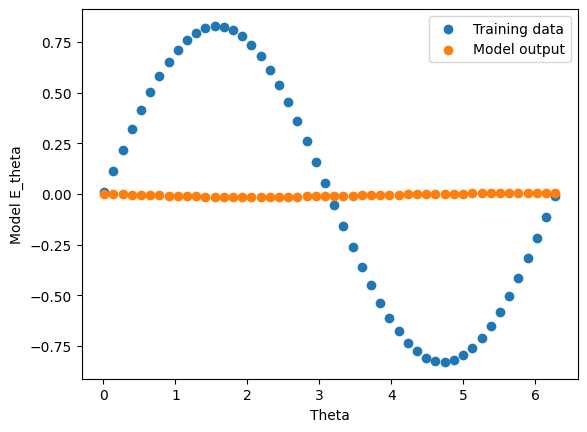

0 0.1623857021331787
40 0.05247720330953598
80 0.05243995040655136
120 0.05239199101924896
160 0.052305690944194794


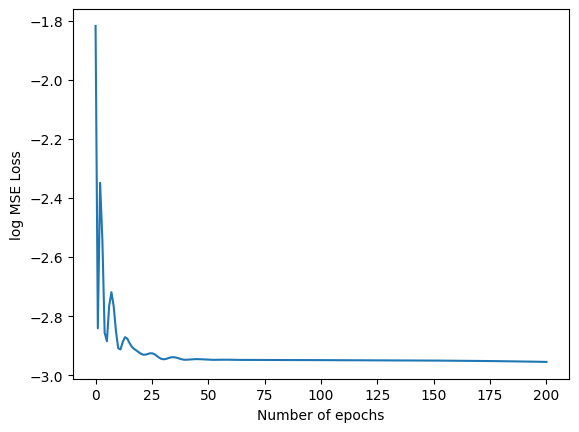

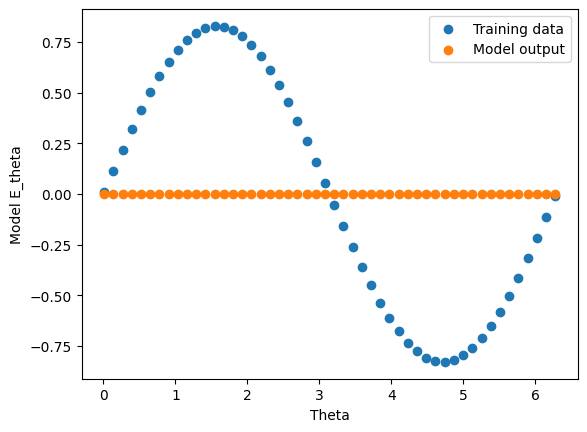

0 0.10309698432683945
40 0.052572499960660934
80 0.05233750864863396
120 0.052111100405454636
160 0.051349859684705734


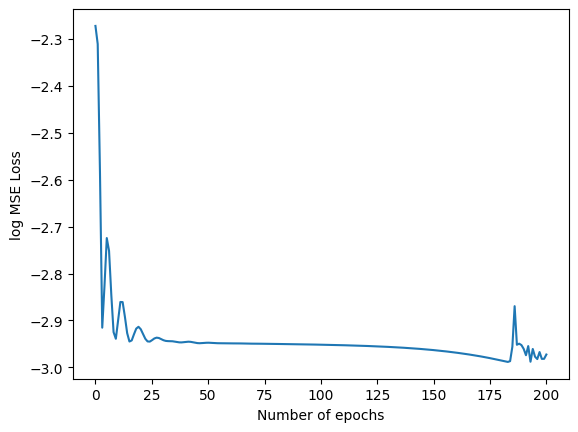

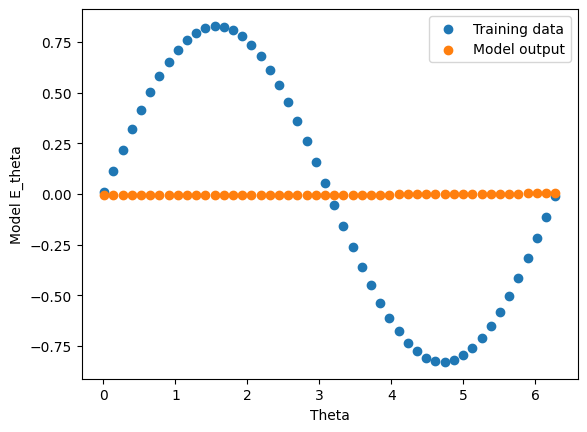

0 0.1150733083486557
40 0.05264176055788994
80 0.05239279568195343
120 0.052253372967243195
160 0.051736023277044296


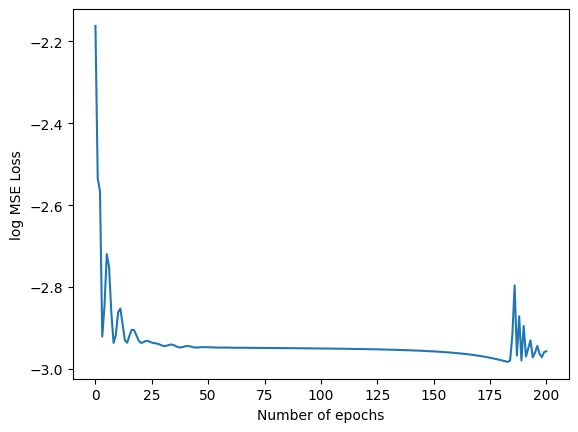

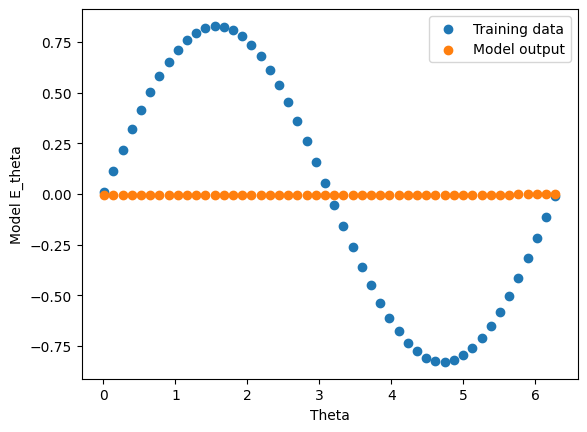

0 0.07128089666366577
40 0.052617184817790985
80 0.05234069004654884
120 0.05202733725309372
160 0.05119306594133377


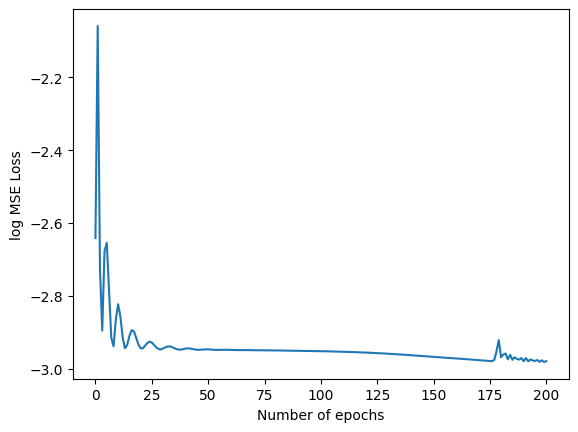

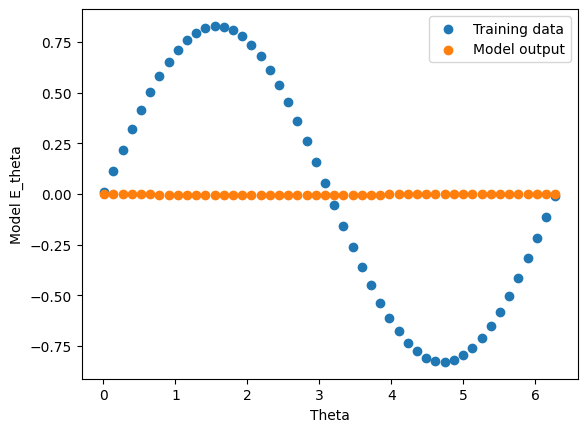

0 0.11341448873281479
40 0.05291805416345596
80 0.0524413101375103
120 0.05240722373127937
160 0.05235918238759041


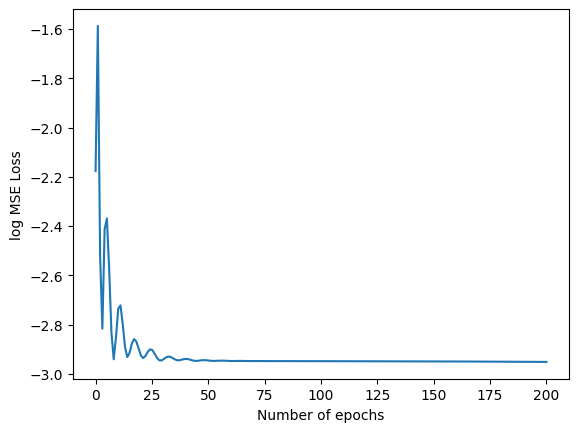

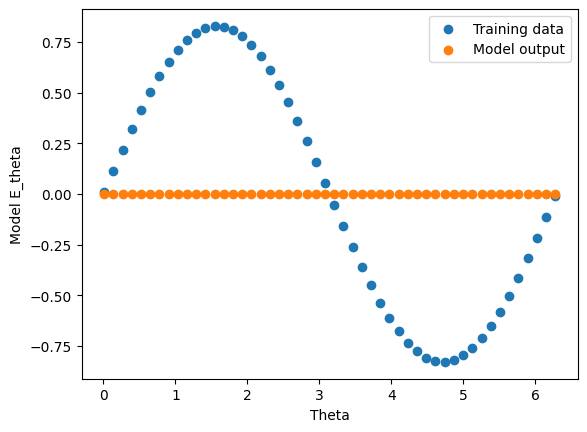

0 0.06310570985078812
40 0.05260341241955757
80 0.05245203152298927
120 0.05241891369223595
160 0.052376288920640945


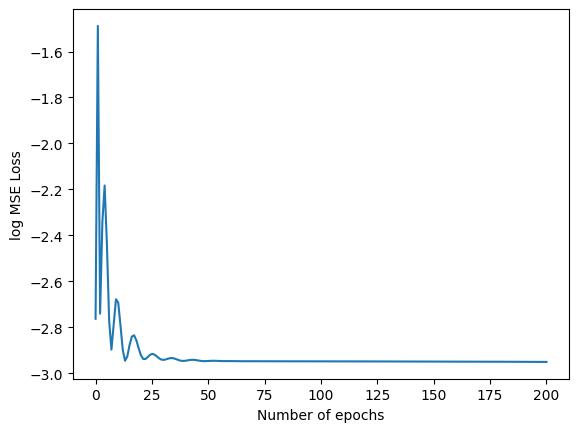

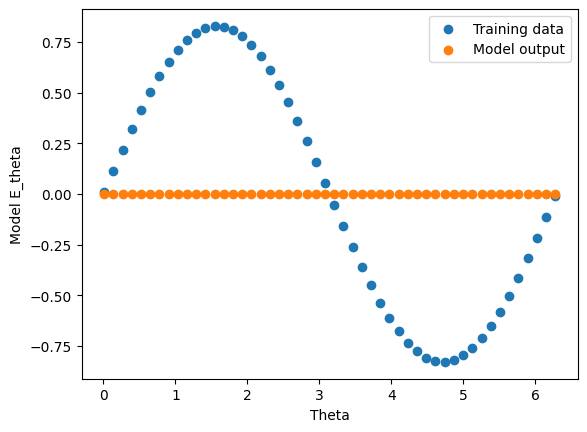

0 0.153899684548378
40 0.052498891949653625
80 0.052431683987379074
120 0.052376363426446915
160 0.052285272628068924


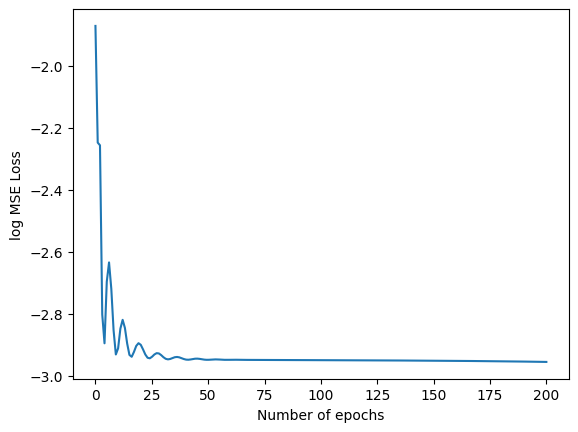

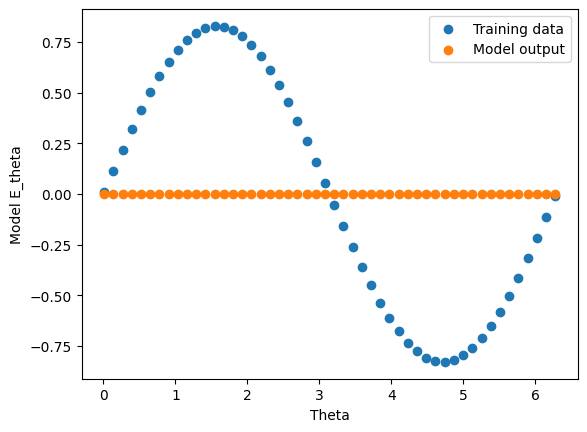

0 0.08447041362524033
40 0.06556655466556549
80 0.06522990018129349
120 0.06291330605745316
160 0.060500919818878174


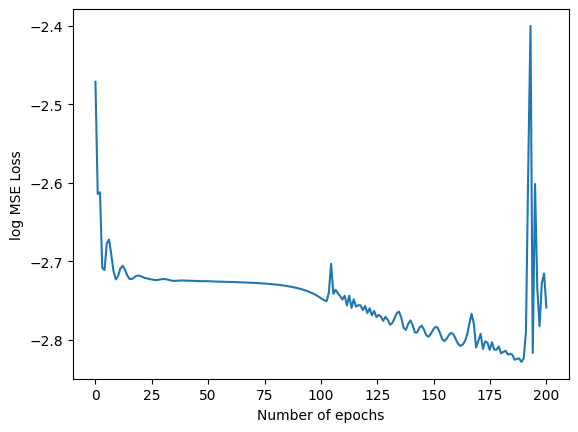

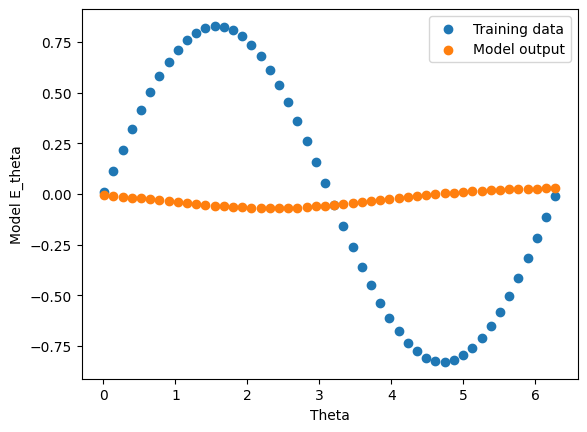

0 0.07682312279939651
40 0.06539648771286011
80 0.06423322856426239
120 0.06265845894813538
160 0.060460664331912994


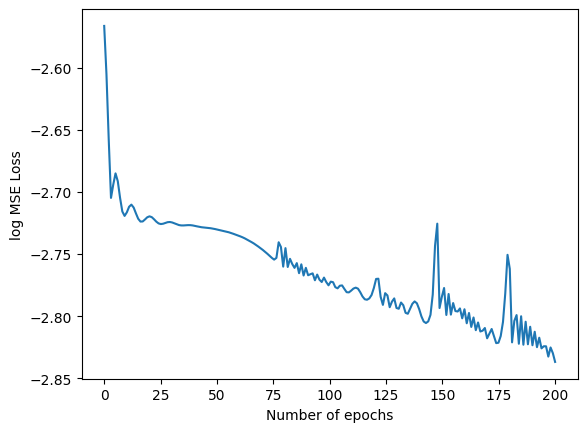

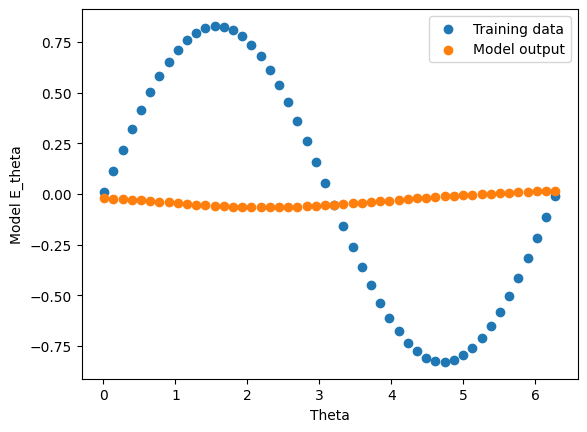

0 0.11423135548830032
40 0.06560403853654861
80 0.06531628966331482
120 0.06383848190307617
160 0.06166611984372139


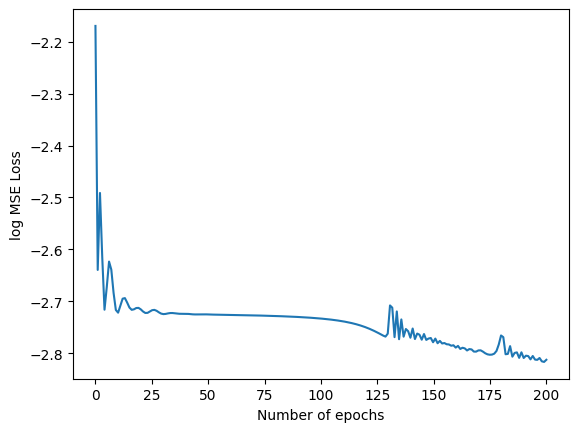

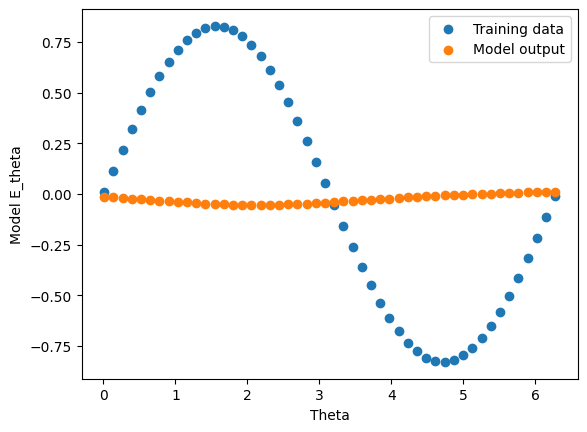

0 0.09702817350625992
40 0.06557842344045639
80 0.06540171802043915
120 0.0646238625049591
160 0.0633237436413765


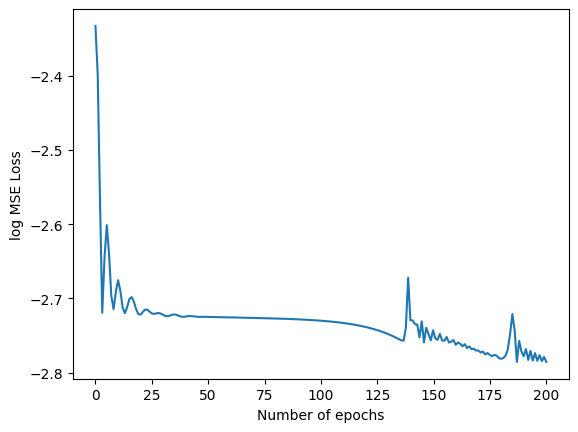

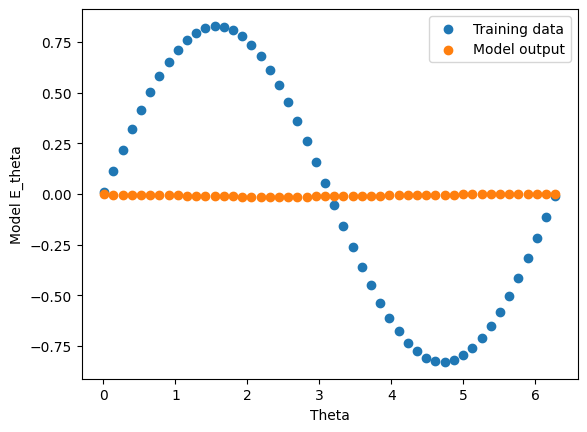

0 0.22177784144878387
40 0.06597210466861725
80 0.06553936004638672
120 0.06545765697956085
160 0.06528513133525848


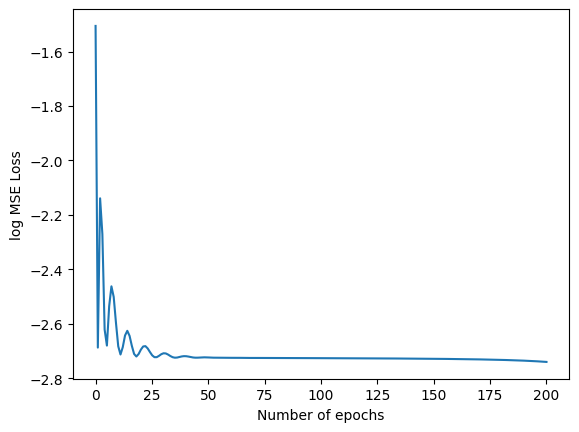

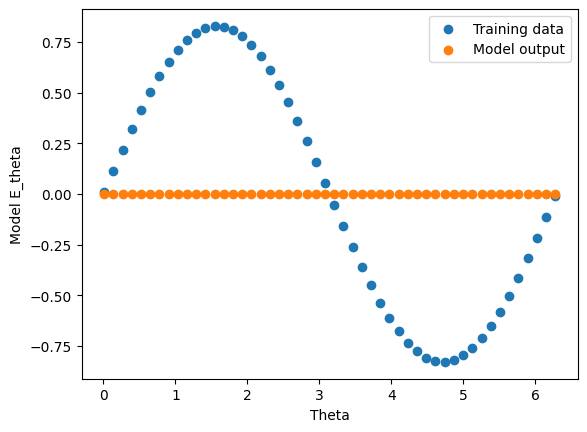

0 0.10518619418144226
40 0.0657227635383606
80 0.06547891348600388
120 0.06524831056594849
160 0.06449044495820999


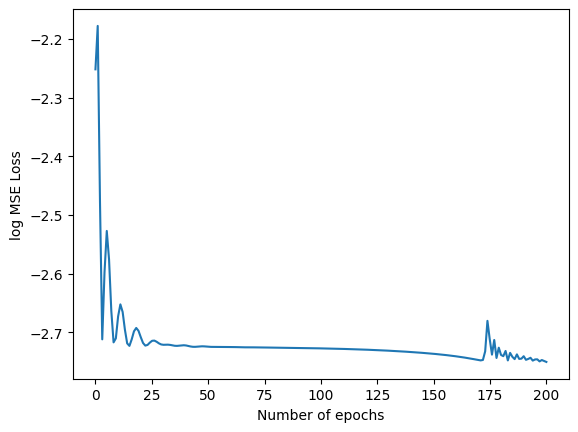

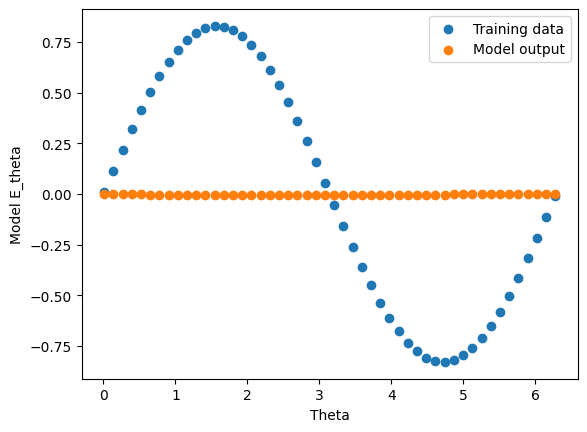

0 0.08519772440195084
40 0.06562641263008118
80 0.06547658145427704
120 0.06517662107944489
160 0.06328483670949936


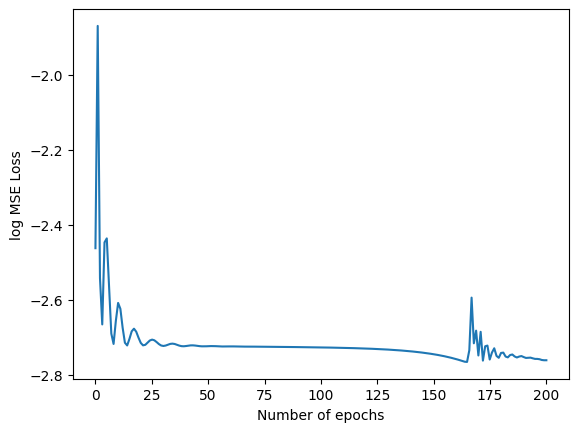

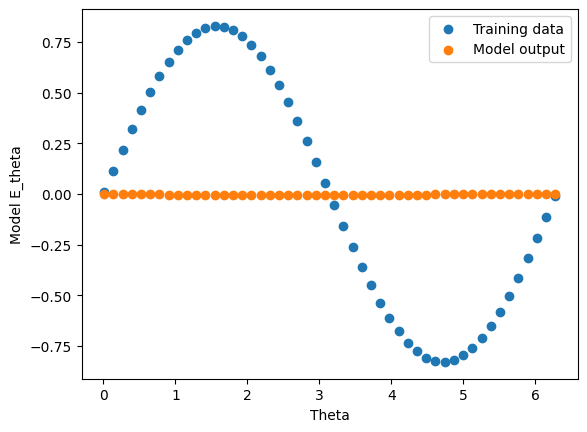

0 0.0769418329000473
40 0.06562072038650513
80 0.06555662304162979
120 0.06550584733486176
160 0.06539572030305862


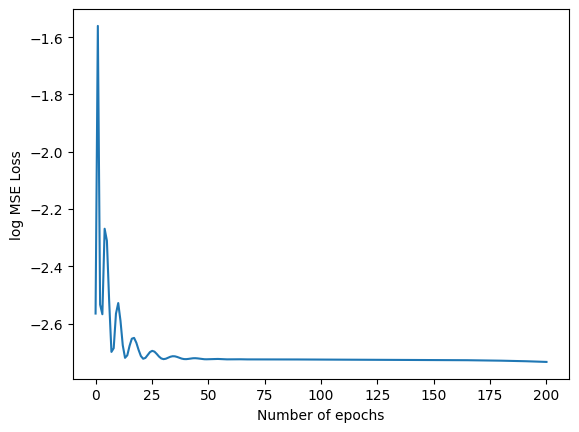

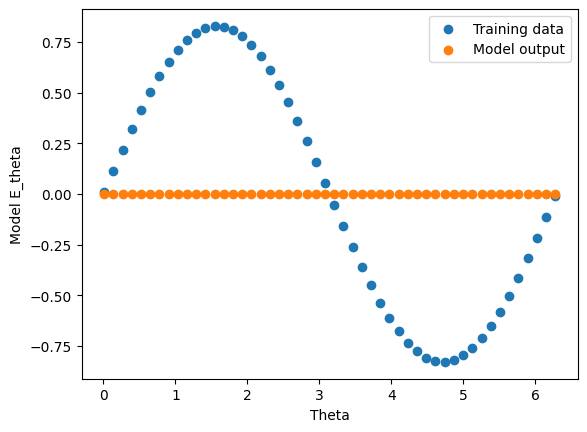

0 0.09959094226360321
40 0.06584752351045609
80 0.06544934213161469
120 0.06516074389219284
160 0.06445226818323135


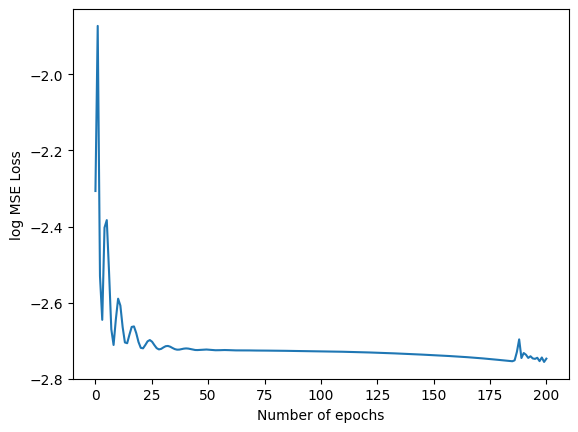

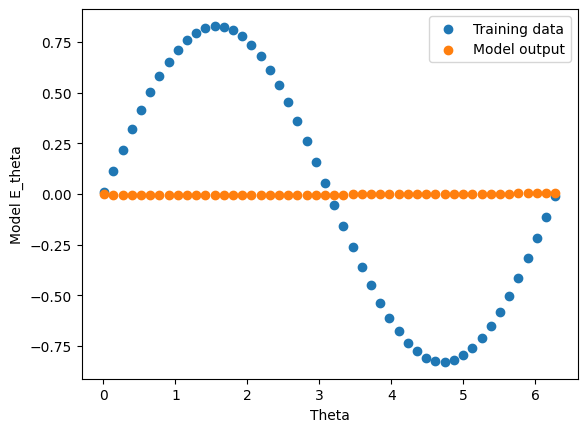

0 0.17217831313610077
40 0.06571650505065918
80 0.06551092863082886
120 0.06539574265480042
160 0.06514360755681992


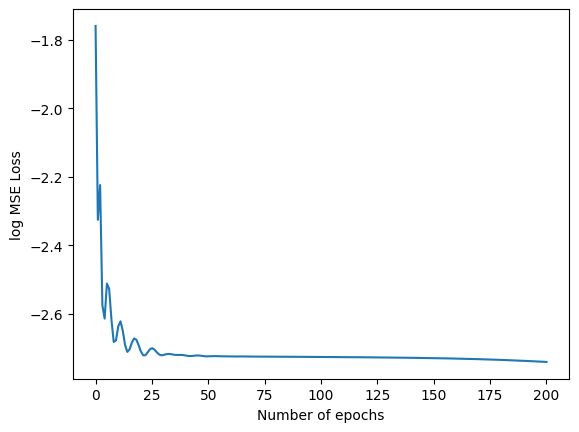

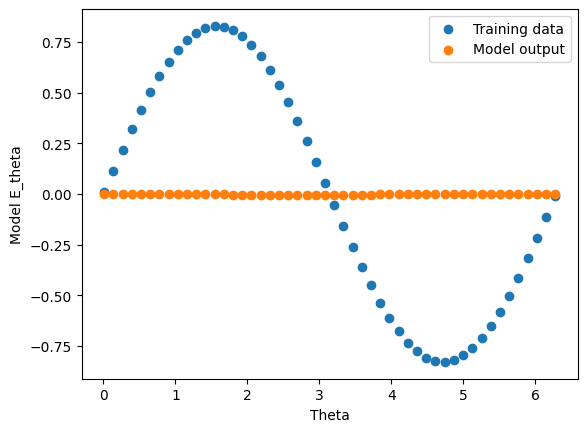

0 0.0812983363866806
40 0.07839486002922058
80 0.0746002197265625
120 0.07092531025409698
160 0.07087825983762741


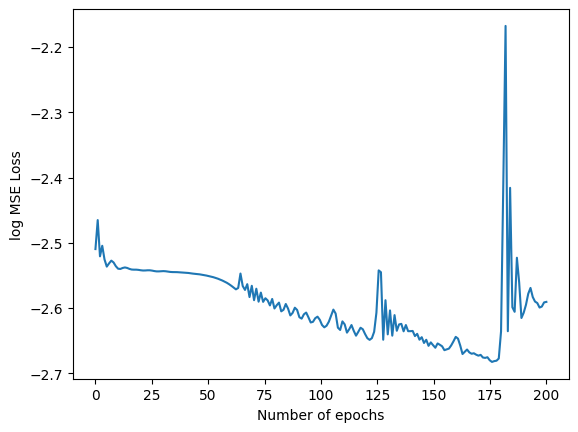

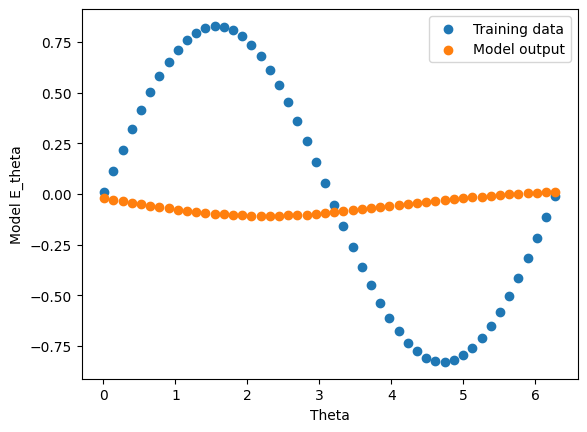

0 0.09398575872182846
40 0.07866346836090088
80 0.07780833542346954
120 0.07535579055547714
160 0.07418464124202728


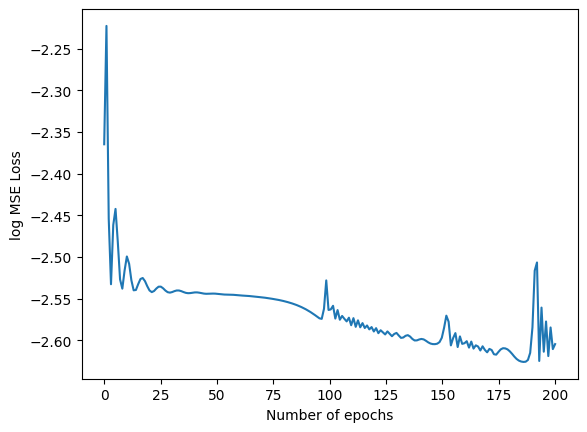

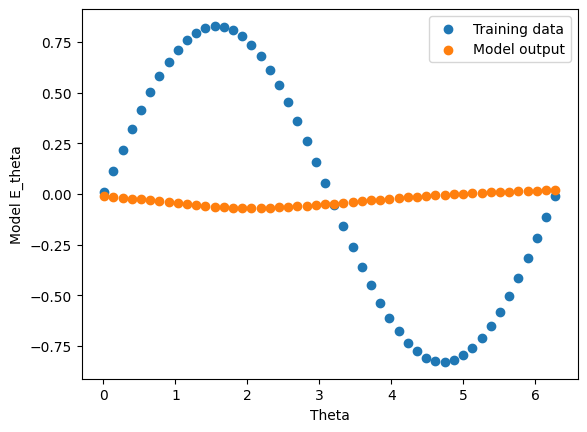

0 0.17723947763442993
40 0.07879923284053802
80 0.07853437960147858
120 0.07805592566728592
160 0.07707476615905762


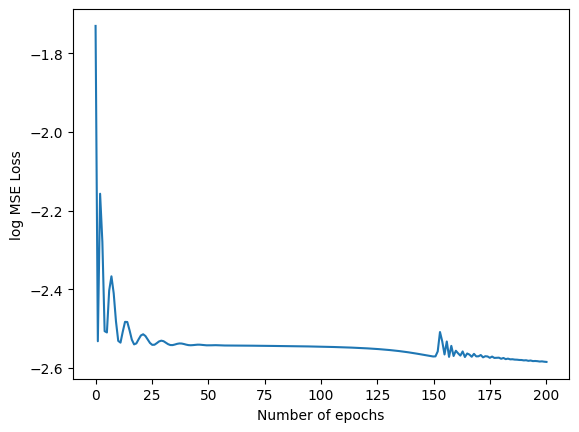

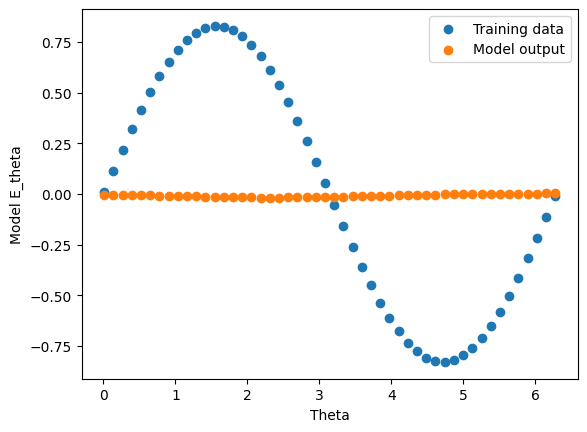

0 0.11514148861169815
40 0.07870887964963913
80 0.07835257798433304
120 0.07631660252809525
160 0.07810157537460327


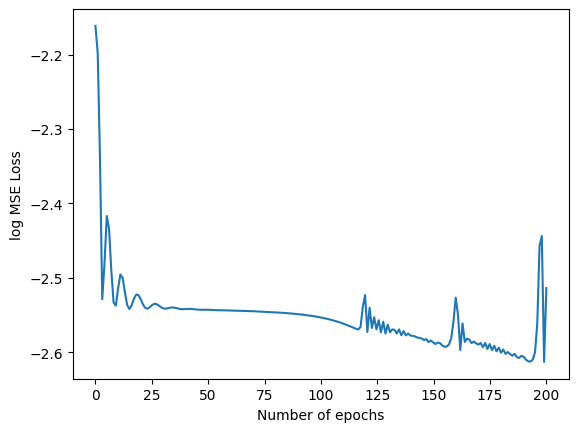

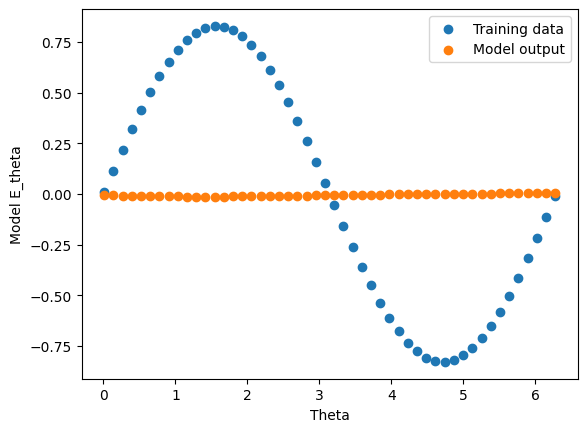

0 0.089072585105896
40 0.07875175774097443
80 0.07835254073143005
120 0.07743387669324875
160 0.07581854611635208


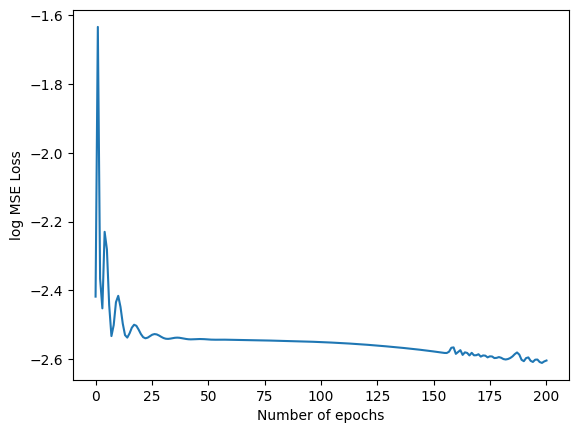

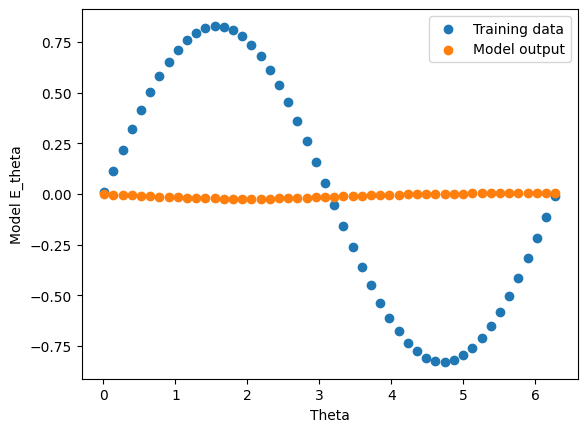

0 0.1783527433872223
40 0.07876143604516983
80 0.07858988642692566
120 0.0783439576625824
160 0.07718204706907272


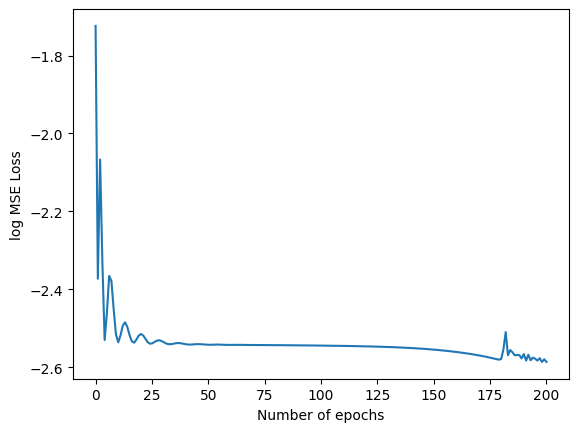

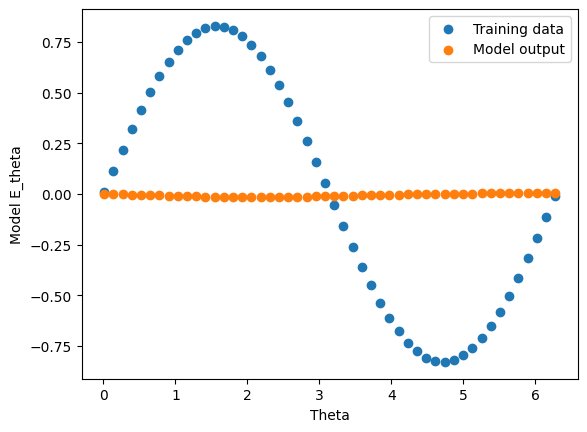

0 0.1830049604177475
40 0.07871554791927338
80 0.07853026688098907
120 0.07829834520816803
160 0.07770385593175888


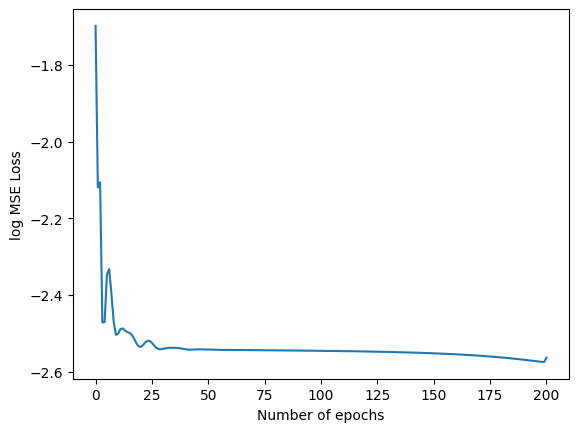

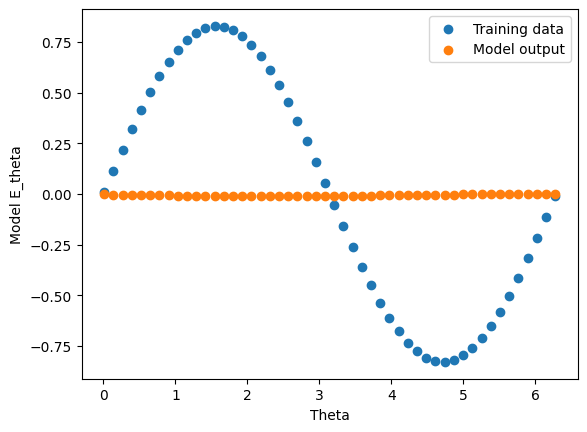

0 0.08284611254930496
40 0.07876432687044144
80 0.07864049077033997
120 0.07849603146314621
160 0.07770593464374542


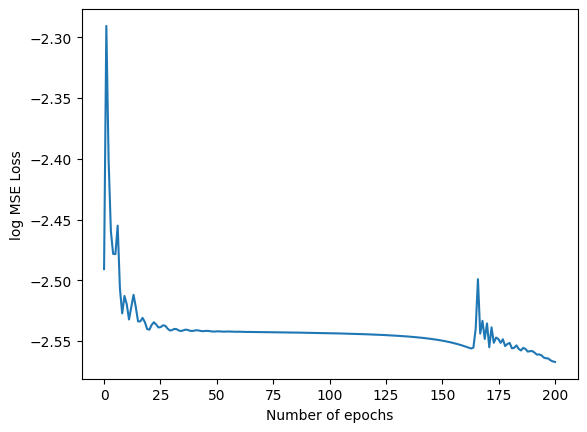

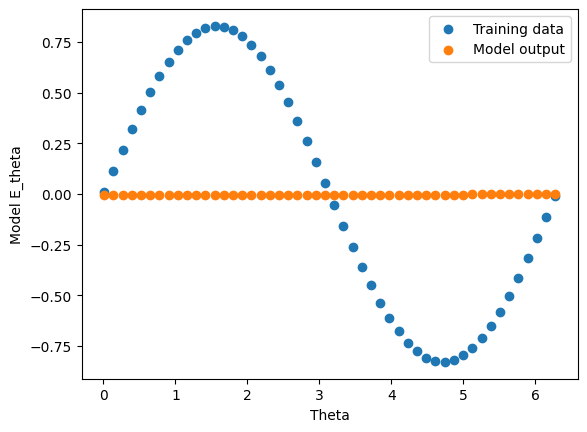

0 0.10204391181468964
40 0.0788712352514267
80 0.07867151498794556
120 0.0785885900259018
160 0.07844096422195435


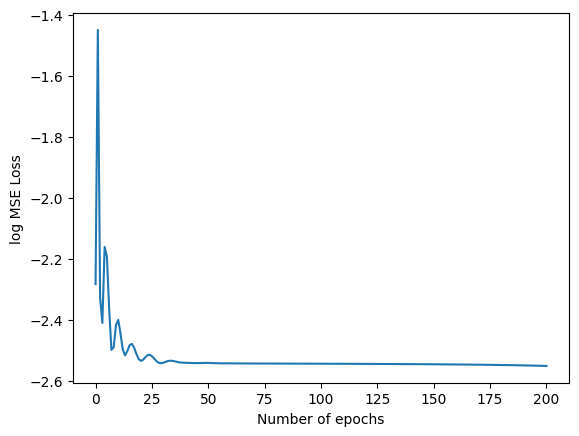

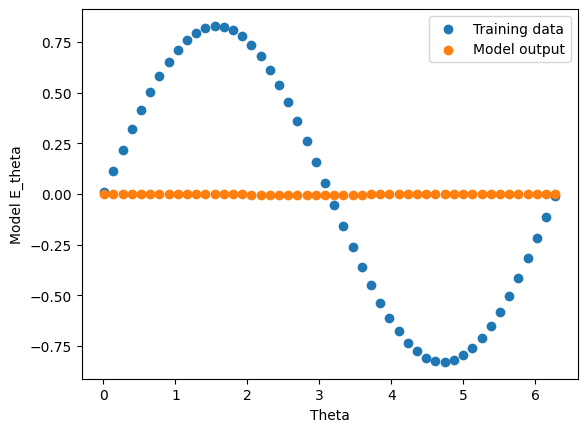

0 0.1498466432094574
40 0.07902044802904129
80 0.07863710075616837
120 0.0785164088010788
160 0.07823938876390457


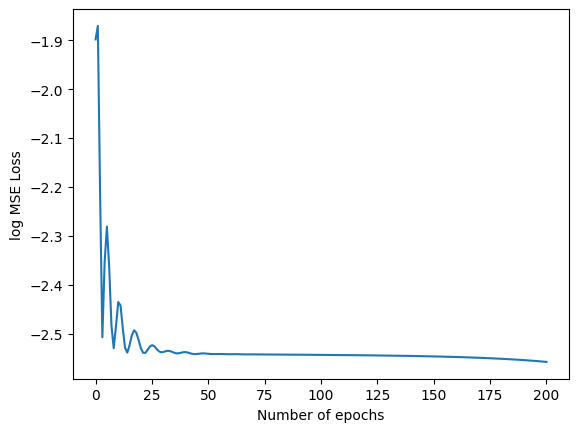

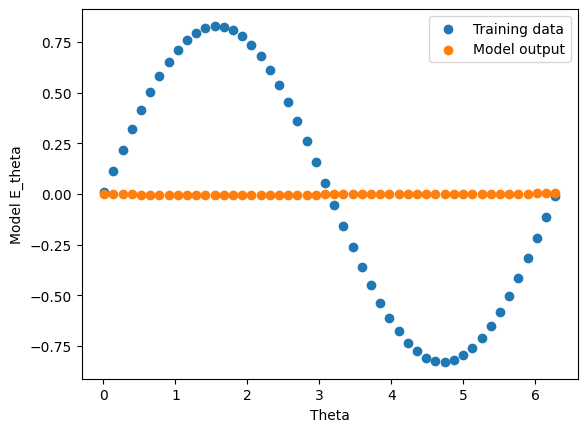

0 0.10090737044811249
40 0.09145763516426086
80 0.08781272917985916
120 0.0847742110490799
160 0.08282101154327393


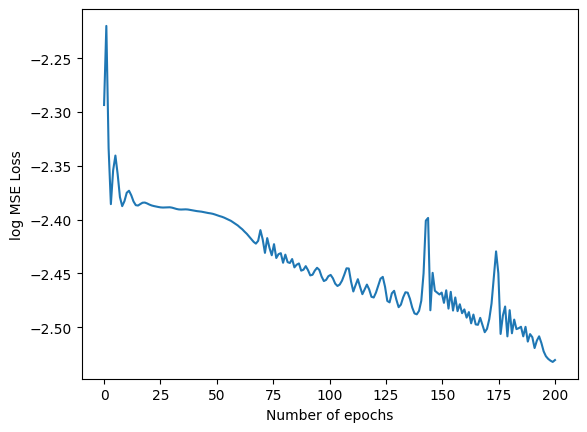

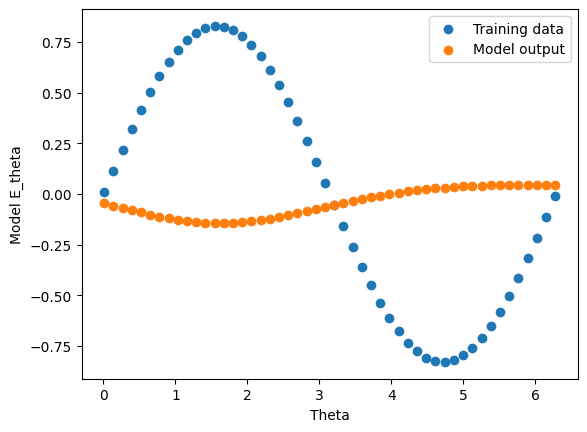

0 0.09417662769556046
40 0.09176706522703171
80 0.09133631736040115
120 0.08896186947822571
160 0.0859542265534401


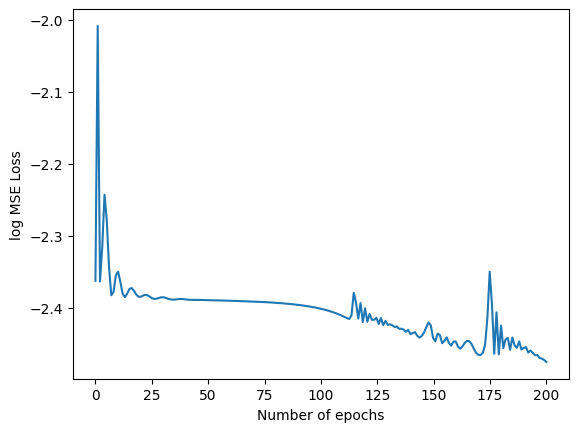

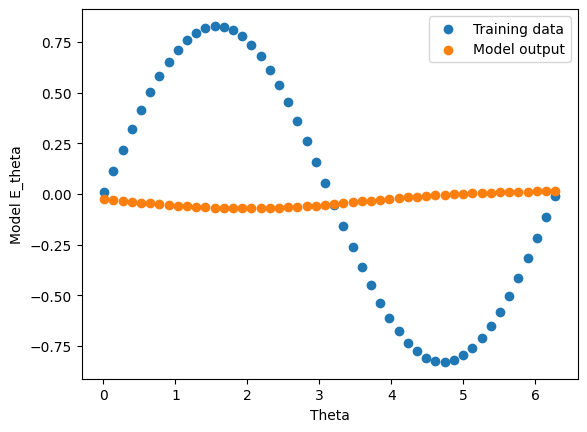

0 0.10078327357769012
40 0.09181300550699234
80 0.0910324826836586
120 0.08961666375398636
160 0.08668259531259537


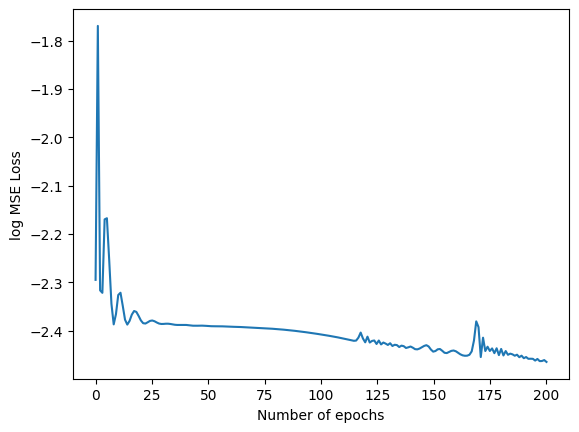

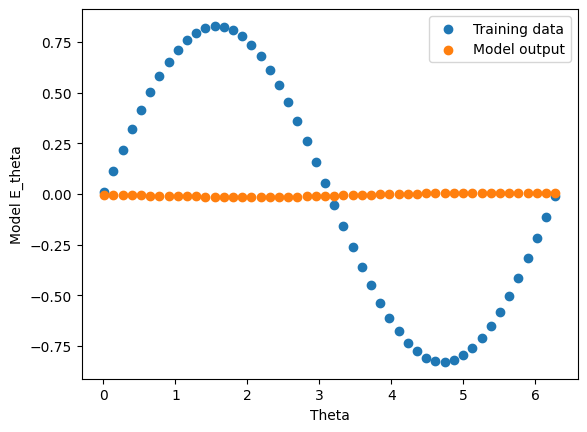

0 0.09958149492740631
40 0.09180325269699097
80 0.09135308116674423
120 0.08953142911195755
160 0.08794157952070236


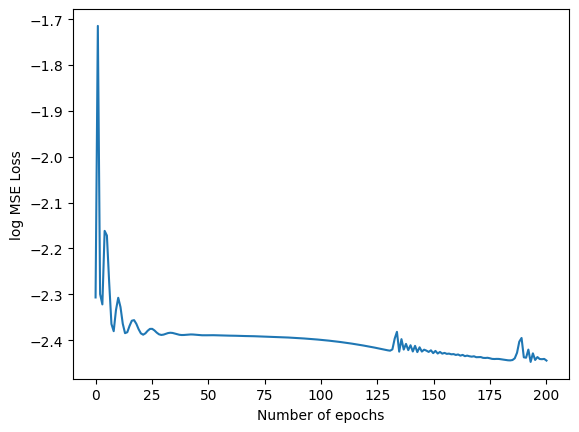

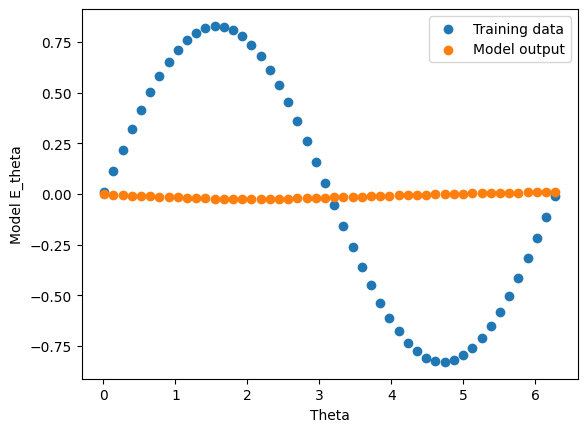

0 0.11347829550504684
40 0.09173794090747833
80 0.09140028804540634
120 0.09013178944587708
160 0.0879676565527916


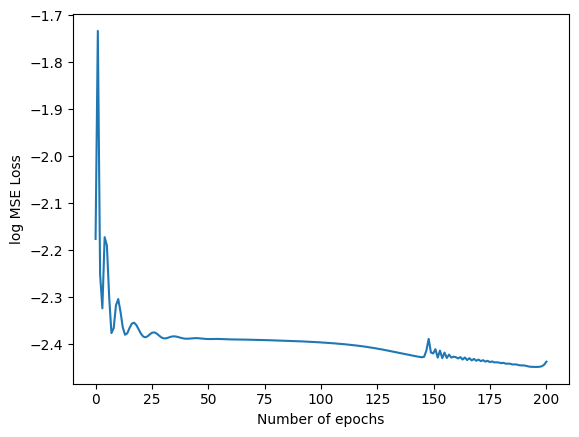

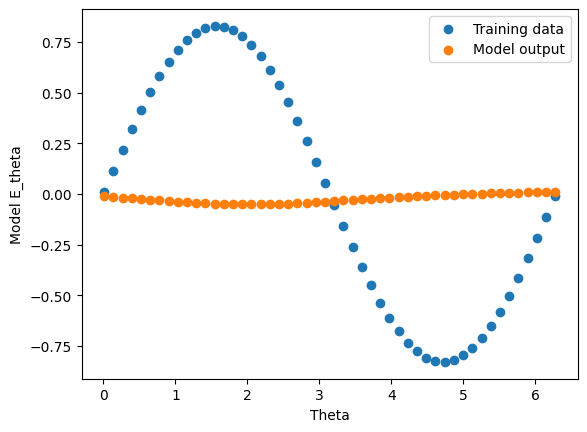

0 0.09416011720895767
40 0.09200038760900497
80 0.09168758243322372
120 0.09145068377256393
160 0.09055738151073456


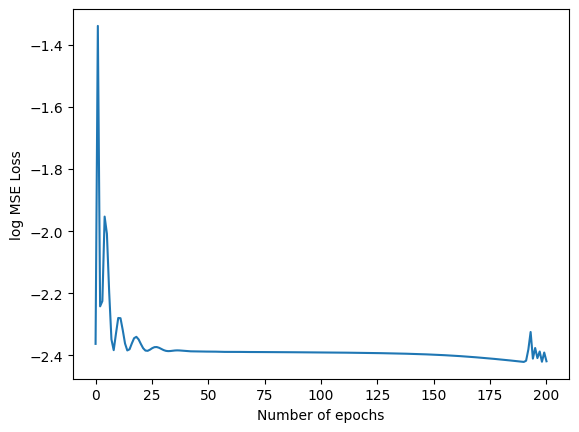

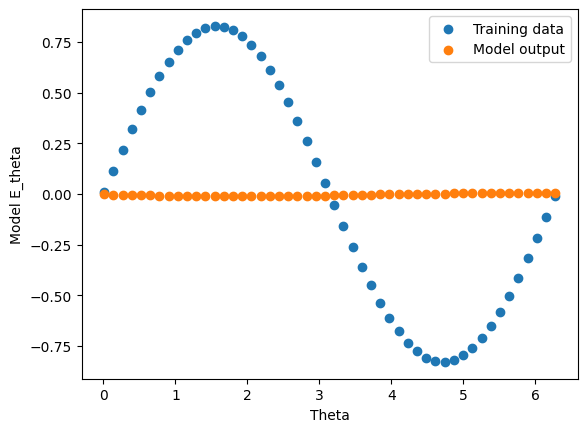

0 0.14885027706623077
40 0.09195937216281891
80 0.09147989749908447
120 0.09043392539024353
160 0.08948446810245514


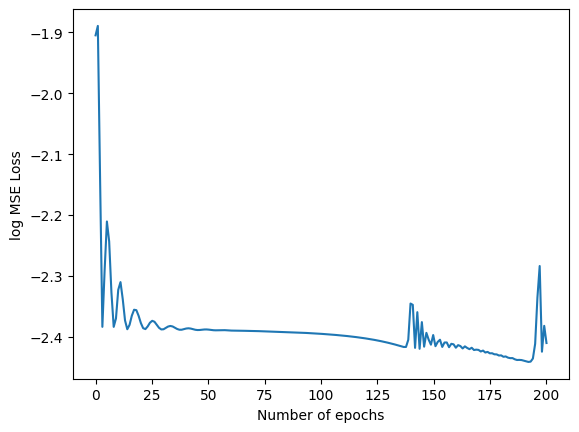

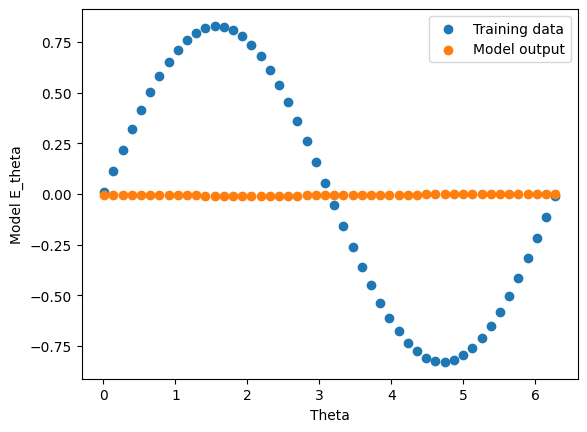

0 0.14661267399787903
40 0.09193775802850723
80 0.09158285707235336
120 0.09110219031572342
160 0.08994654566049576


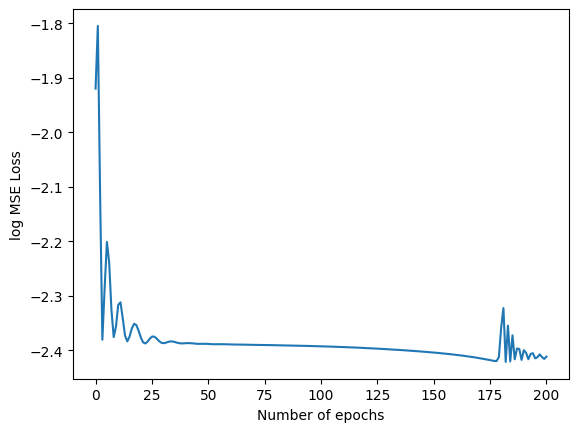

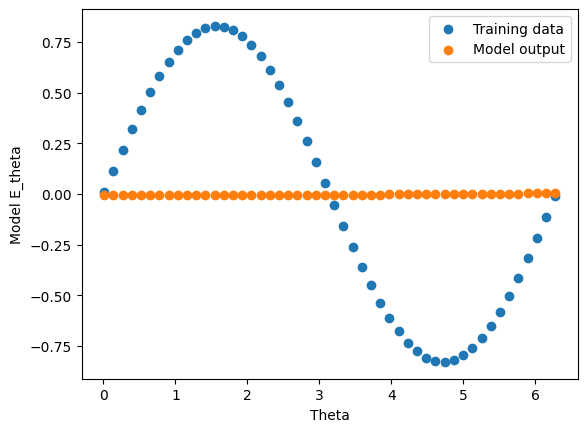

0 0.09542869031429291
40 0.09197711199522018
80 0.09172382950782776
120 0.09147521108388901
160 0.09037519991397858


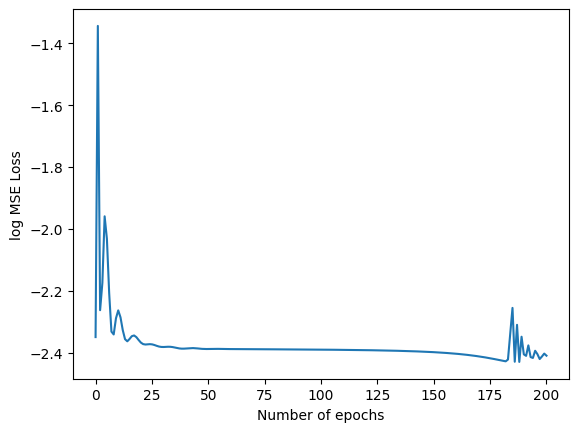

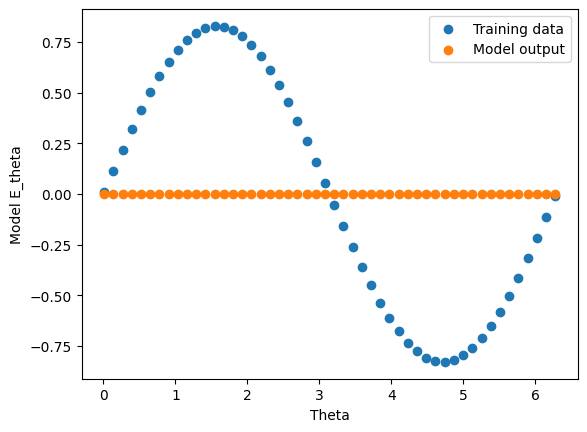

0 0.12043437361717224
40 0.0920175164937973
80 0.09167639166116714
120 0.0913766399025917
160 0.09050639718770981


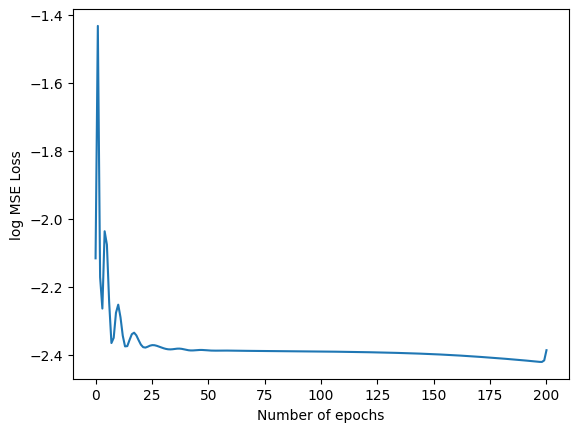

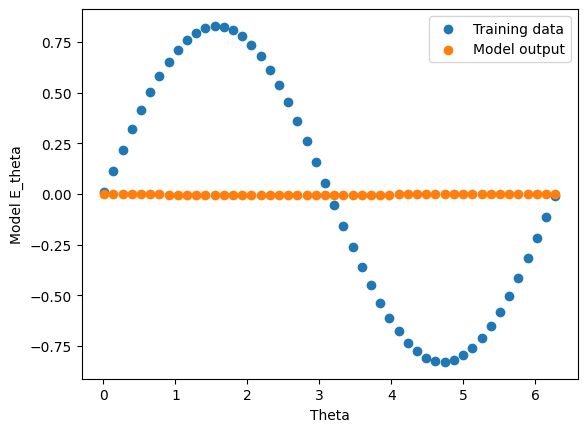

0 0.10872717946767807
40 0.10426393151283264
80 0.1012832298874855
120 0.09631871432065964
160 0.09427892416715622


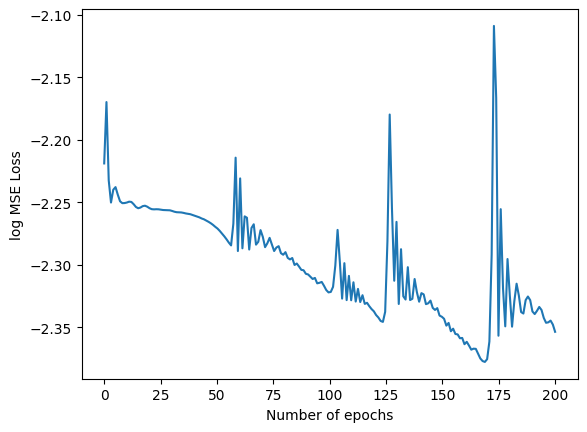

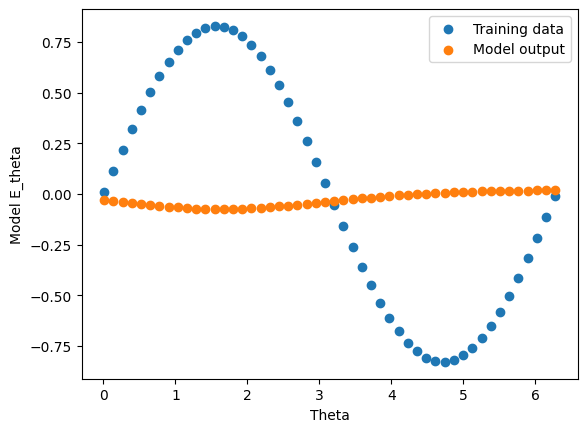

0 0.1330539435148239
40 0.10475040972232819
80 0.1030942052602768
120 0.09823574125766754
160 0.09504260122776031


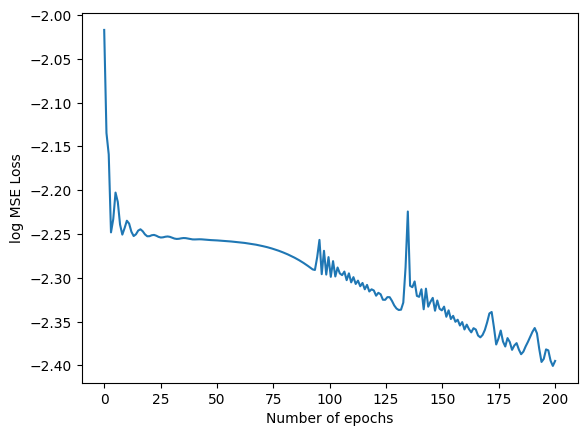

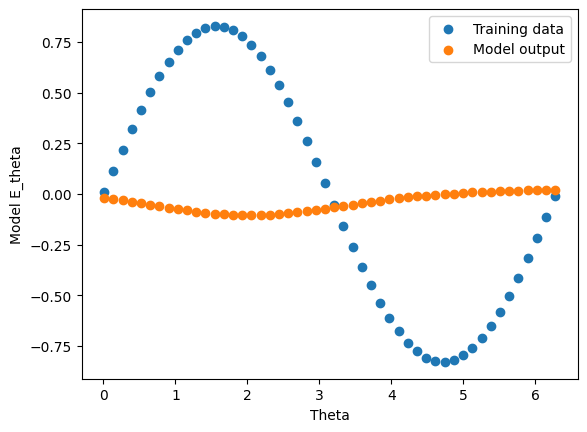

0 0.16298069059848785
40 0.10481630265712738
80 0.10389485955238342
120 0.10049757361412048
160 0.09868387132883072


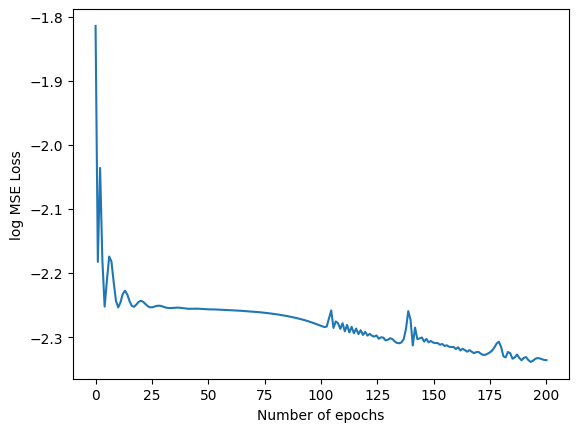

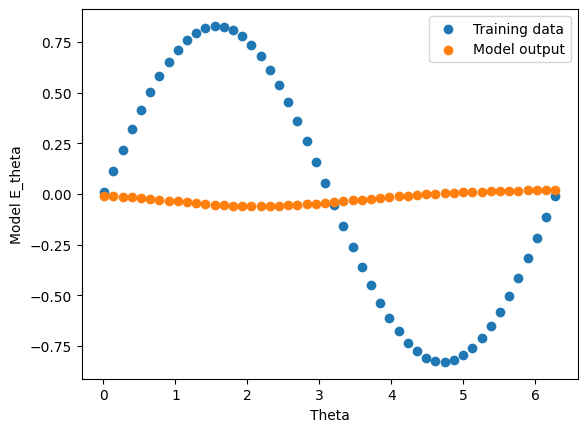

0 0.19965562224388123
40 0.10489799082279205
80 0.10452074557542801
120 0.10342659801244736
160 0.10327183455228806


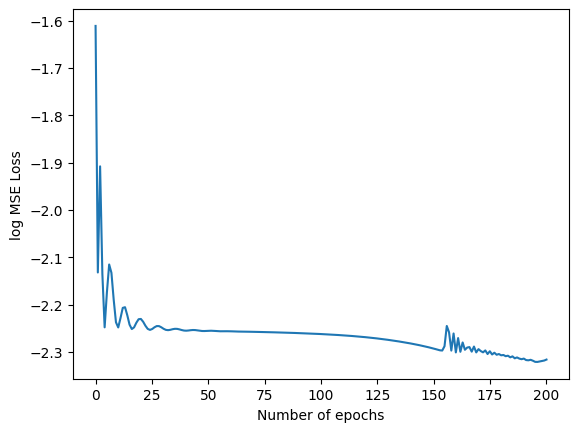

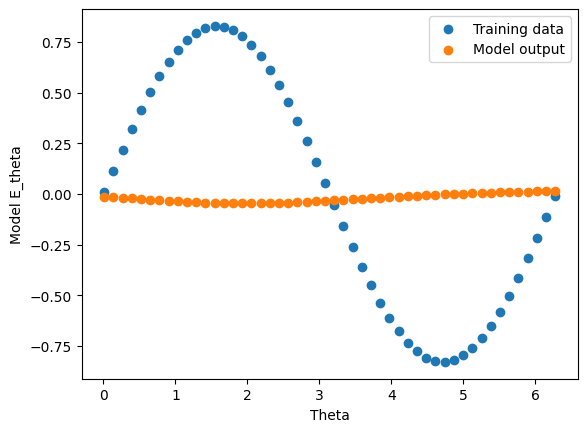

0 0.12164062261581421
40 0.10473118722438812
80 0.10389338433742523
120 0.1006770208477974
160 0.09782398492097855


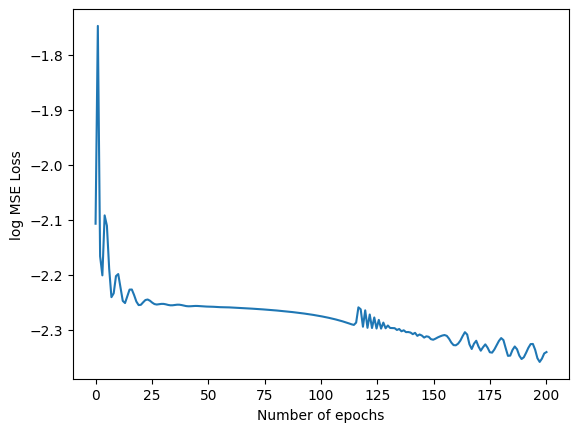

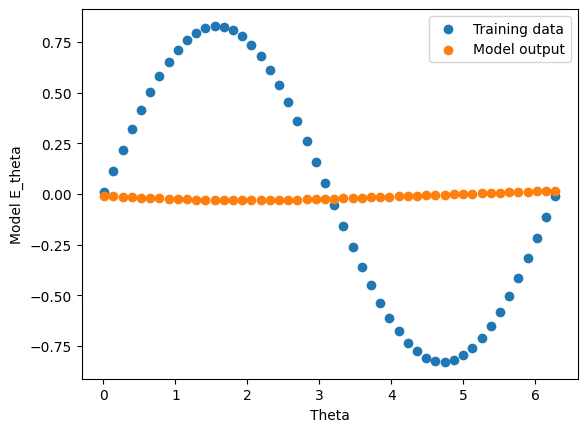

0 0.16832026839256287
40 0.10505747050046921
80 0.10480241477489471
120 0.10452285408973694
160 0.10262808203697205


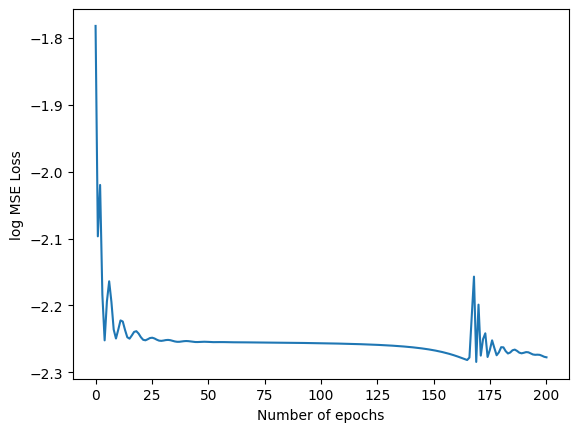

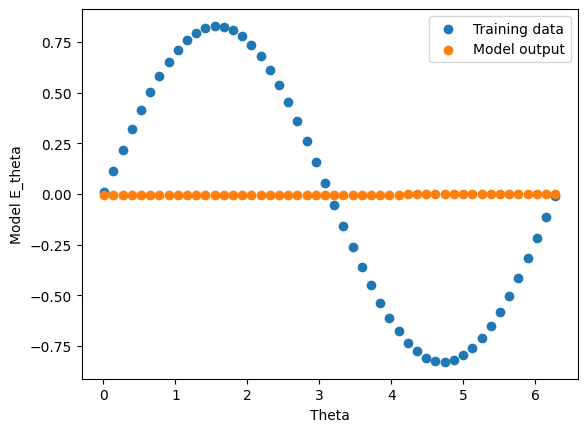

0 0.28349238634109497
40 0.1049569770693779
80 0.10472387820482254
120 0.1042991504073143
160 0.10205189138650894


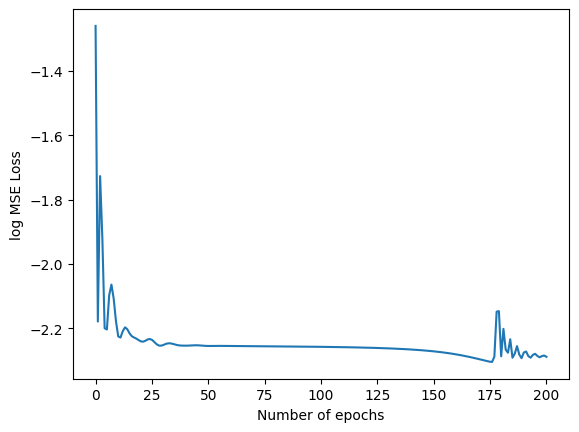

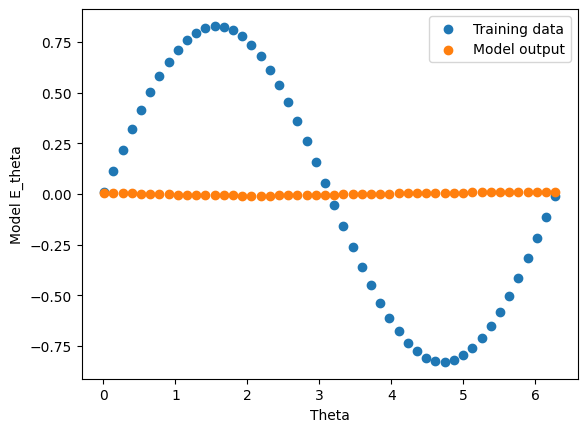

0 0.11412014067173004
40 0.10520420968532562
80 0.10485278815031052
120 0.10470212250947952
160 0.10431384295225143


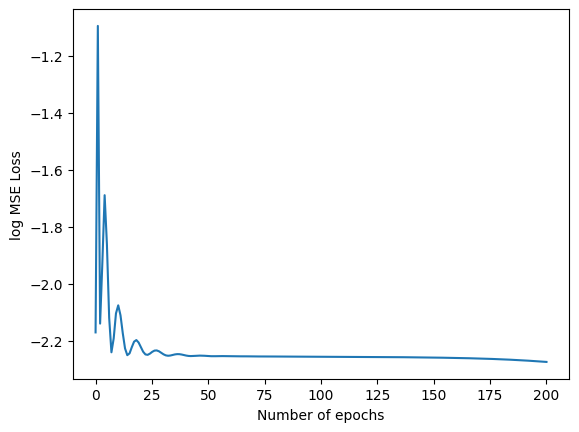

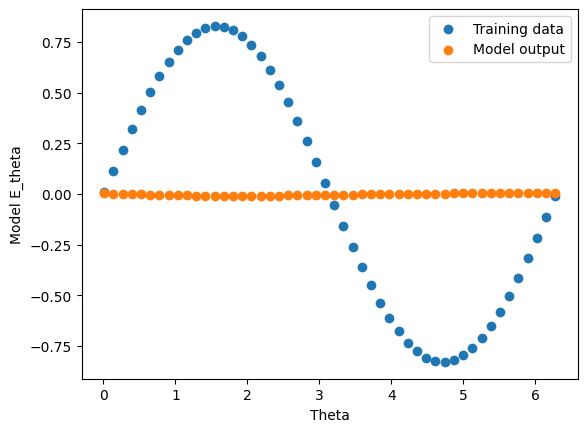

0 0.22655829787254333
40 0.10495192557573318
80 0.10454472154378891
120 0.10345381498336792
160 0.1025034487247467


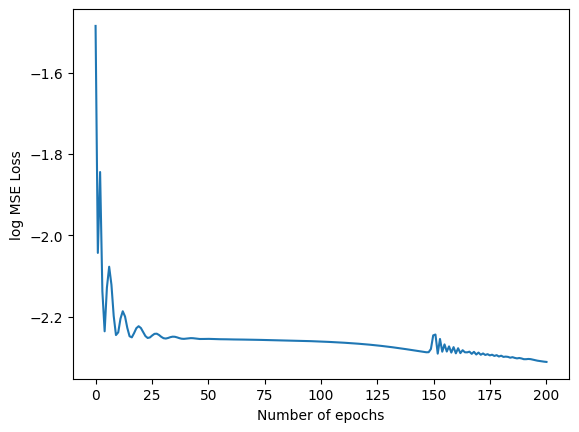

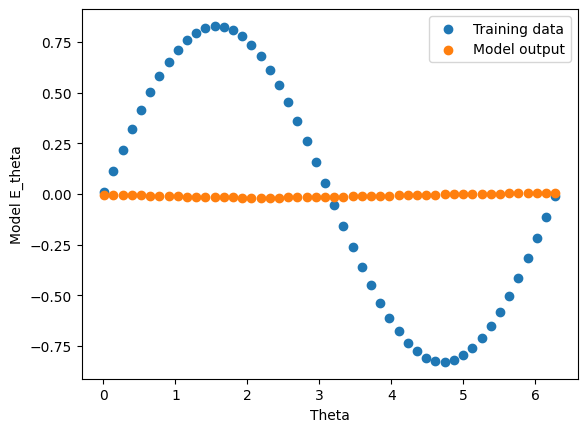

0 0.11169306188821793
40 0.10538824647665024
80 0.10488123446702957
120 0.10479562729597092
160 0.10462038218975067


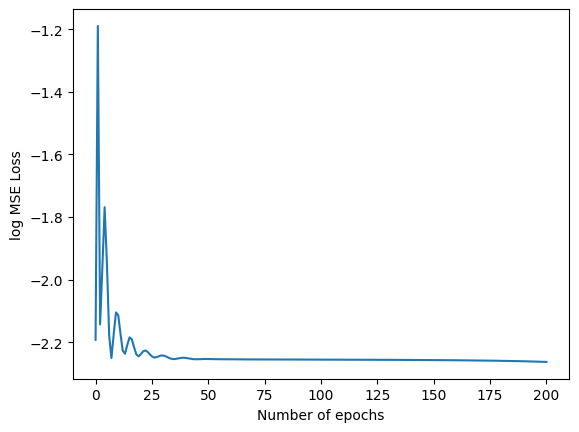

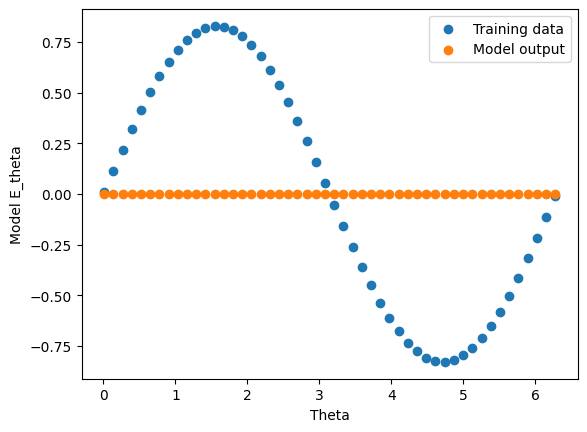

0 0.1639094054698944
40 0.11794768273830414
80 0.11734522879123688
120 0.11239048093557358
160 0.10719455033540726


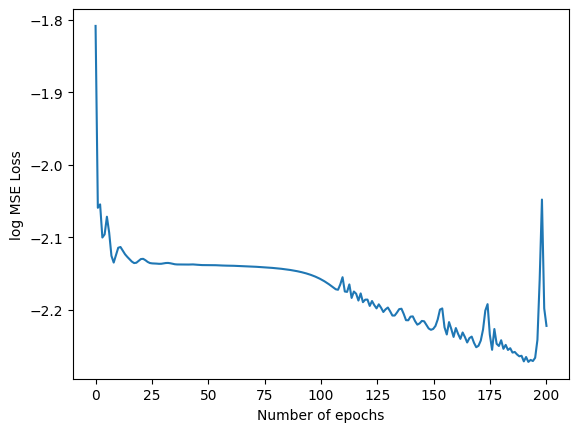

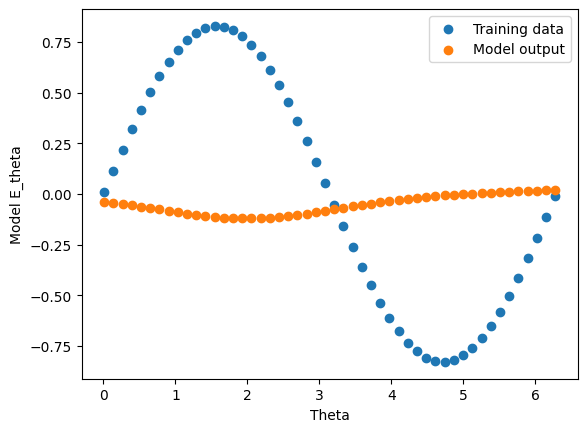

0 0.1304941475391388
40 0.11777076870203018
80 0.1149185448884964
120 0.1101585105061531
160 0.10894841700792313


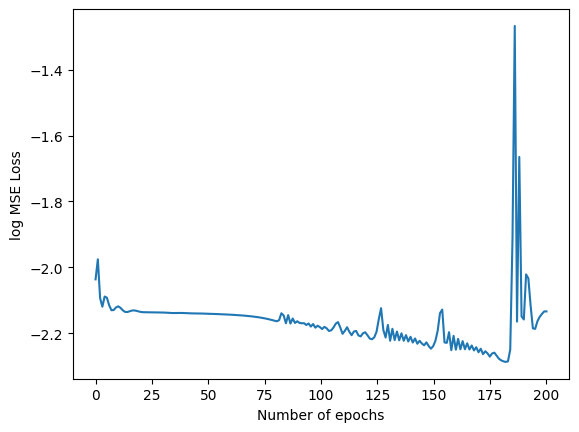

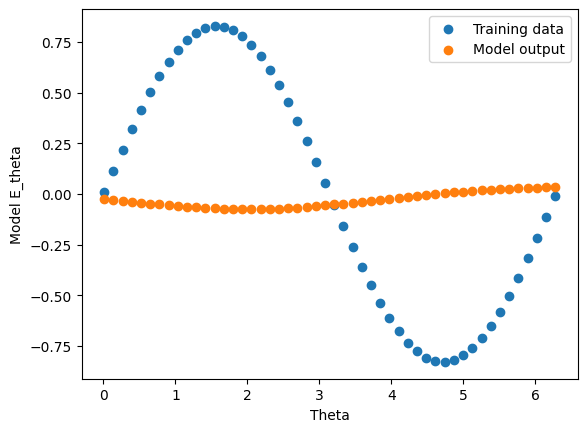

0 0.12030692398548126
40 0.11730414628982544
80 0.1124517023563385
120 0.1118885800242424
160 0.10760723054409027


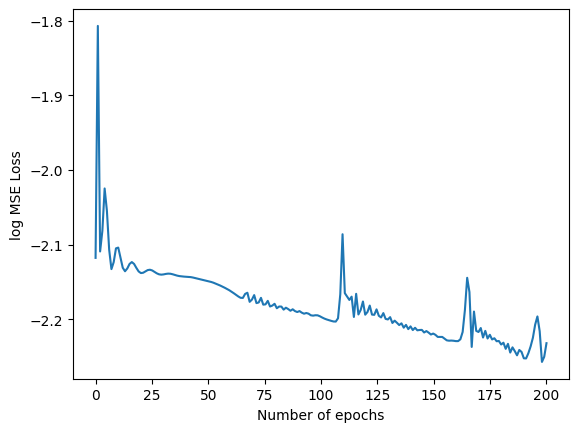

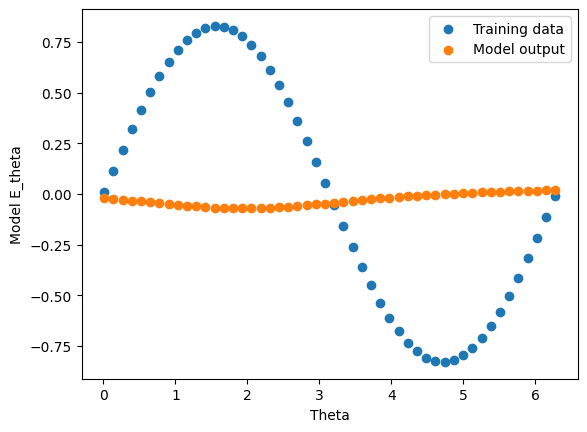

0 0.16453072428703308
40 0.11795990914106369
80 0.11667776852846146
120 0.11225426942110062
160 0.10901495814323425


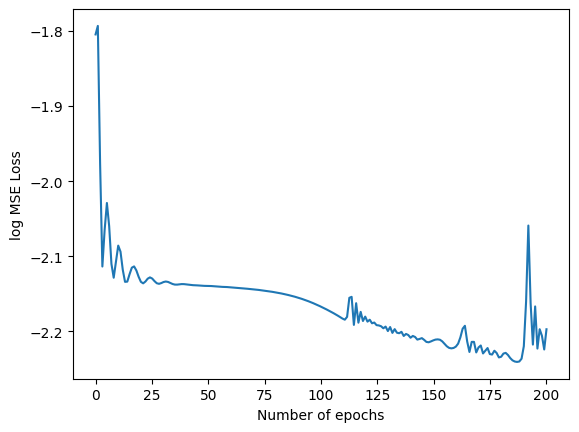

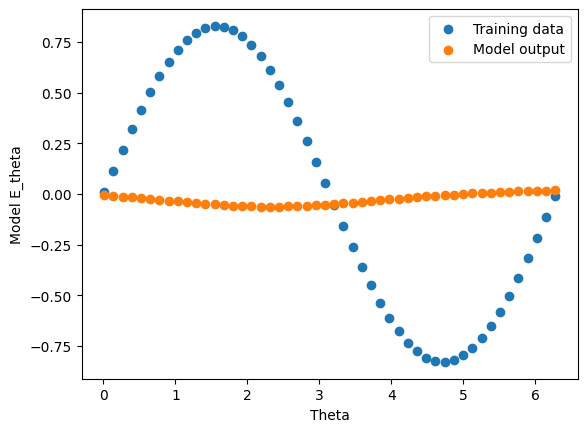

0 0.12791669368743896
40 0.11789588630199432
80 0.11665518581867218
120 0.11532610654830933
160 0.11141036450862885


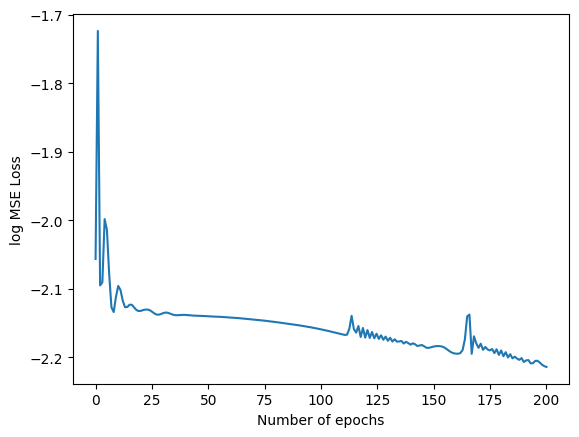

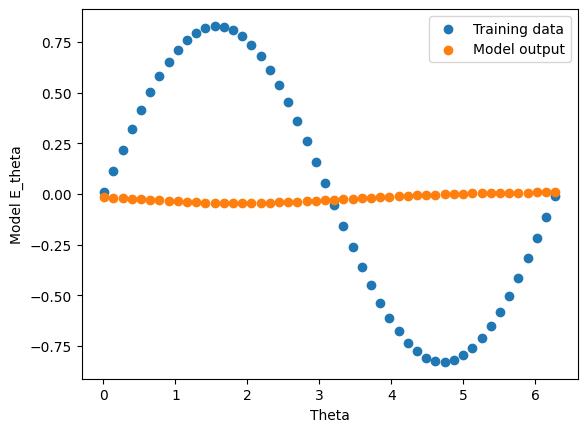

0 0.27980077266693115
40 0.11815588921308517
80 0.11790426820516586
120 0.11747723817825317
160 0.11466585099697113


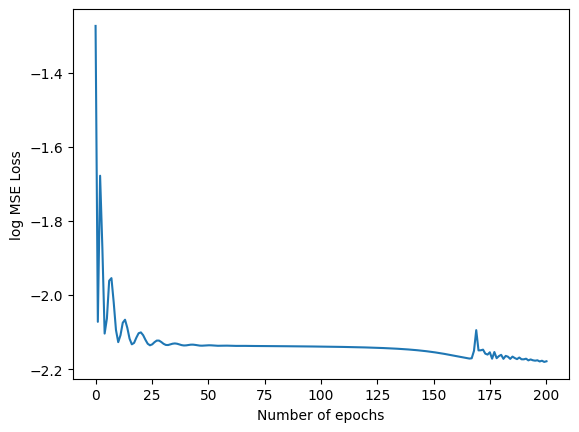

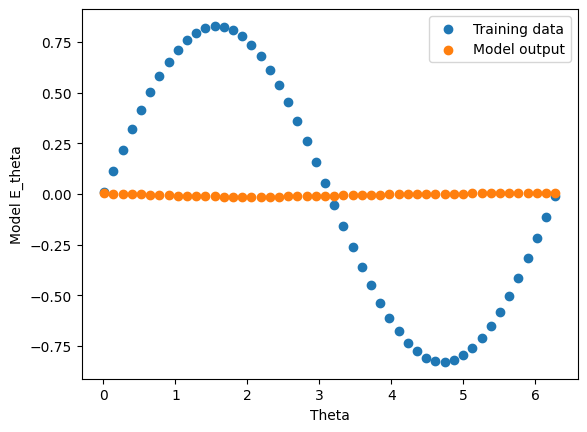

0 0.41060498356819153
40 0.11845910549163818
80 0.11786612868309021
120 0.11757592856884003
160 0.11686205118894577


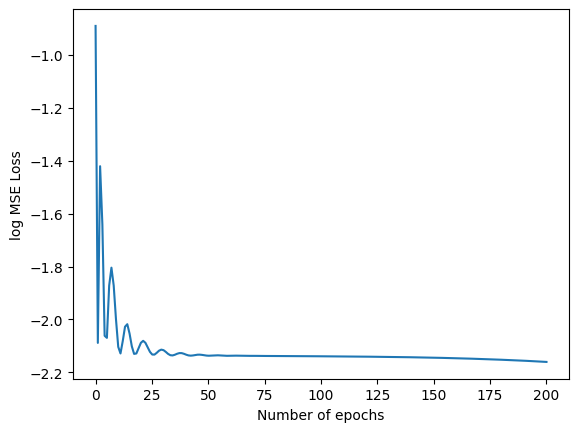

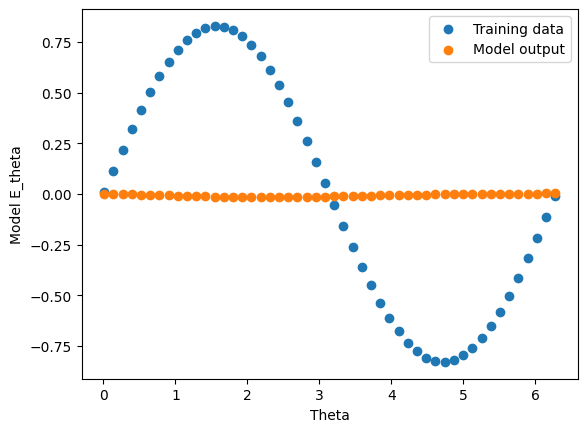

0 0.2530094087123871
40 0.11819782108068466
80 0.11719143390655518
120 0.11389394104480743
160 0.11088196188211441


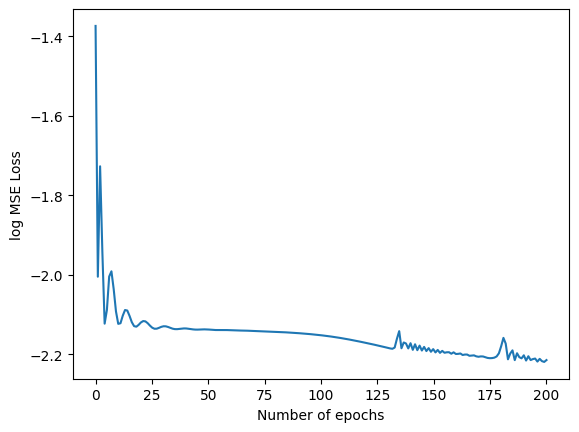

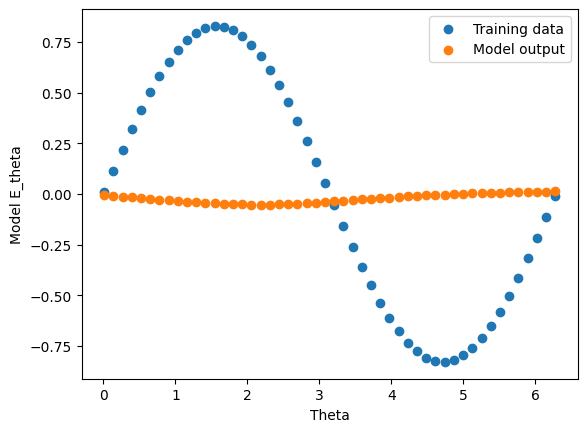

0 0.26617348194122314
40 0.11813118308782578
80 0.11771439760923386
120 0.11701007187366486
160 0.1151469349861145


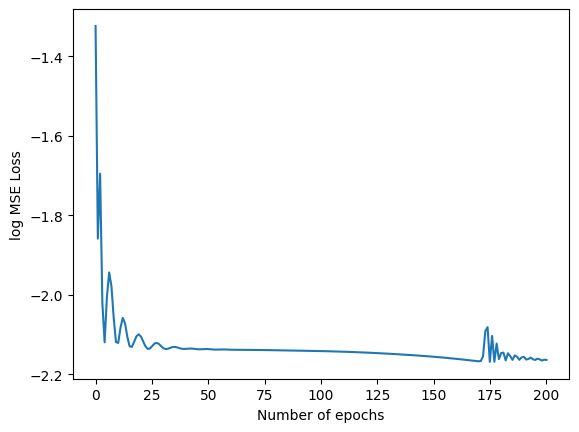

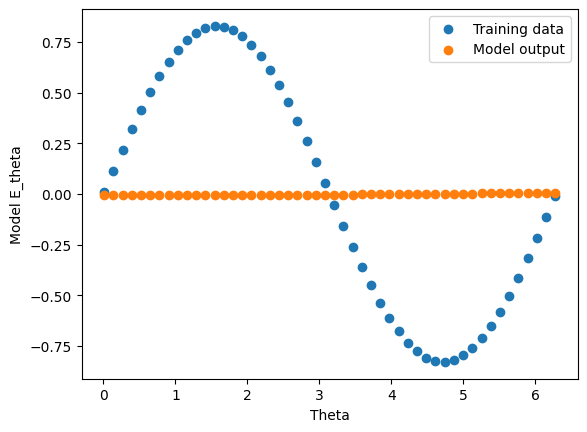

0 0.35610756278038025
40 0.11825332790613174
80 0.11790303885936737
120 0.11764799058437347
160 0.11706962436437607


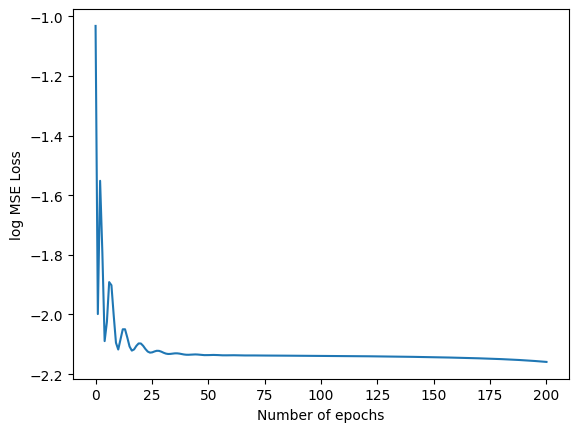

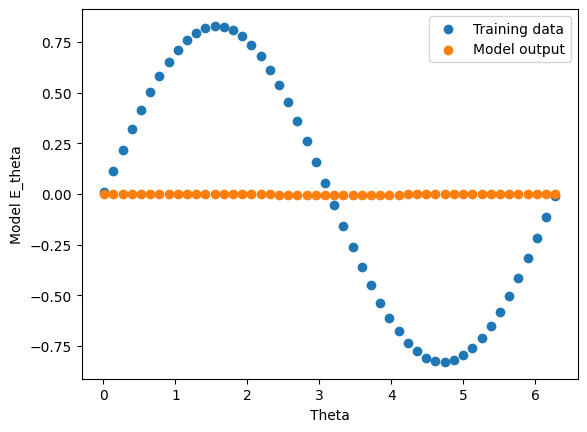

0 0.15760564804077148
40 0.13076573610305786
80 0.1271488070487976
120 0.12552416324615479
160 0.11501126736402512


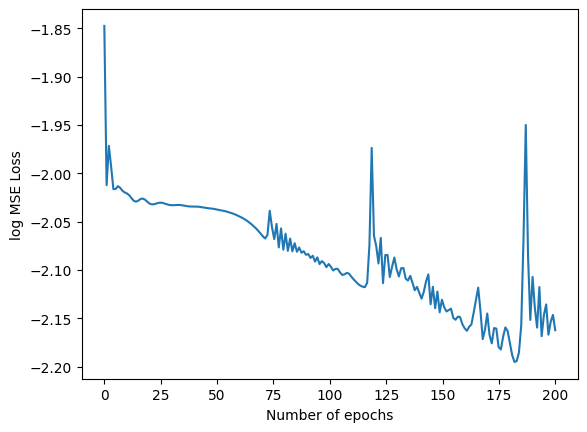

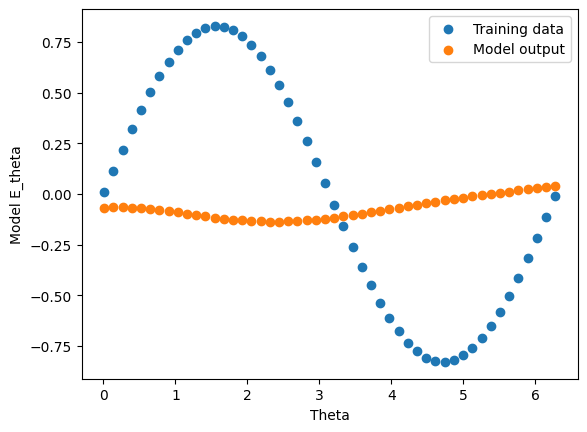

0 0.1391279697418213
40 0.1310127228498459
80 0.12790651619434357
120 0.1235930472612381
160 0.12182558327913284


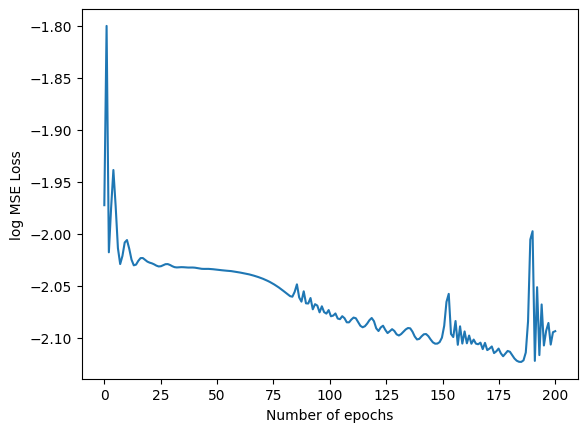

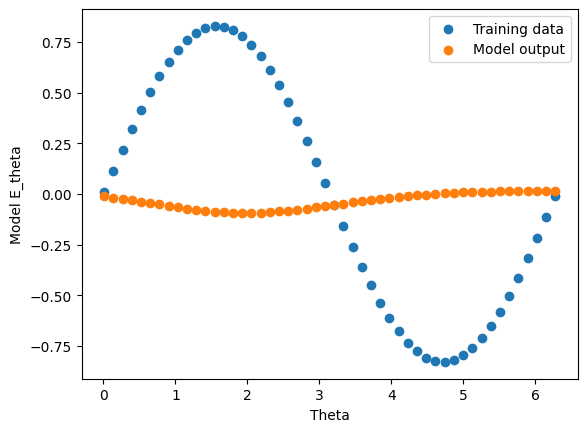

0 0.15581952035427094
40 0.13079819083213806
80 0.12924093008041382
120 0.12340713292360306
160 0.11708883196115494


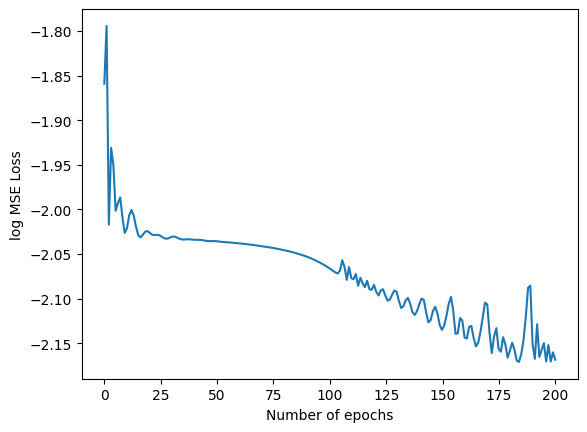

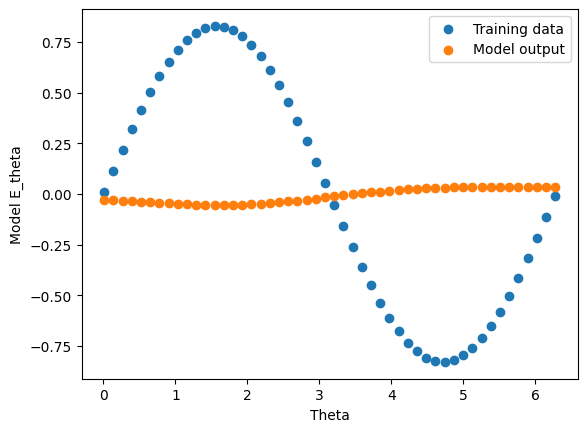

0 0.1361125111579895
40 0.1310880333185196
80 0.13056015968322754
120 0.12987902760505676
160 0.1245189681649208


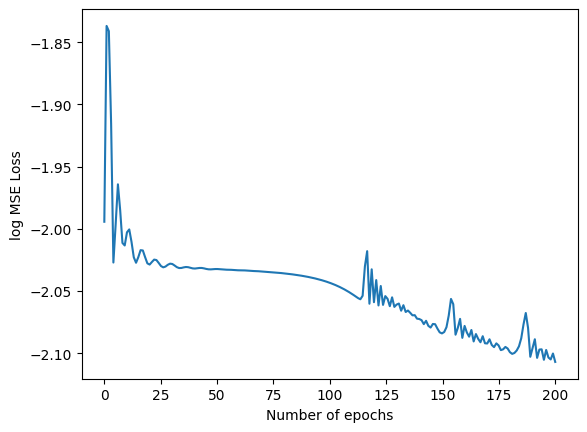

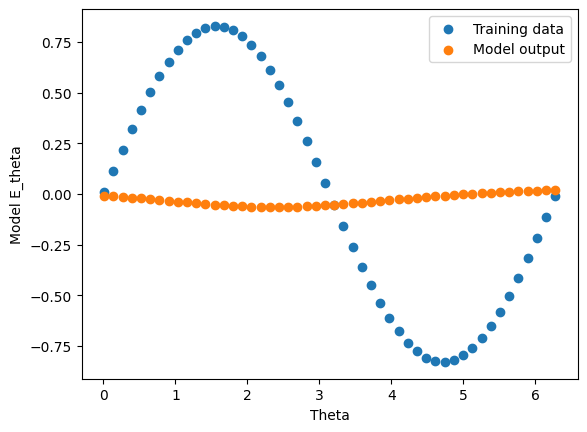

0 0.28356873989105225
40 0.13124676048755646
80 0.1309448480606079
120 0.130308598279953
160 0.12630943953990936


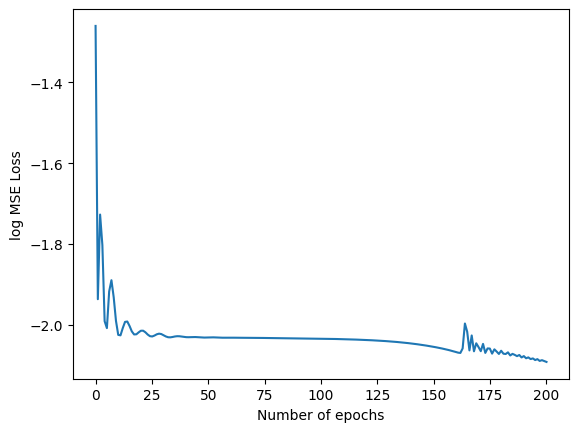

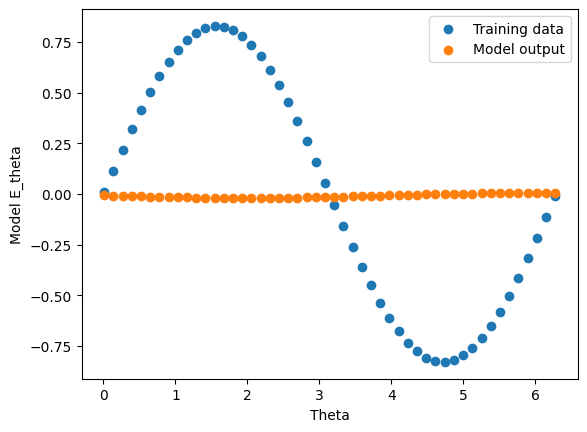

0 0.22596505284309387
40 0.1312590390443802
80 0.13049007952213287
120 0.13101619482040405
160 0.12417610734701157


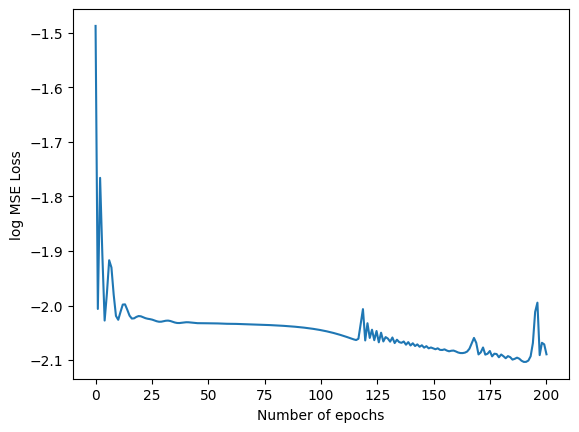

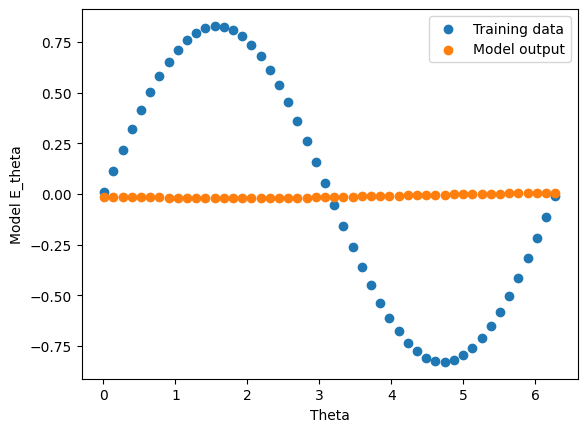

0 0.2155846208333969
40 0.13110829889774323
80 0.13033351302146912
120 0.12901104986667633
160 0.12557290494441986


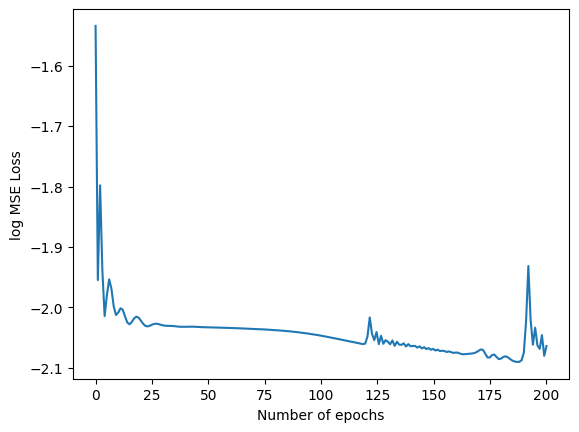

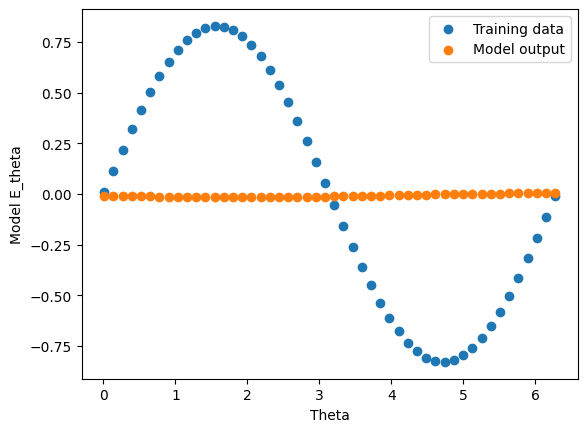

0 0.38979247212409973
40 0.1318146288394928
80 0.13091006875038147
120 0.130457803606987
160 0.12872570753097534


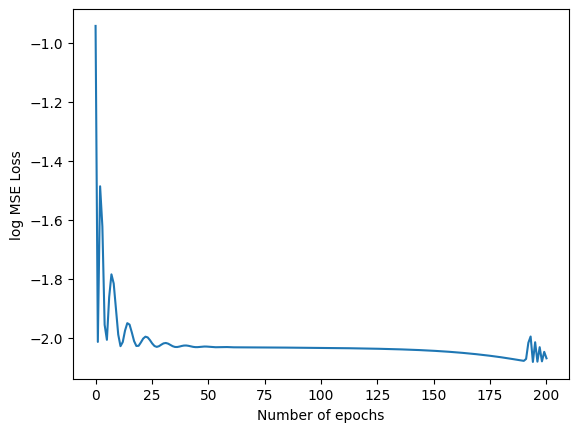

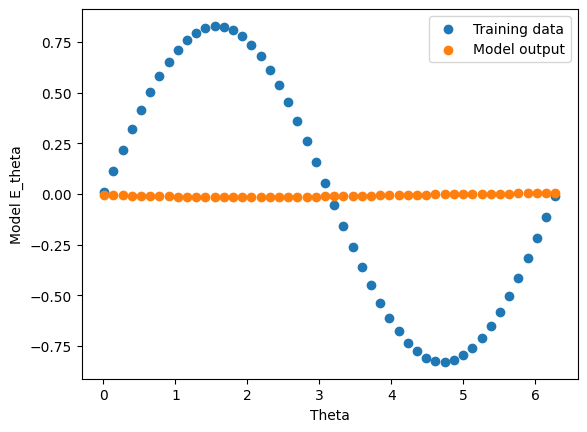

0 0.15963943302631378
40 0.1312367469072342
80 0.13053329288959503
120 0.1285671591758728
160 0.12543877959251404


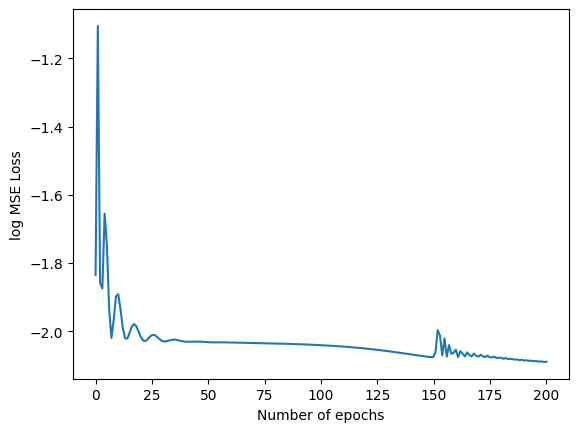

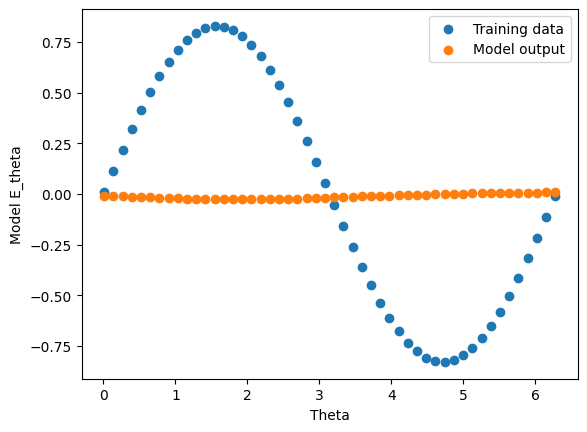

0 0.18913671374320984
40 0.13113035261631012
80 0.13049183785915375
120 0.12704156339168549
160 0.12542326748371124


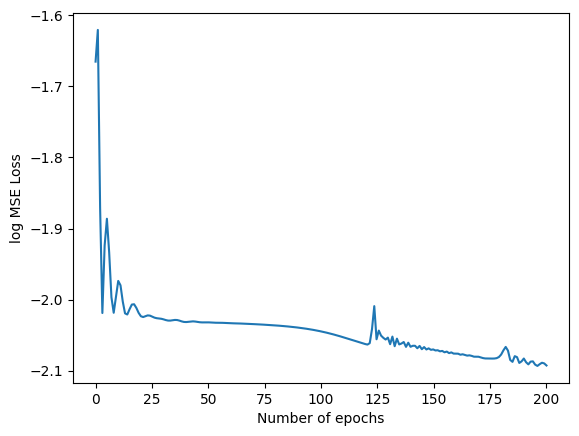

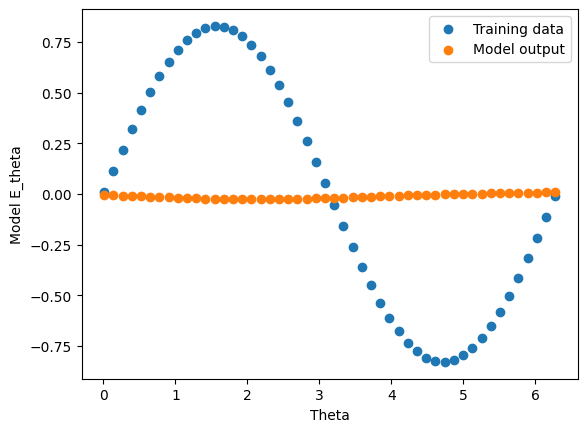

((1.0, 0.30000000000000004), 0.11166523396968842)

In [67]:
grid_search_alpha_beta(0.1, 1, 0.1, 1.0, 10, soft_rtheta_t_input, soft_rtheta_train_data, 200)

In [189]:
def jacob_E_rtheta_field_HD_tensor(r_theta_t, p_0=p_0, omega=omega, noise=False):
   '''Calculates the real electric field's r and theta components'''

   r = r_theta_t[...,0]
   theta = r_theta_t[...,1]
   t = r_theta_t[...,2]
   ret_p = p_0 * torch.cos(omega*(t - r/c)) #the dipole moment evaluated at retarded time for c=10
   ret_p_dot = -omega * p_0 * torch.sin(omega*(t-r/c)) #first time deriv
   ret_p_ddot = -omega**2 * p_0 * torch.cos(omega*(t - r/c)) #second time deriv

   radial_bracket = ret_p/(r**3) + ret_p_dot/(c*r**2) #bracket in radial electric field term
   polar_bracket = ret_p/(r**3) + ret_p_dot/(c*r**2) + ret_p_ddot/(c**2*r) #bracket in polar electric field term

   E_r = (2*torch.cos(theta)/(4*math.pi*eps_0))*radial_bracket
   E_theta = (torch.sin(theta)/(4*math.pi*eps_0))*polar_bracket

   if noise:
      E_r = E_r + torch.normal(0.0, 0.1*torch.mean(torch.abs(E_r)))
      E_theta = E_theta + torch.normal(0.0, 0.1*torch.mean(torch.abs(E_theta)))

   return torch.stack((E_r, E_theta), axis=-1)

In [194]:
jacob_rtheta_t = generate_rtheta_t_tensor(3.0,10.0,0.4*math.pi, 5)
jacob_rtheta_t = torch.stack(jacob_rtheta_t, dim=-1)

torch.autograd.functional.jacobian(jacob_E_rtheta_field_HD_tensor, jacob_rtheta_t)

tensor([[[[[[[[-1.7847e+00, -1.8473e-02,  5.2541e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

             [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

             [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00]],

             [[ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
              [ 0.0000e+00,  0.0000e+00,  0.0000e+00],
    